In [1]:
#Loading all the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold,GridSearchCV,train_test_split
import seaborn as sns
from catboost import CatBoostRegressor
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression

## Data Overview
Importing the data into a pandas dataframe. Afterwards analyzing the data generally to understand what we are dealing with. I will also plot the data so that I get a better understanding of how it behaves over time

In [2]:
data = pd.read_csv("demand_dataset.zip",sep = ';', header=0)

In [3]:
data.head()

material plant_code  cases    value  sales_date  f_day  adbno  \
0  D13384914       AC01      1    74.84  2017-01-04    198      4   
1  D13384914       AC01      2   149.68  2017-01-05    198      4   
2  D13384914       AC01     24  1803.06  2017-01-10    198      4   
3  D13384914       AC01      9   717.75  2017-01-11    198      4   
4  D13384914       AC01      8   659.76  2017-01-12    198      4   

  product_description  service_level   mrp_desc       group2_desc  \
0    TY120SWHXL002500           0.92  Coveralls  TYVEK PROTECTION   
1    TY120SWHXL002500           0.92  Coveralls  TYVEK PROTECTION   
2    TY120SWHXL002500           0.92  Coveralls  TYVEK PROTECTION   
3    TY120SWHXL002500           0.92  Coveralls  TYVEK PROTECTION   
4    TY120SWHXL002500           0.92  Coveralls  TYVEK PROTECTION   

        group3_desc     group6_desc  est_lead_time sku_class  IS_HOL  \
0  TYVEK PROTECTION  Finished Goods             16        AX       0   
1  TYVEK PROTECTION  Finished Goods             16        AX       0   
2  TYVEK PROTECTION  Finished Goods             16        AX       0   
3  TYVEK PROTECTION  Finished Goods             16        AX       0   
4  TYVEK PROTECTION  Finished Goods             16        AX       0   

          day  month  year  log_cases  
0    Mittwoch      1  2017   0.000000  
1  Donnerstag      1  2017   0.693147  
2    Dienstag      1  2017   3.178054  
3    Mittwoch      1  2017   2.197225  
4  Donnerstag      1  2017   2.079442

In [4]:
data.shape

(191860, 20)

In [5]:
data.describe()

cases          value          f_day          adbno  \
count  191860.000000  191860.000000  191860.000000  191860.000000   
mean      125.661555    2644.521517     263.547243       6.600261   
std      1011.767792    8129.905428     157.712907      13.025606   
min         1.000000  -42538.120000       2.000000       1.000000   
25%         3.000000     272.820000     134.000000       2.000000   
50%        10.000000     695.440000     240.000000       3.000000   
75%        42.000000    1913.135000     392.000000       6.000000   
max    152310.000000  456422.500000     562.000000     632.000000   

       service_level  est_lead_time         IS_HOL          month  \
count  191860.000000  191860.000000  191860.000000  191860.000000   
mean        0.947617      61.360862       0.030548       6.195856   
std         0.008592      20.081418       0.172091       3.593154   
min         0.850000      16.000000       0.000000       1.000000   
25%         0.950000      66.000000       0.000000       3.000000   
50%         0.950000      69.000000       0.000000       6.000000   
75%         0.950000      71.000000       0.000000       9.000000   
max         0.990000     120.000000       1.000000      12.000000   

                year      log_cases  
count  191860.000000  191860.000000  
mean     2017.627265       2.604941  
std         0.632900       1.846151  
min      2016.000000       0.000000  
25%      2017.000000       1.098612  
50%      2018.000000       2.302585  
75%      2018.000000       3.737670  
max      2019.000000      11.933670

As we can see, we have a dataset of approx. 190k entries. The data shows the sales of a client. The number of cases as well as the values `(cases * value/case)` are varying significantly. Additionally, we can see that we have unrealistic values `min: -42538.12`. Let's investigate further what we can find.

In [6]:
data.material.describe()

count        191860
unique         1481
top       D13398151
freq           1109
Name: material, dtype: object

In [12]:
selected_data = data[(data['material'] == 'D13384914') | (data['material'] == 'D13397569') | (data['material'] == 'D13397959') | (data['material'] == 'D13398084') | (data['material'] == 'D13398148') | (data['material'] == 'D13398112') | (data['material'] == 'D13398151') | (data['material'] == 'D13398135') | (data['material'] == 'D13397918') | (data['material'] == 'D13397940')]


In [13]:
selected_data.material.value_counts()

D13398112    1109
D13398151    1109
D13397569    1037
D13384914     843
D13397918     828
D13398084     827
D13398148     790
D13397959     780
D13398135     776
D13397940     723
Name: material, dtype: int64

In [154]:
data.material.value_counts()

D13398151    1109
D13398112    1109
D13397907    1087
D13398175    1082
D13397569    1037
D13398165     967
D13398196     943
D13398096     864
D13384914     843
D13397824     832
D13397918     828
D13398084     827
D13396906     813
D13397866     802
D13397540     797
D13398148     790
D13397959     780
D13397771     778
D13398135     776
D13397797     752
D13397814     748
D13398100     741
D13397851     739
D14135757     734
D13397409     731
D13396899     725
D13397940     723
D13396879     722
D13398184     717
D14364656     702
             ... 
D14470542       2
D14659017       2
D14137090       2
D15123892       2
D14473938       2
D14545412       2
D14248043       2
D14136619       2
D15123796       2
D15113430       2
D15123436       2
D14593454       2
D14545375       2
D14545396       2
D14545251       2
D15123459       2
D13398512       2
D15123936       2
D13636299       2
D13483818       2
D15123579       2
D14250113       2
D15225263       2
D14249365       2
D15229146 

In [4]:
data.sku_class.describe()

count     191860
unique        11
top           AX
freq       65170
Name: sku_class, dtype: object

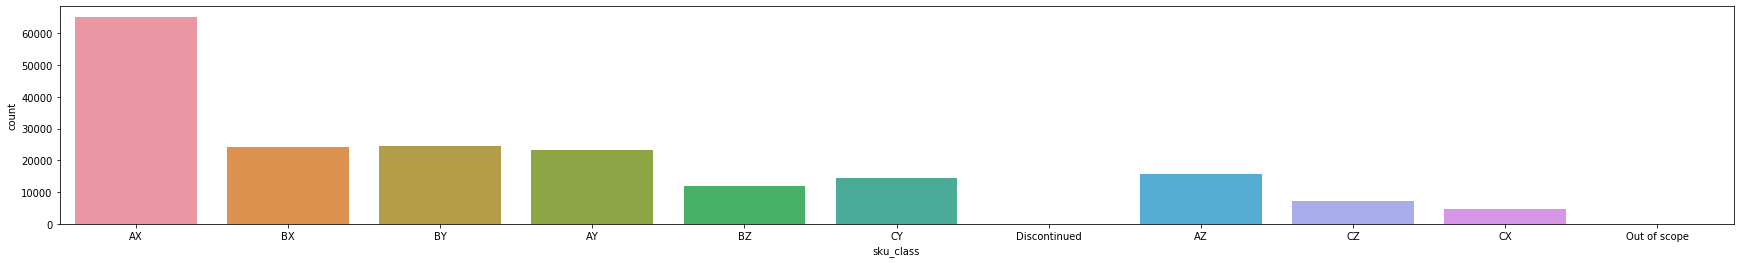

In [10]:
# Plotting SKU's per Sku Class
fig, (axis1) = plt.subplots(1,1,figsize=(30,4))
sns.countplot(x='sku_class', data=data, ax=axis1)

Investigating with the client, I can confirm that the `sku_class` depends on the `material`.

Since the spread between the `value/case` for each `sku_class` differs significantly, I decided to look into the different `sku_classes` seperately as well. (Focus in the overview on `sku_class AX` and `sku_class BX`.

In [14]:
data[data.sku_class == 'AX'].describe()

cases          value         f_day         adbno  \
count   65170.000000   65170.000000  65170.000000  65170.000000   
mean      246.830167    5332.538956    373.722725      4.307596   
std      1640.270398   12435.971735    167.273754      7.738499   
min         1.000000  -42538.120000      2.000000      1.000000   
25%         6.000000     490.582500    225.000000      2.000000   
50%        24.000000    1546.985000    432.000000      2.000000   
75%       109.000000    4840.740000    509.000000      4.000000   
max    152310.000000  456422.500000    562.000000    251.000000   

       service_level  est_lead_time        IS_HOL         month          year  \
count   65170.000000   65170.000000  65170.000000  65170.000000  65170.000000   
mean        0.945143      58.564002      0.029507      6.173239   2017.626945   
std         0.011514      24.143409      0.169225      3.605239      0.634305   
min         0.920000      16.000000      0.000000      1.000000   2016.000000   
25%         0.950000      36.000000      0.000000      3.000000   2017.000000   
50%         0.950000      68.000000      0.000000      6.000000   2018.000000   
75%         0.950000      71.000000      0.000000      9.000000   2018.000000   
max         0.990000     120.000000      1.000000     12.000000   2019.000000   

          log_cases  
count  65170.000000  
mean       3.341441  
std        1.999097  
min        0.000000  
25%        1.791759  
50%        3.178054  
75%        4.691348  
max       11.933670

In [15]:
data[data.sku_class == 'BX'].describe()

cases          value         f_day         adbno  service_level  \
count  24352.000000   24352.000000  24352.000000  24352.000000   24352.000000   
mean      55.222158    1263.799179    272.274351      4.500657       0.948617   
std      270.518971    2333.201917    105.279678      9.396263       0.008248   
min        1.000000   -1700.620000      2.000000      2.000000       0.850000   
25%        4.000000     299.430000    198.000000      2.000000       0.950000   
50%       10.000000     646.325000    284.000000      3.000000       0.950000   
75%       28.000000    1349.652500    360.000000      4.000000       0.950000   
max    14624.000000  116040.000000    452.000000    330.000000       0.990000   

       est_lead_time        IS_HOL         month          year     log_cases  
count   24352.000000  24352.000000  24352.000000  24352.000000  24352.000000  
mean       65.403088      0.030059      6.175140   2017.622331      2.432617  
std        14.631795      0.170754      3.577084      0.630738      1.579716  
min        16.000000      0.000000      1.000000   2016.000000      0.000000  
25%        69.000000      0.000000      3.000000   2017.000000      1.386294  
50%        71.000000      0.000000      6.000000   2018.000000      2.302585  
75%        71.000000      0.000000      9.000000   2018.000000      3.332205  
max       120.000000      1.000000     12.000000   2019.000000      9.590419

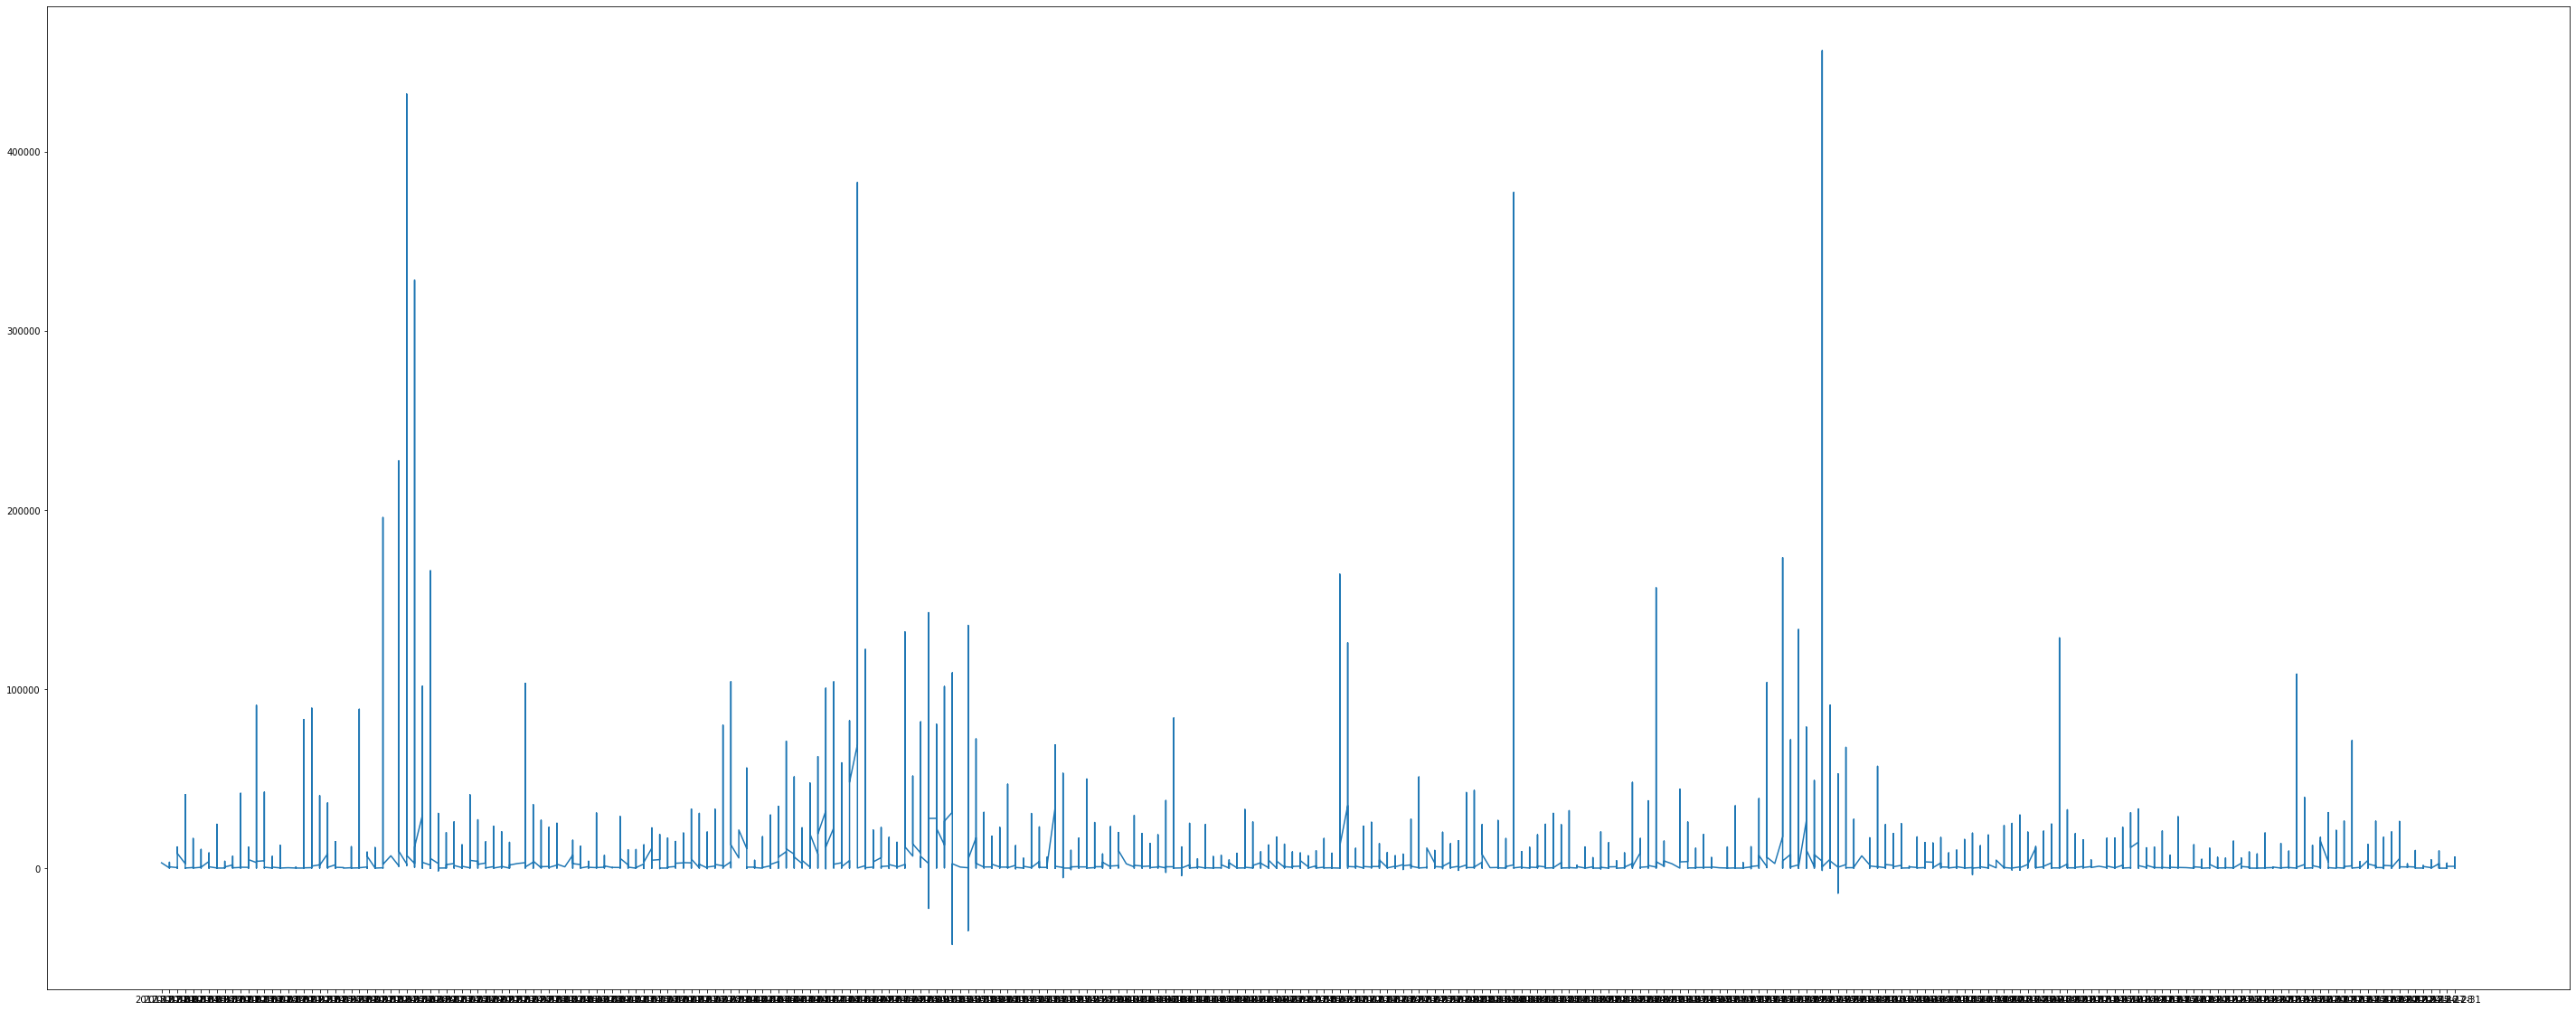

In [20]:
plt.figure(figsize=(50,20))
plt.plot(data[data.year == 2018].sort_values(by='sales_date').sales_date, data[data.year == 2018].value)
plt.show()

The graph is very fluctuating as can be seen from the upward spikes. I will use `weekyear` in order to get a better overview. Additionally, I will ignore all entries in `value` and `cases`, which are non-positive. For this quick check, I will create a temporary pandas dataframe.

In [21]:
data.sales_date.dtype

dtype('O')

In [3]:
data.sales_date = pd.to_datetime(data.sales_date)

In [4]:
data['weekyear'] = data.sales_date.dt.week

In [5]:
selected_data.sales_date = pd.to_datetime(selected_data.sales_date)
selected_data['weekyear'] = selected_data.sales_date.dt.week

NameError: name 'selected_data' is not defined

In [24]:
# check that it works
data[['weekyear', 'sales_date']].head()

weekyear sales_date
0         1 2017-01-04
1         1 2017-01-05
2         2 2017-01-10
3         2 2017-01-11
4         2 2017-01-12

In [15]:
# check that it works
selected_data[['weekyear', 'sales_date']].head()

weekyear sales_date
0         1 2017-01-04
1         1 2017-01-05
2         2 2017-01-10
3         2 2017-01-11
4         2 2017-01-12

In [6]:
df = data[['weekyear', 'sku_class', 'value', 'cases', 'year']].groupby(['year', 'weekyear', 'sku_class'], as_index=False).sum()

In [43]:
df.head()

year  weekyear sku_class     value  cases
0  2016        34        BX      0.00      1
1  2016        34        BY      0.00      3
2  2016        34        CY      0.00      1
3  2016        49        CY   4884.80     32
4  2016        49        CZ  59524.92   1659

In [7]:
df = df[(df.value >= 1) & (df.cases >= 1)]

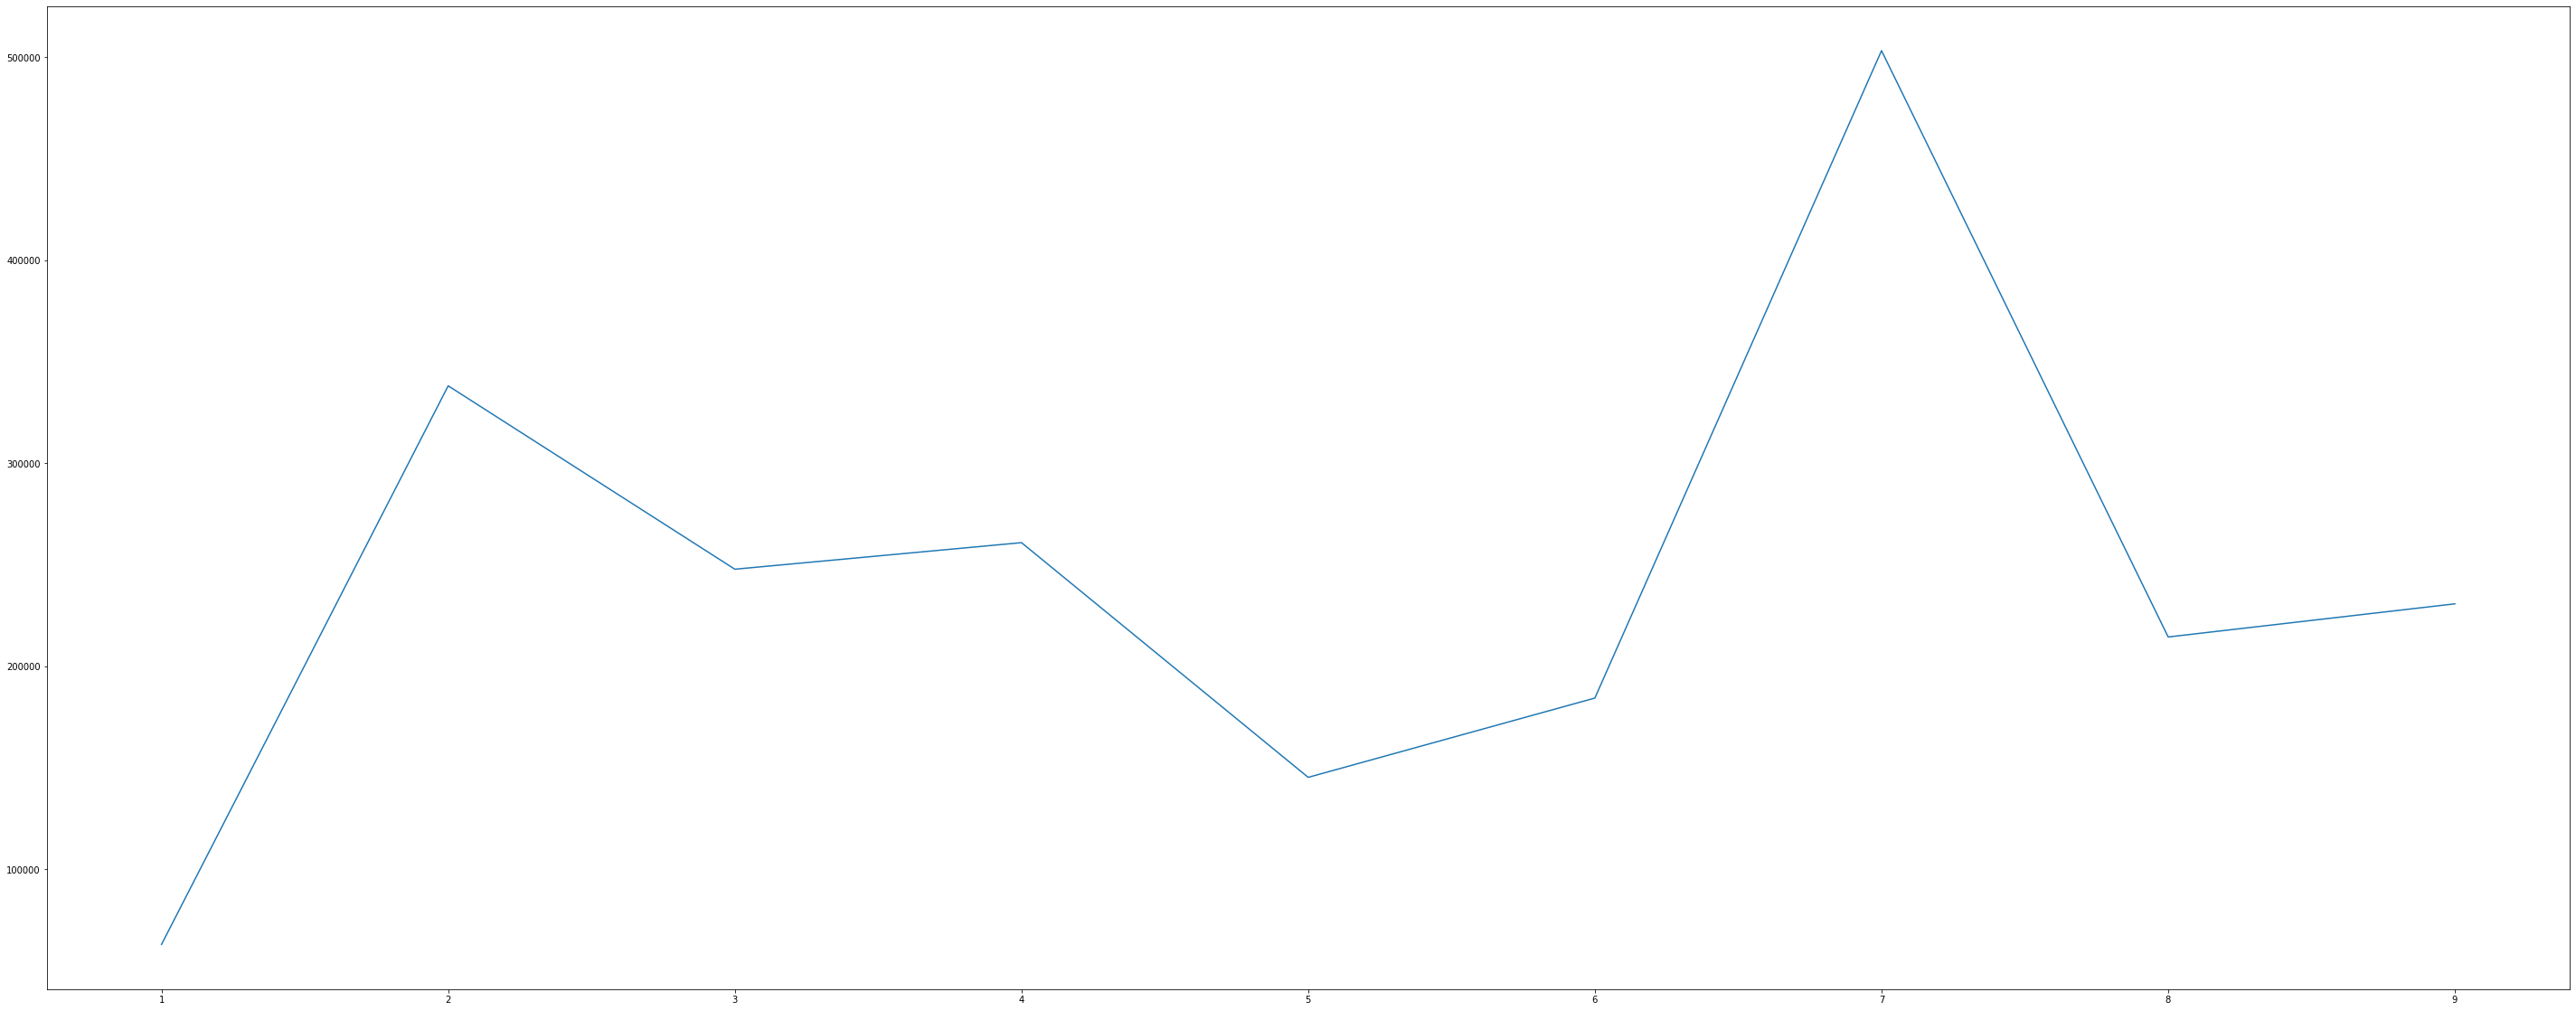

In [31]:
plt.figure(figsize=(50,20))
plt.plot(df[df.year == 2019].weekyear, df[df.year == 2019].cases)
plt.show()

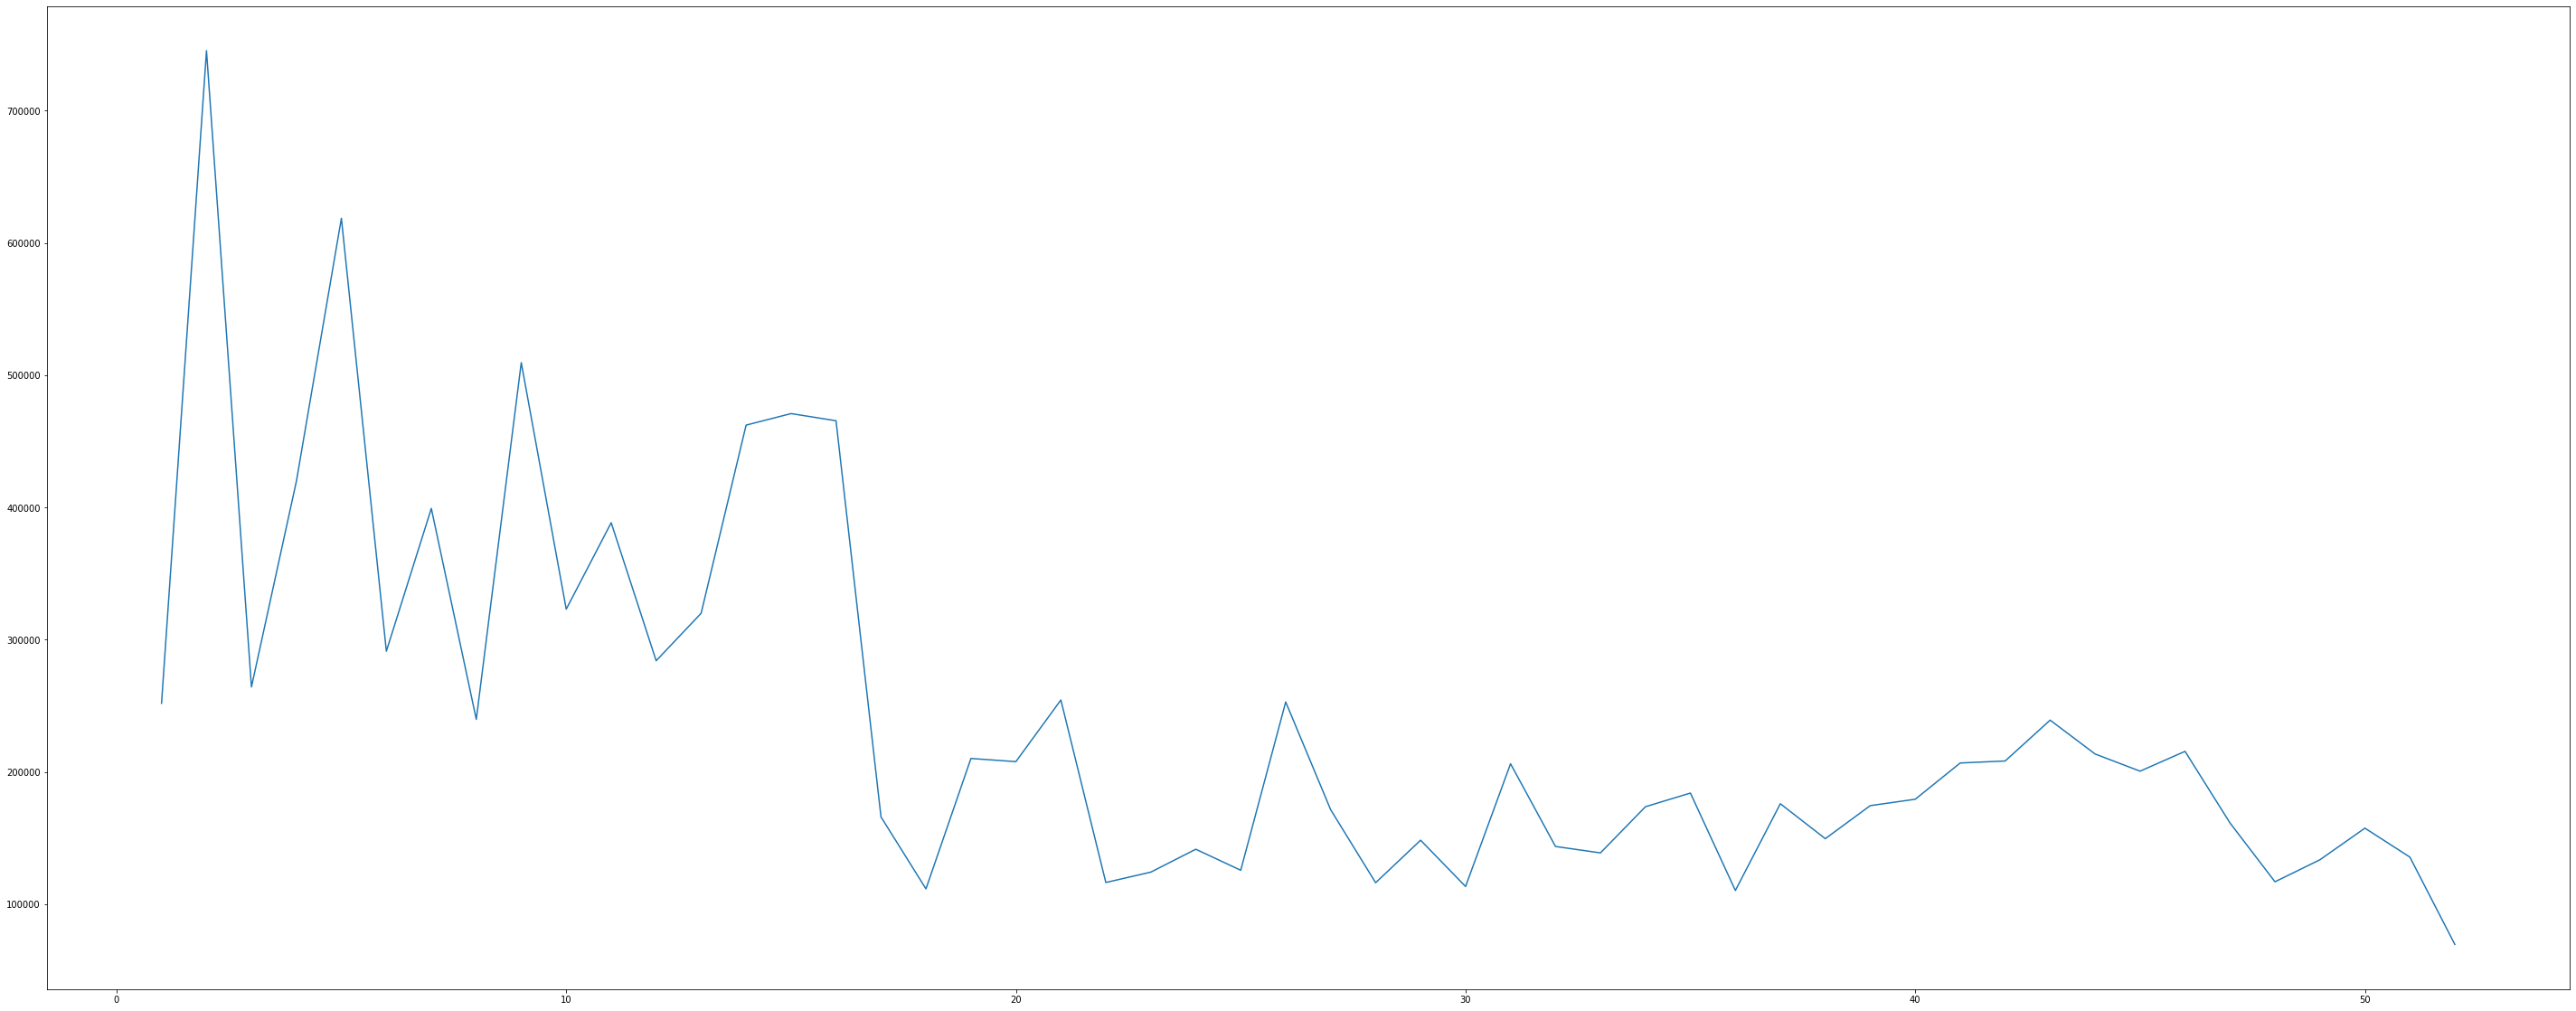

In [28]:
plt.figure(figsize=(50,20))
plt.plot(df[df.year == 2018].weekyear, df[df.year == 2018].cases)
plt.show()

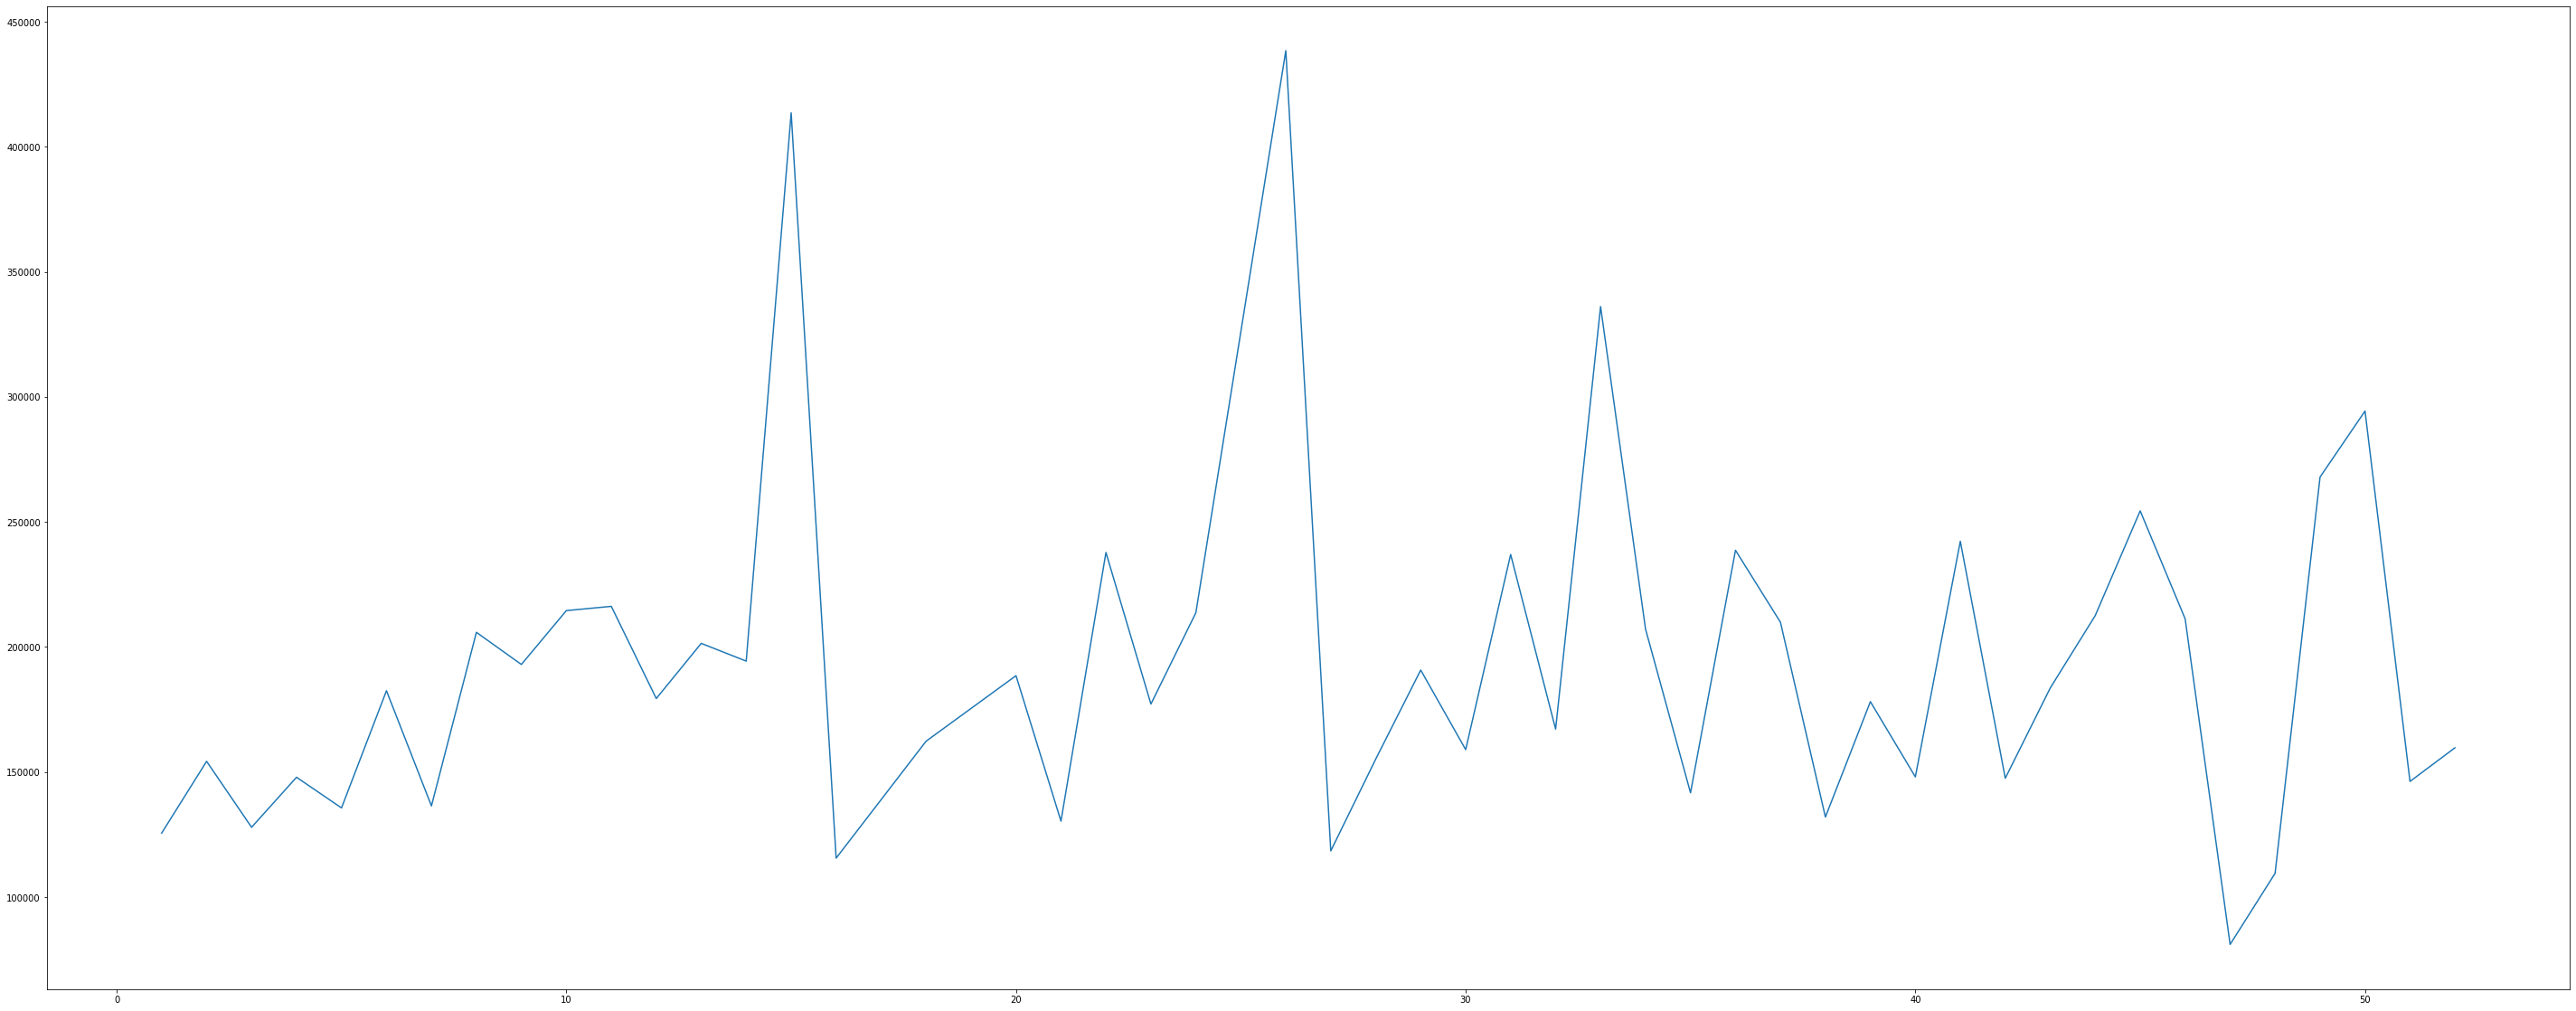

In [29]:
plt.figure(figsize=(50,20))
plt.plot(df[df.year == 2017].weekyear, df[df.year == 2017].cases)
plt.show()

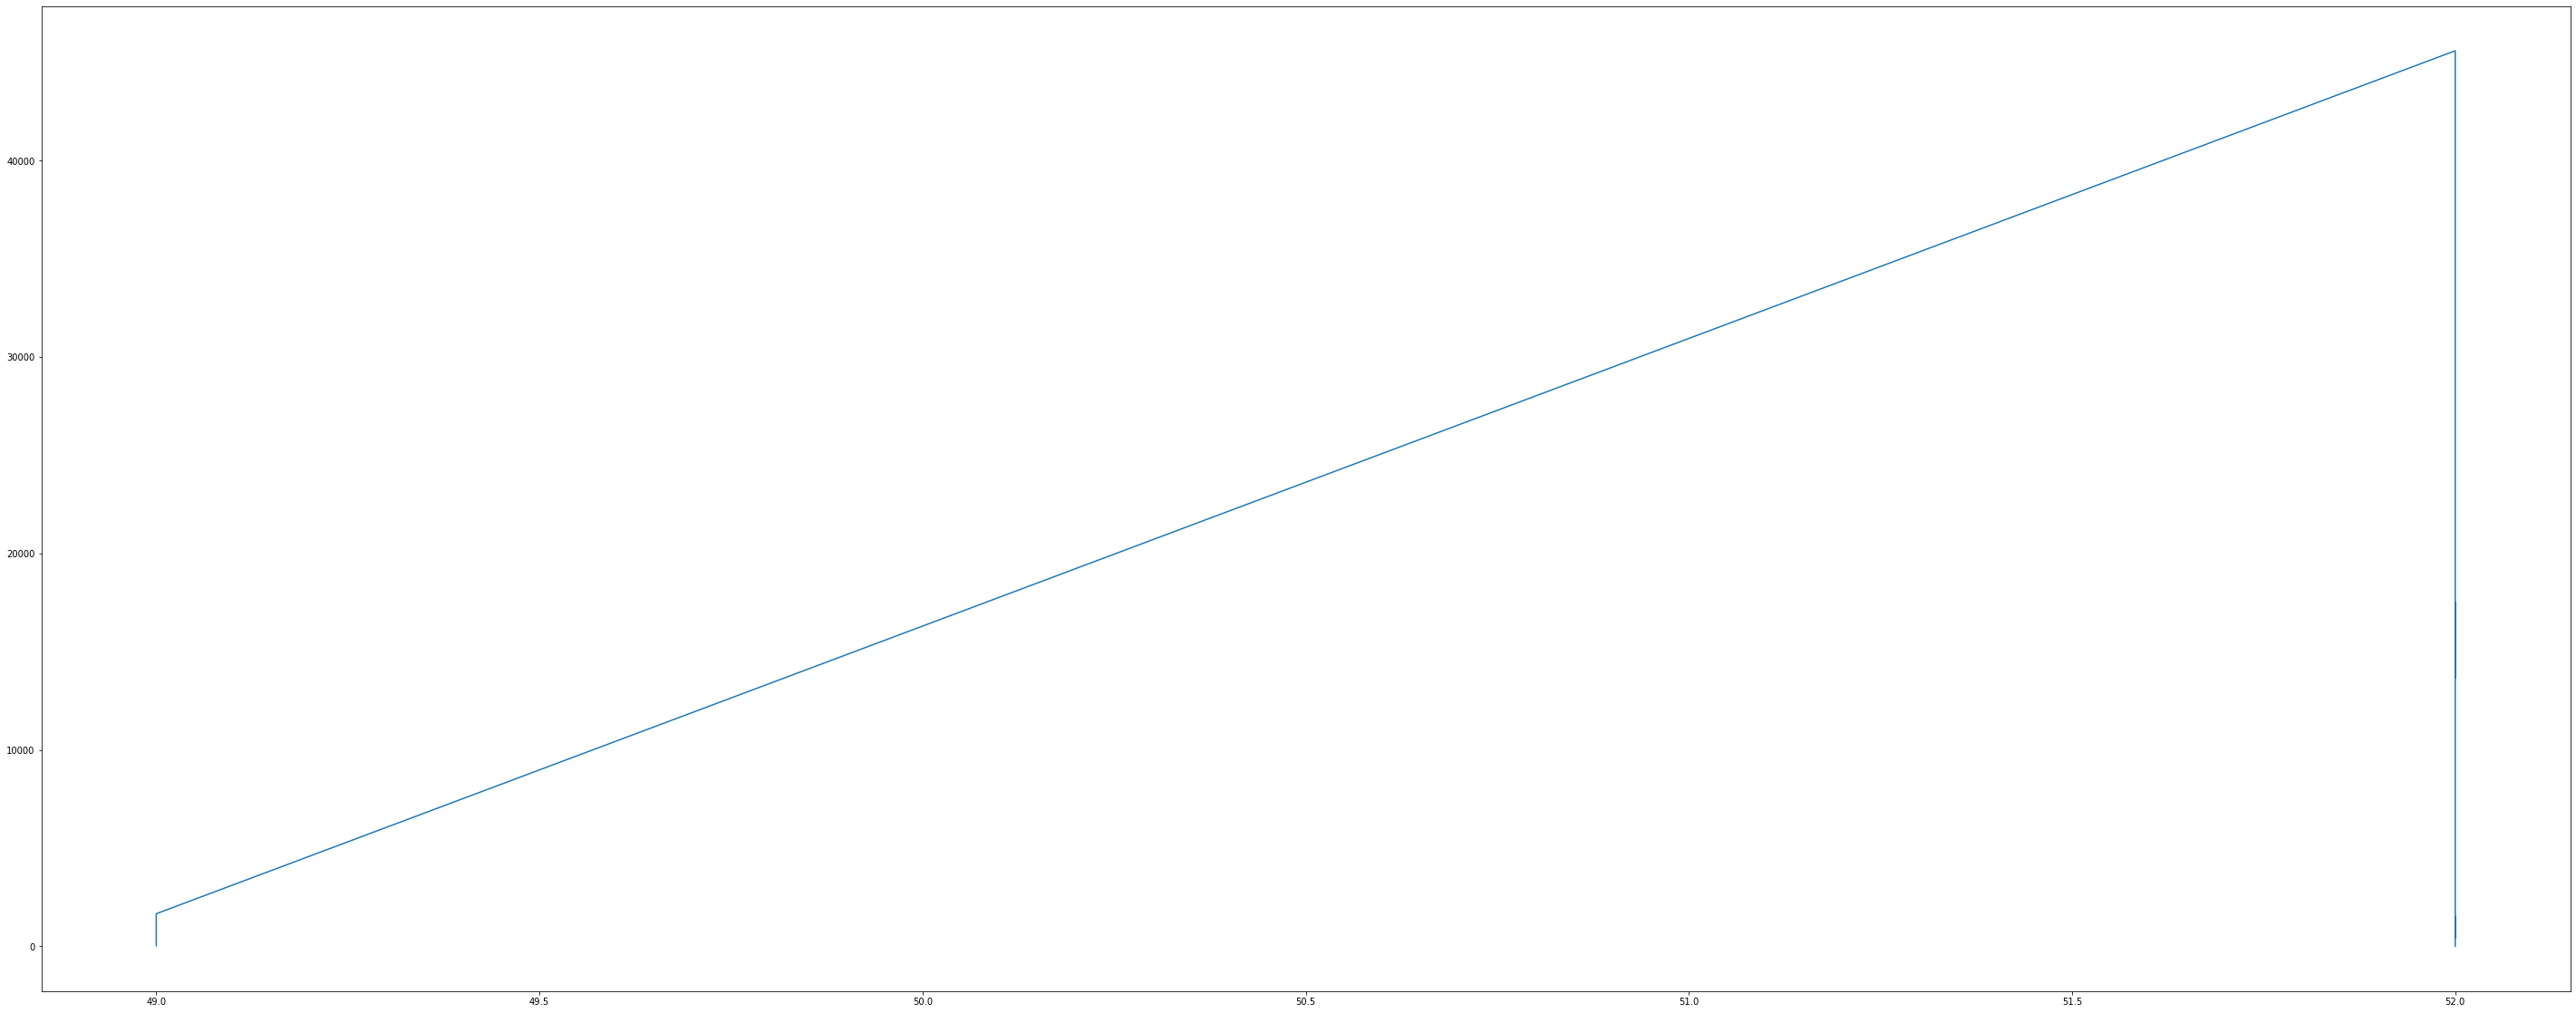

In [45]:
plt.figure(figsize=(50,20))
plt.plot(df[df.year == 2016].weekyear, df[df.year == 2016].cases)
plt.show()

According to the graphs above mapping the `weekyear` on the x-axis and the `cases` on the y-axis we can still see fluctuations. Being in contact with the customer these fluctuations are reasonable, however, primarily caused due to issues they were facing with the LSPs. Since LSPs did not pick up on time, followed by weekends, holidays etc, they picked up cumulative cases. Besides that the industry also faces some general (however not as significant) varying demand amounts per month.

Furthermore, we can see that in the year of 2016 we have a linear growth. Verifying with the client this is due to estimation. Hence, I will ignore data from the year of 2016 in the further progress. (Migration of the system --> ignore 2016)

Further along I looked at the developments of the sales data for each `sku_class` to see whether there are any specificy drivers.

In [8]:
def sku_class_map(sku_class, year):
    plt.figure(figsize=(50,20))
    plt.plot(df[(df.year == year) & (df.sku_class == sku_class)].weekyear, df[(df.year == year) & (df.sku_class == sku_class)].value)
    plt.show()

In [48]:
sku_classes = ['AX', 'BY', 'BX', 'AY', 'AZ', 'CY', 'BZ', 'CZ', 'CX']

This is the graph for sku_class AX in the year of 2018


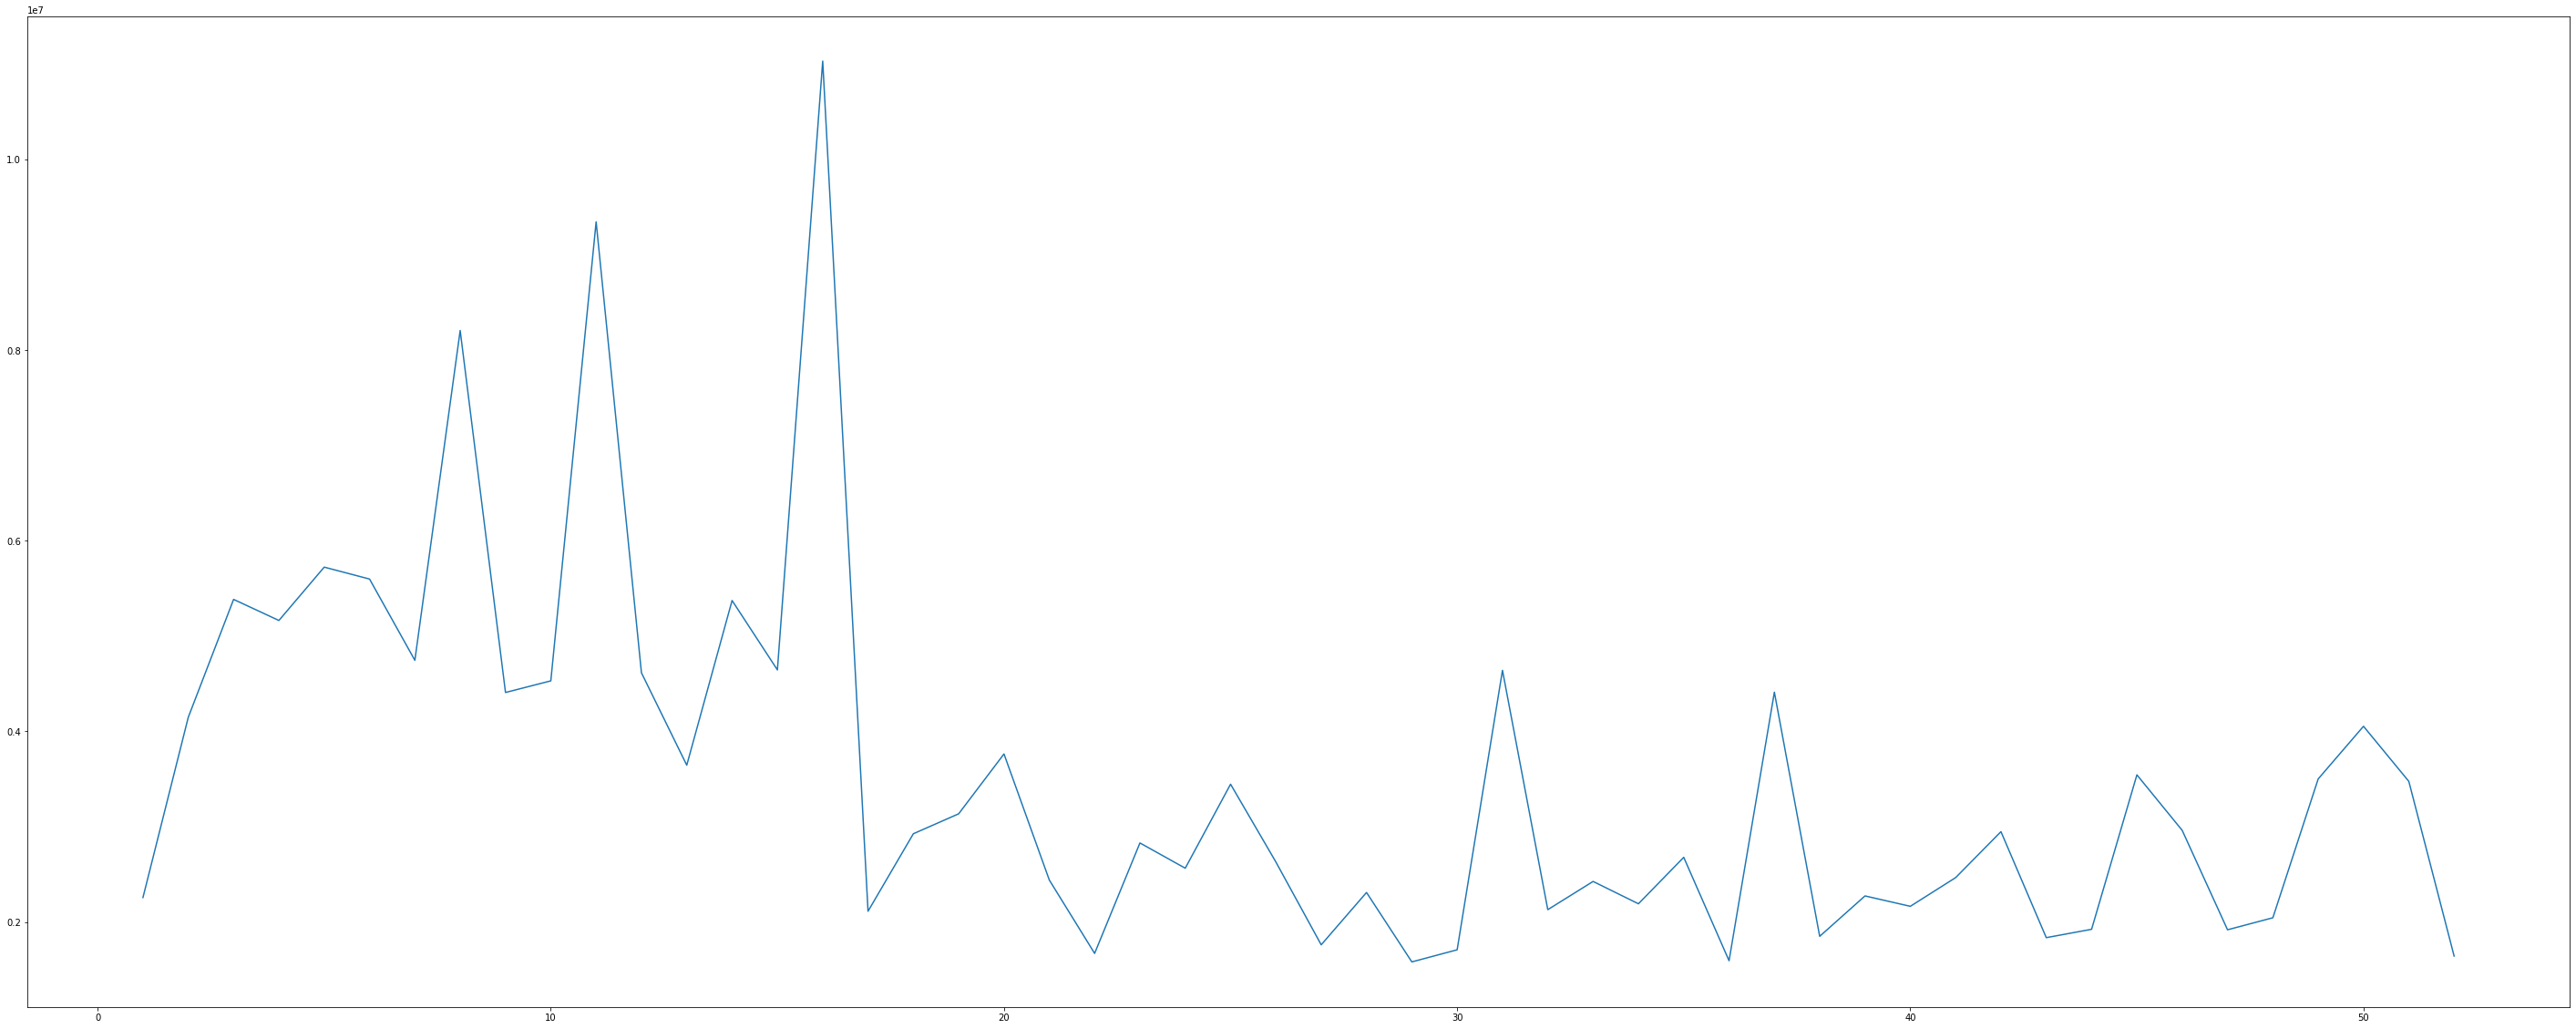

This is the graph for sku_class BY in the year of 2018


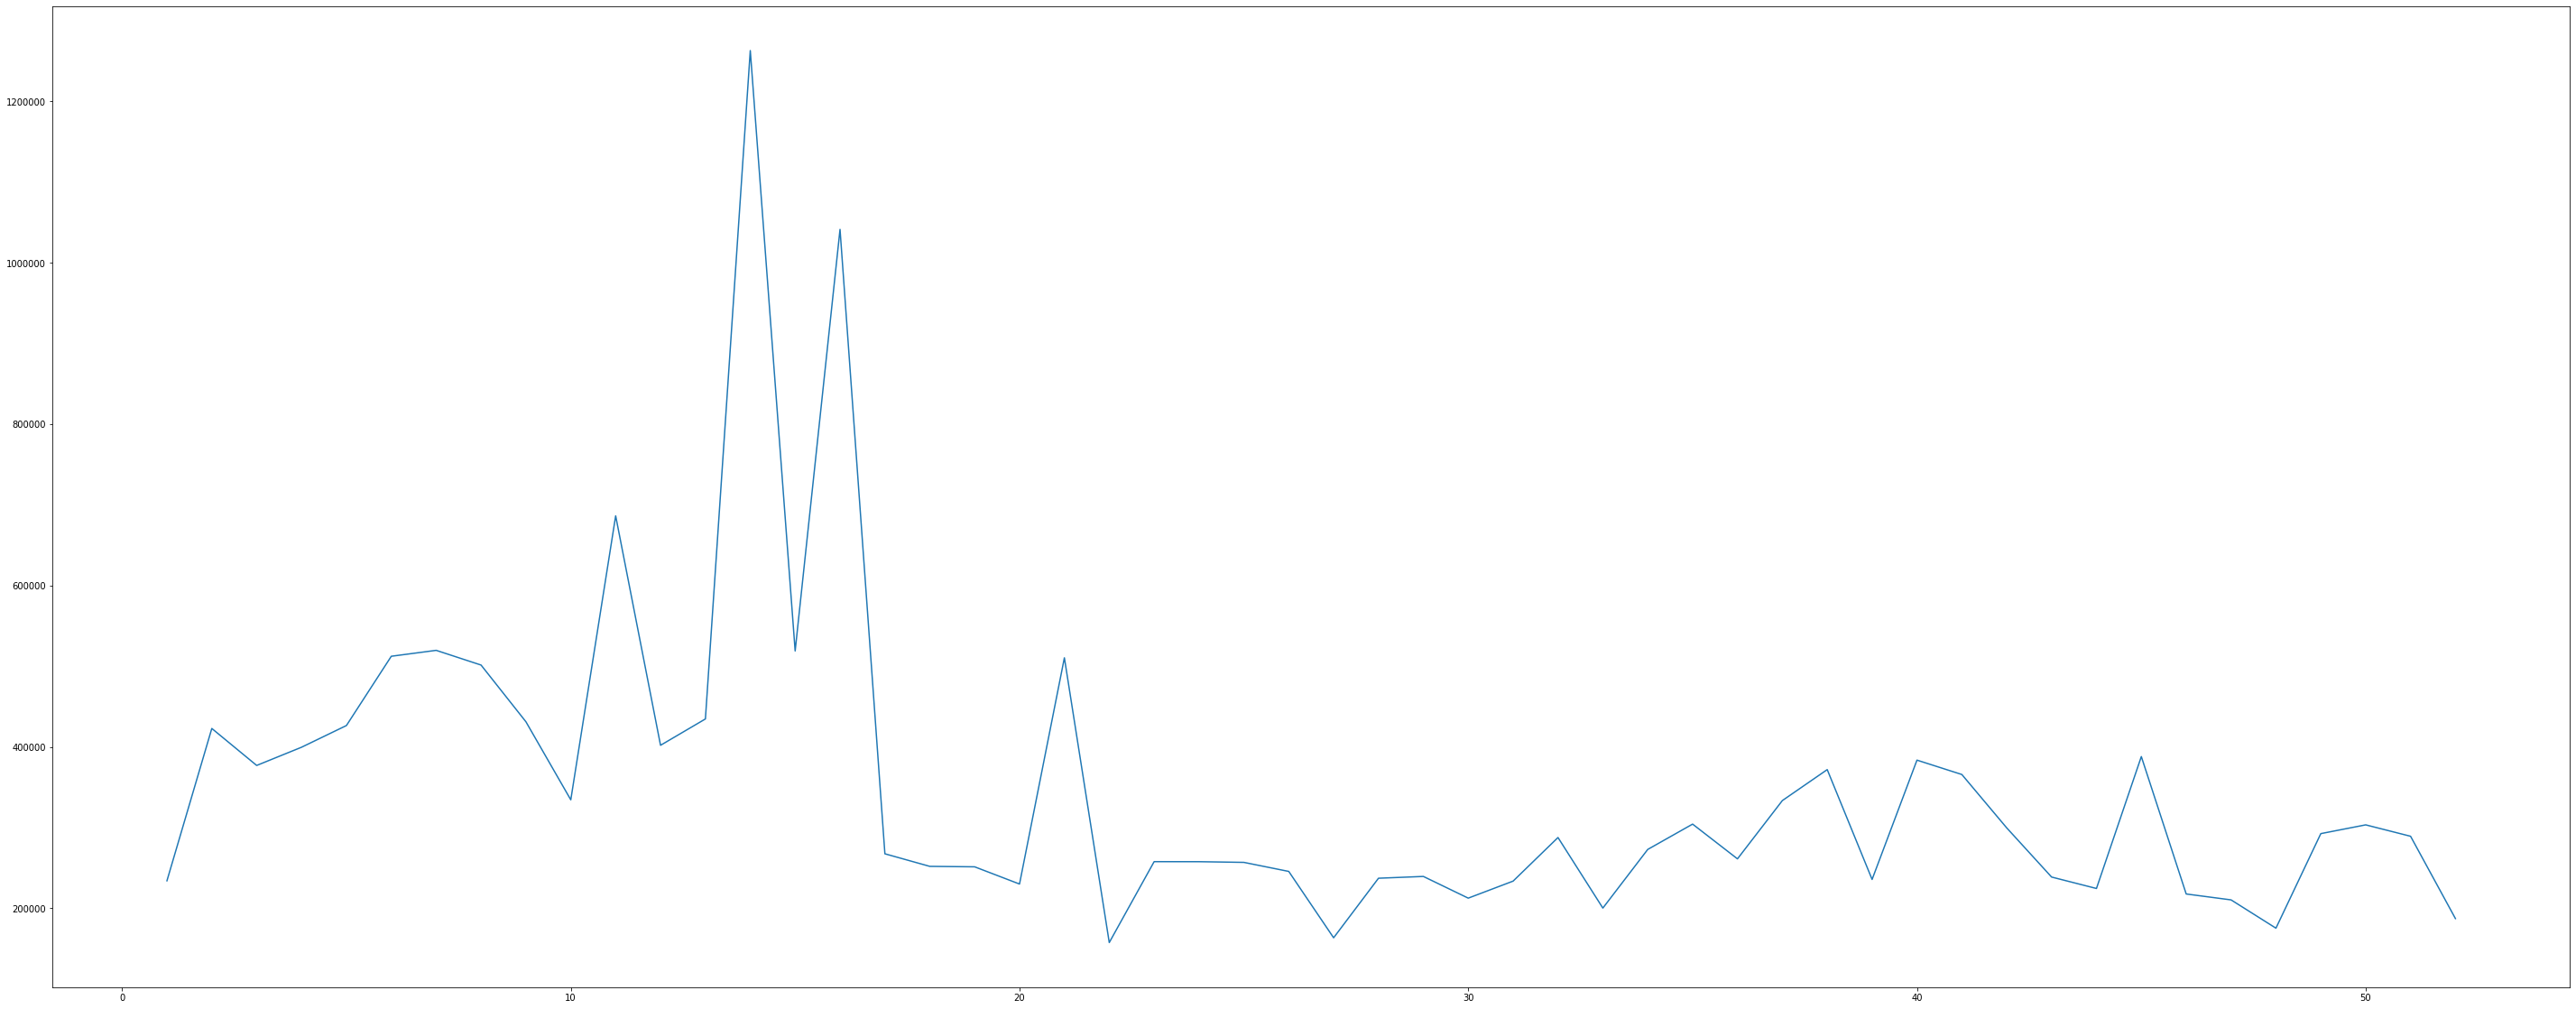

This is the graph for sku_class BX in the year of 2018


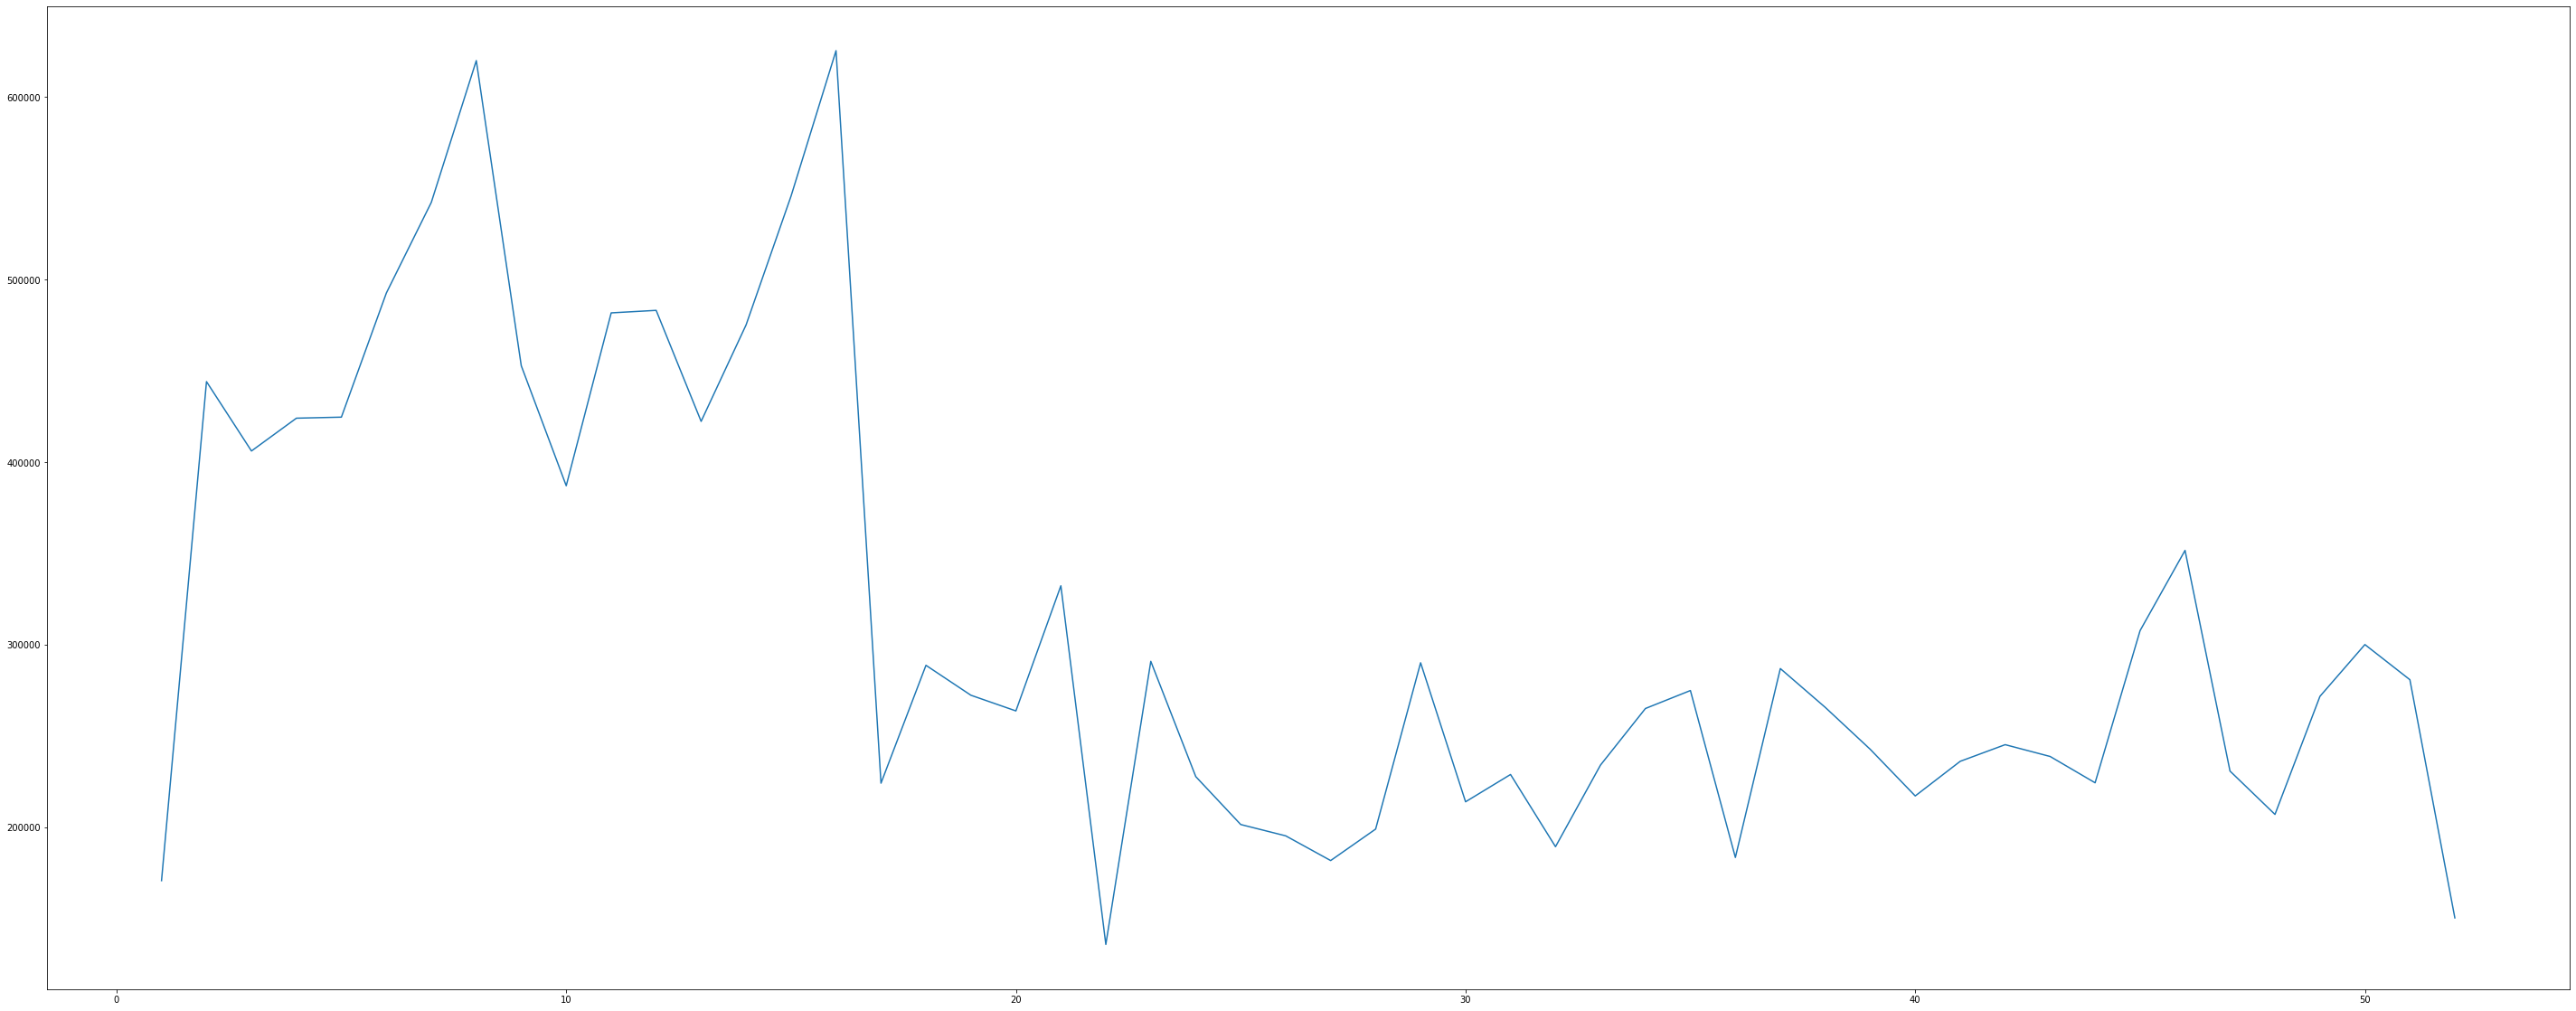

This is the graph for sku_class AY in the year of 2018


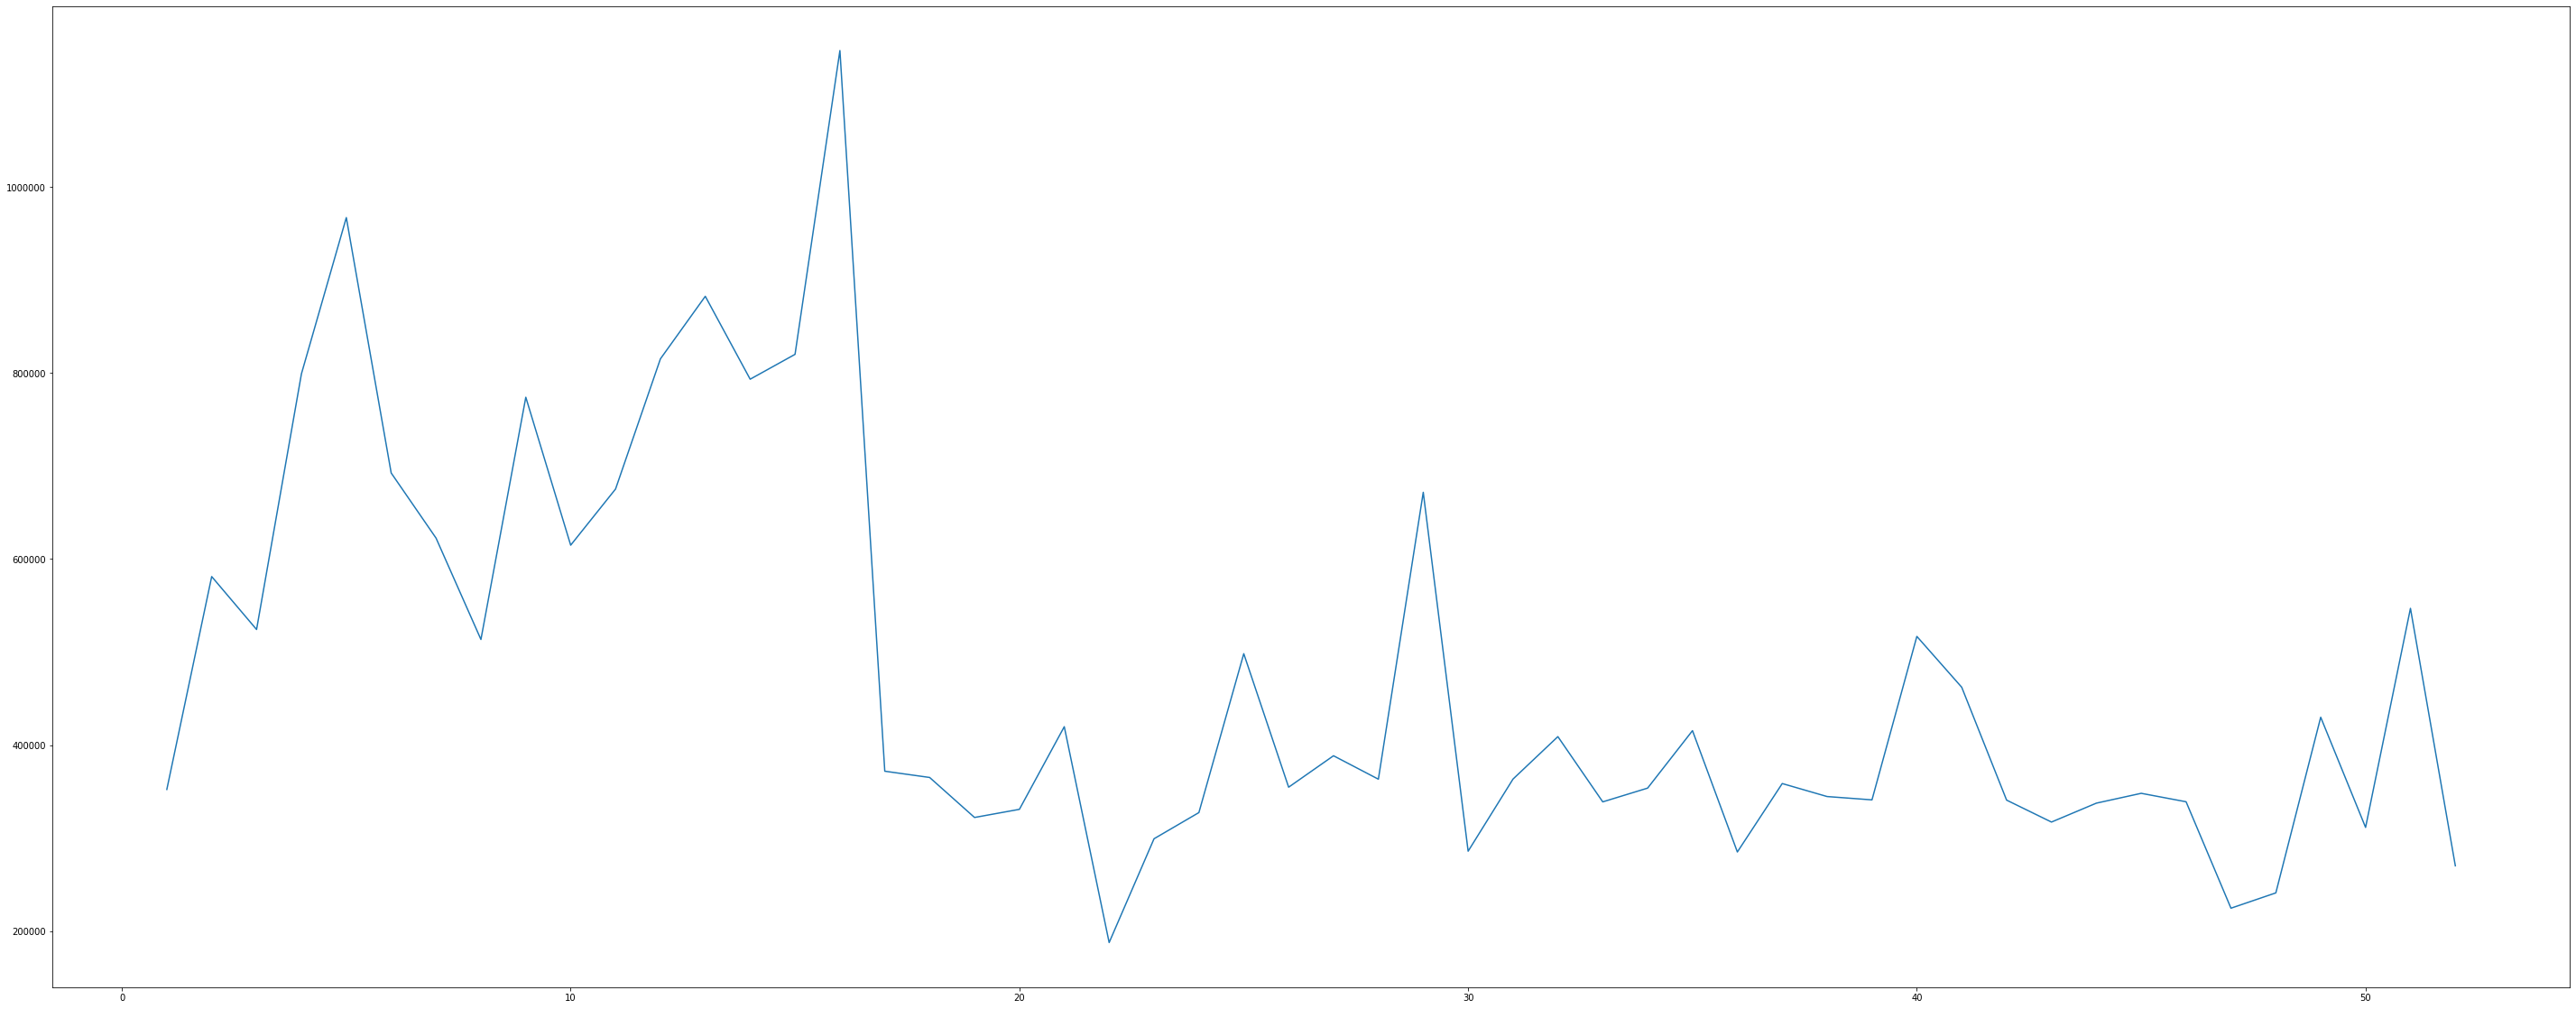

This is the graph for sku_class AZ in the year of 2018


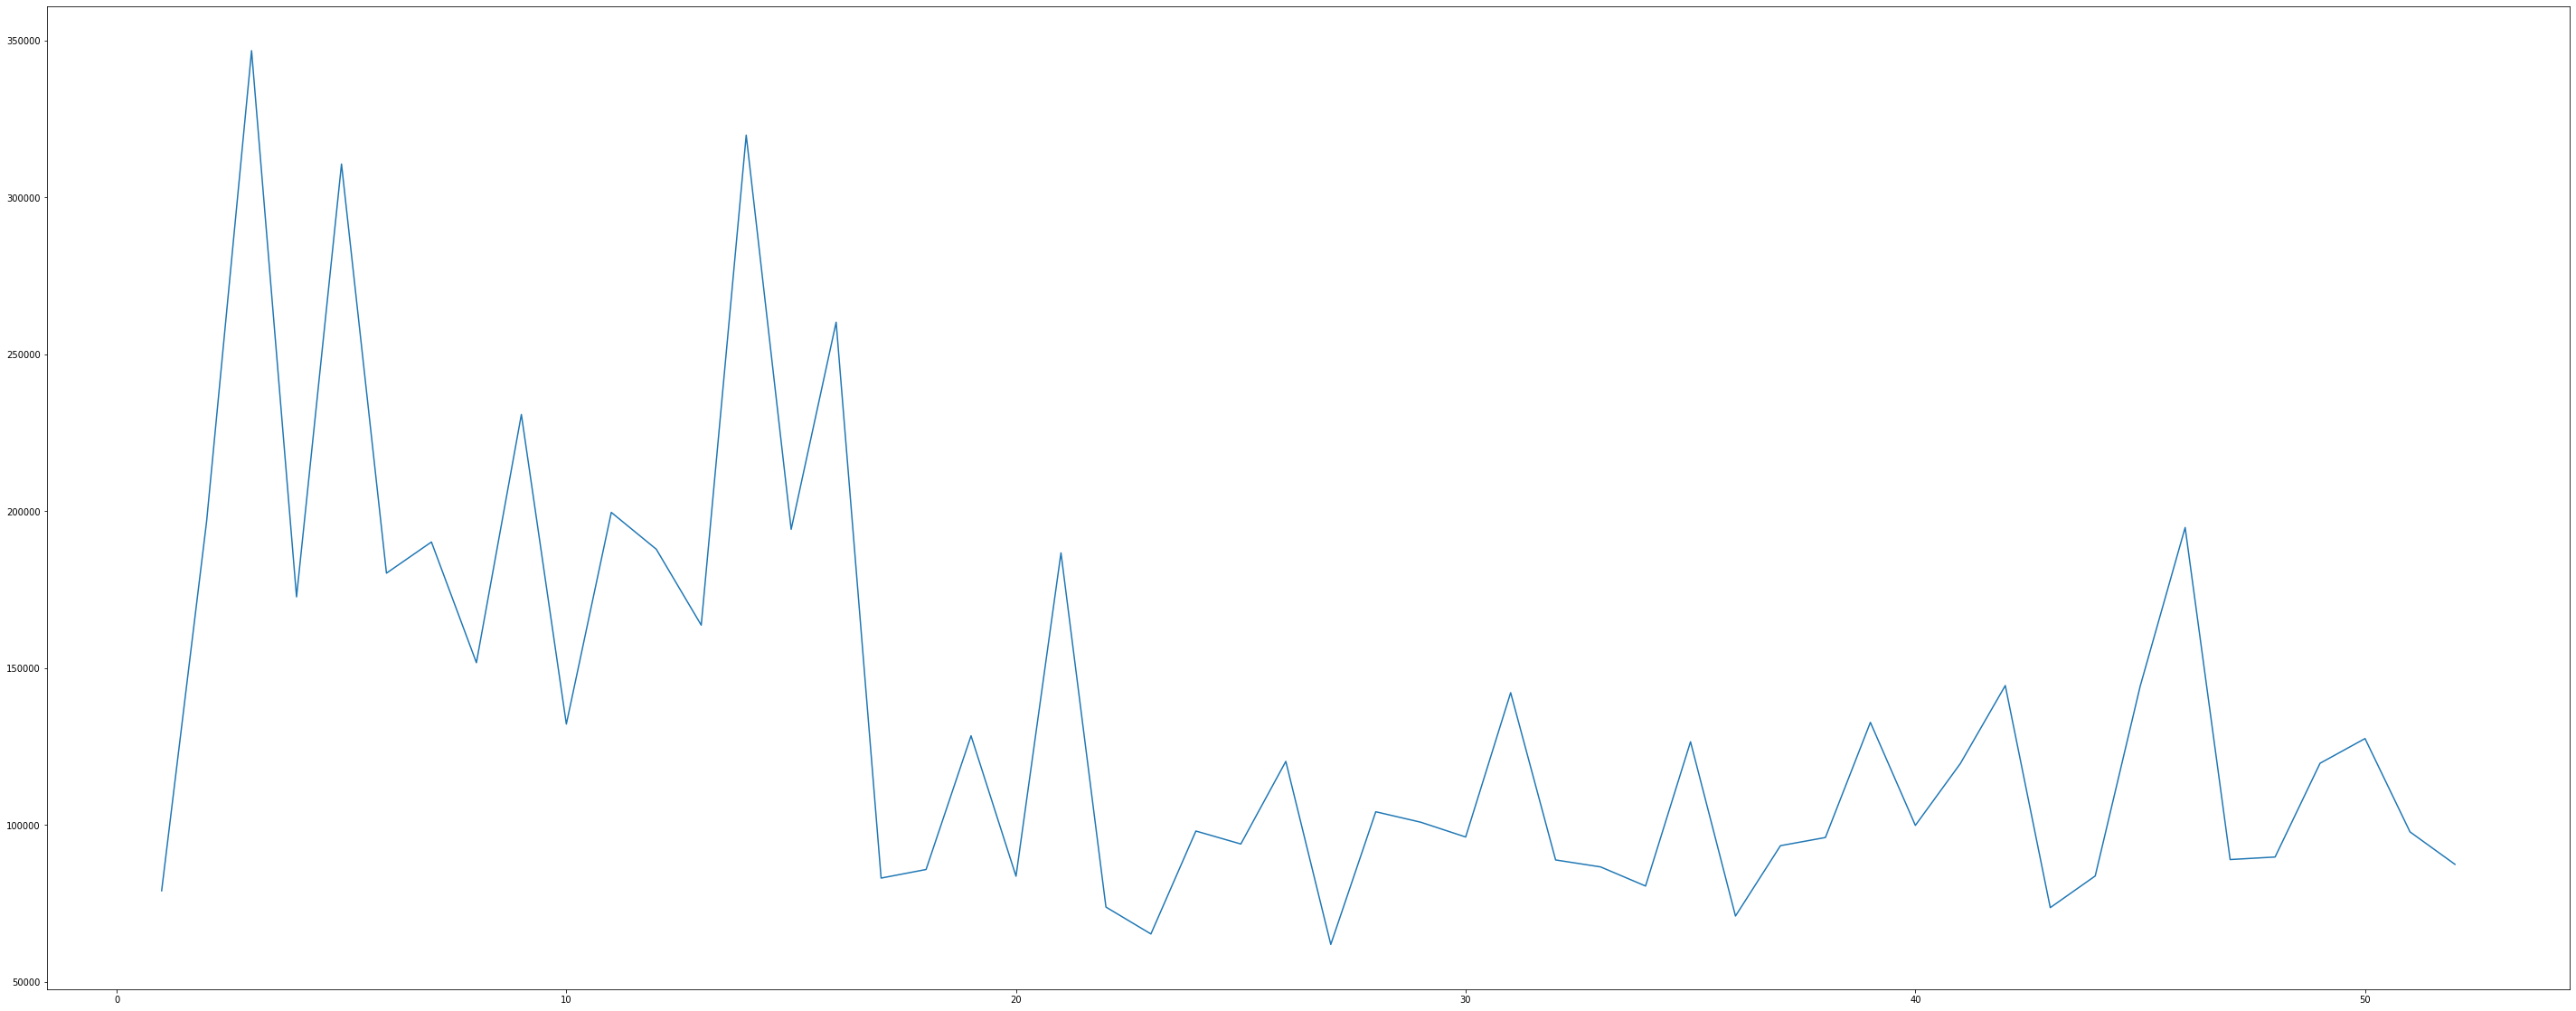

This is the graph for sku_class CY in the year of 2018


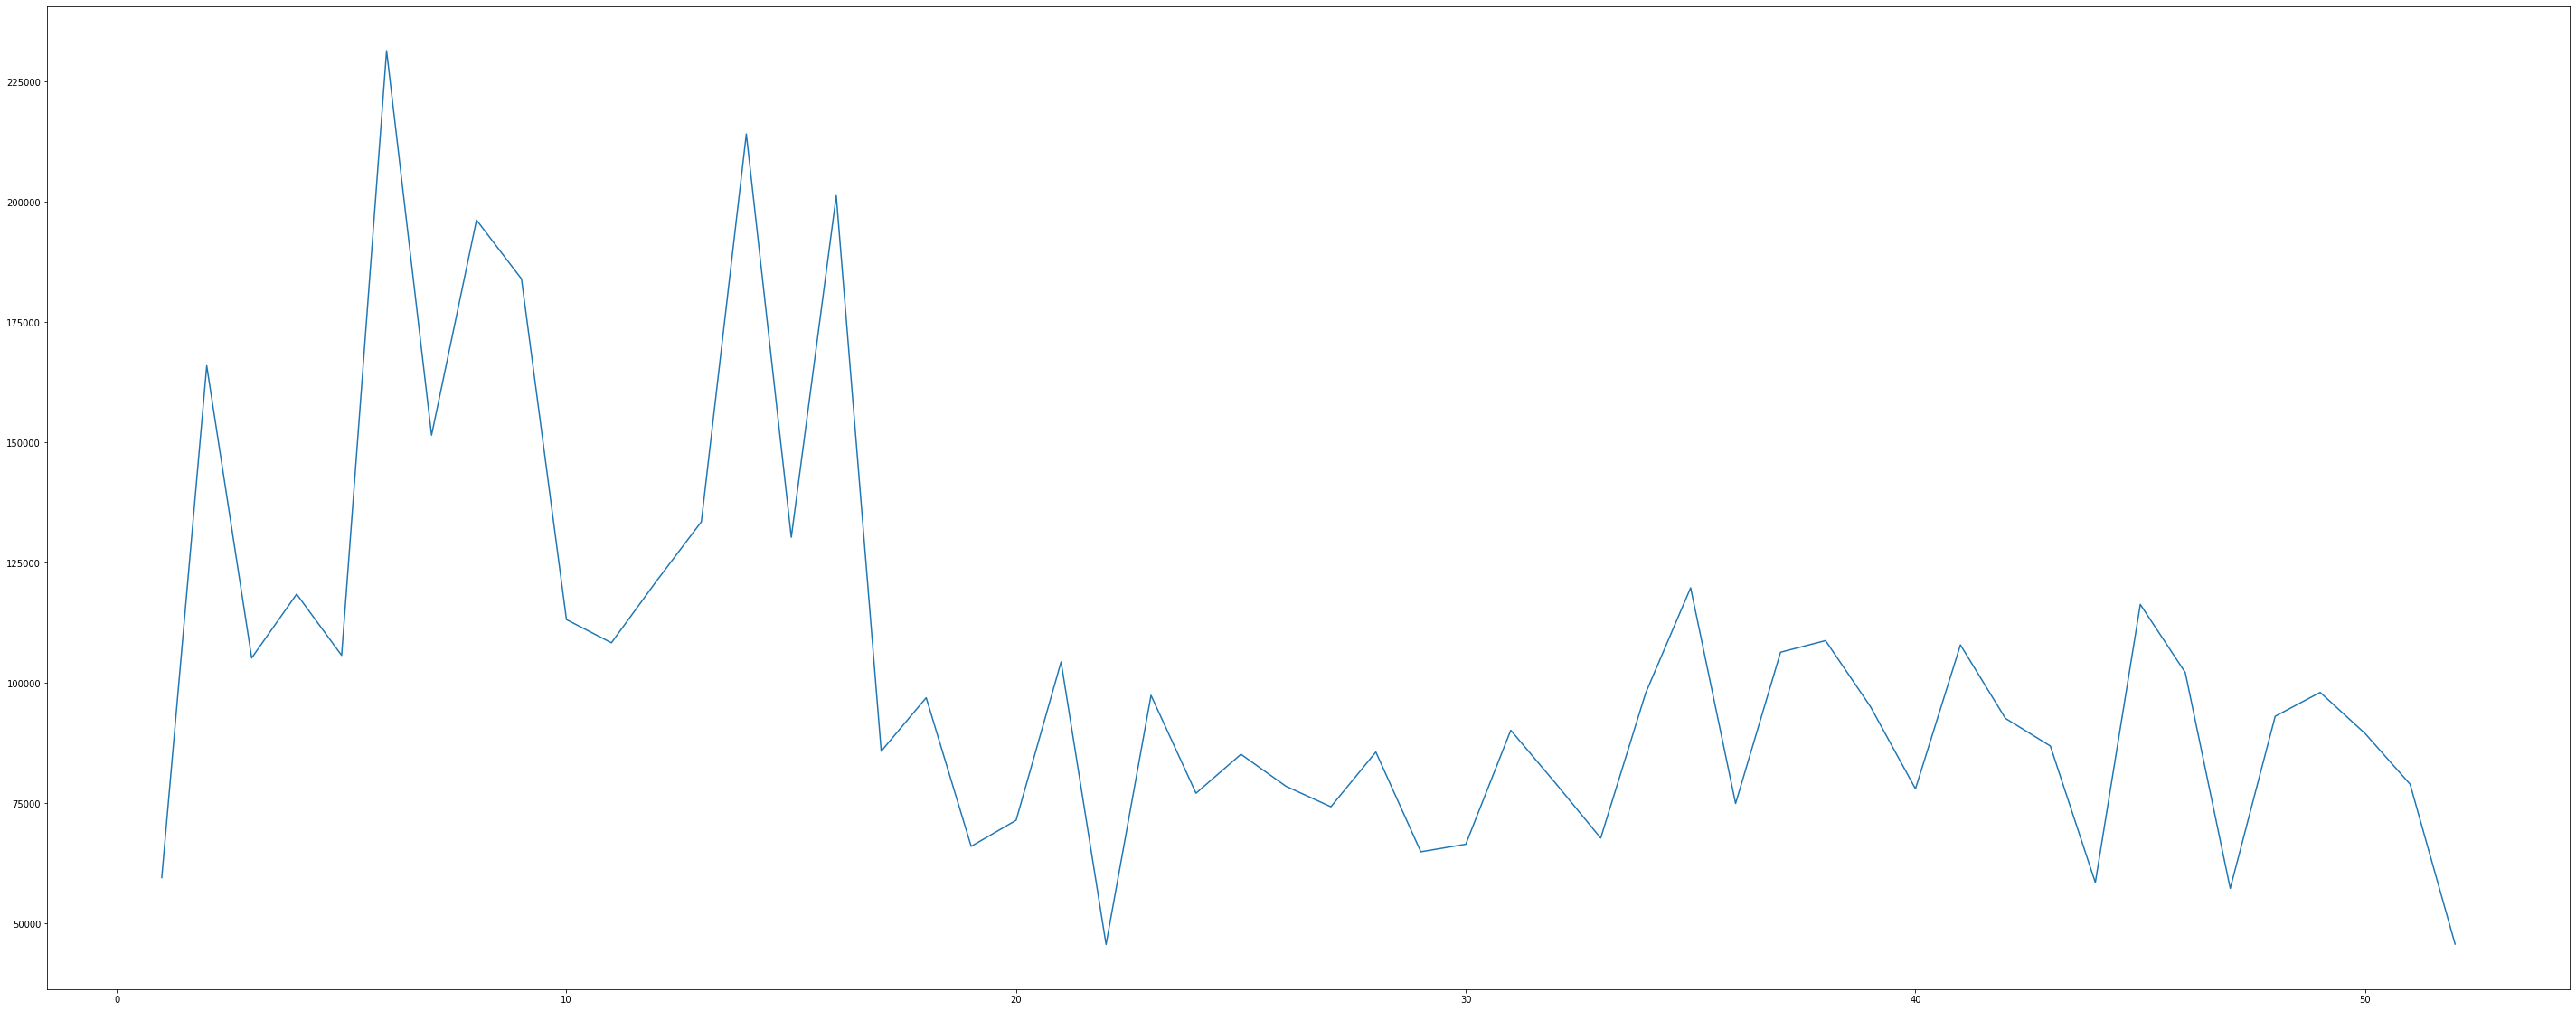

This is the graph for sku_class BZ in the year of 2018


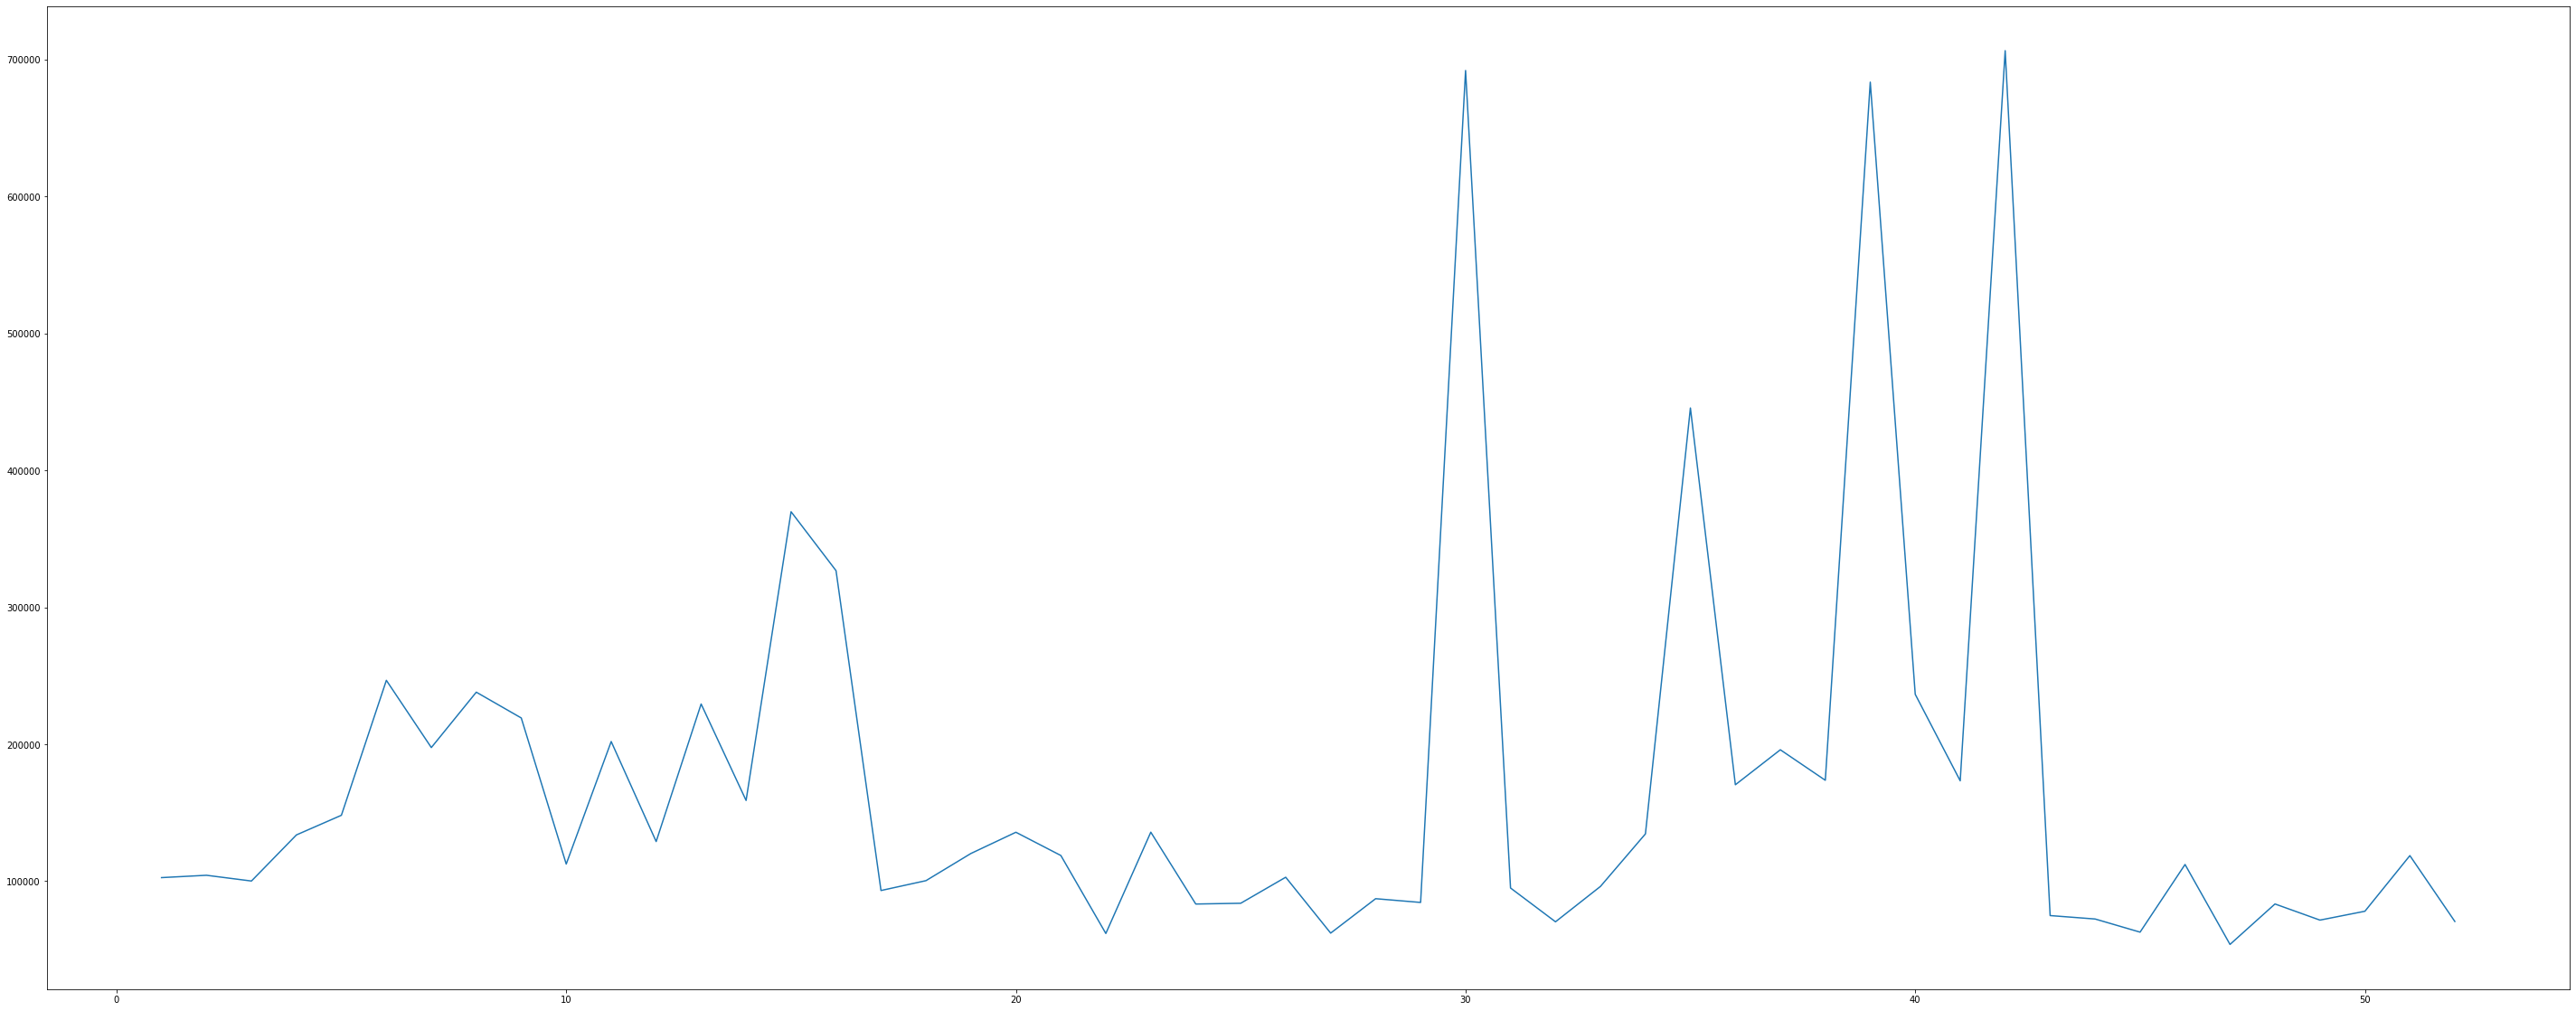

This is the graph for sku_class CZ in the year of 2018


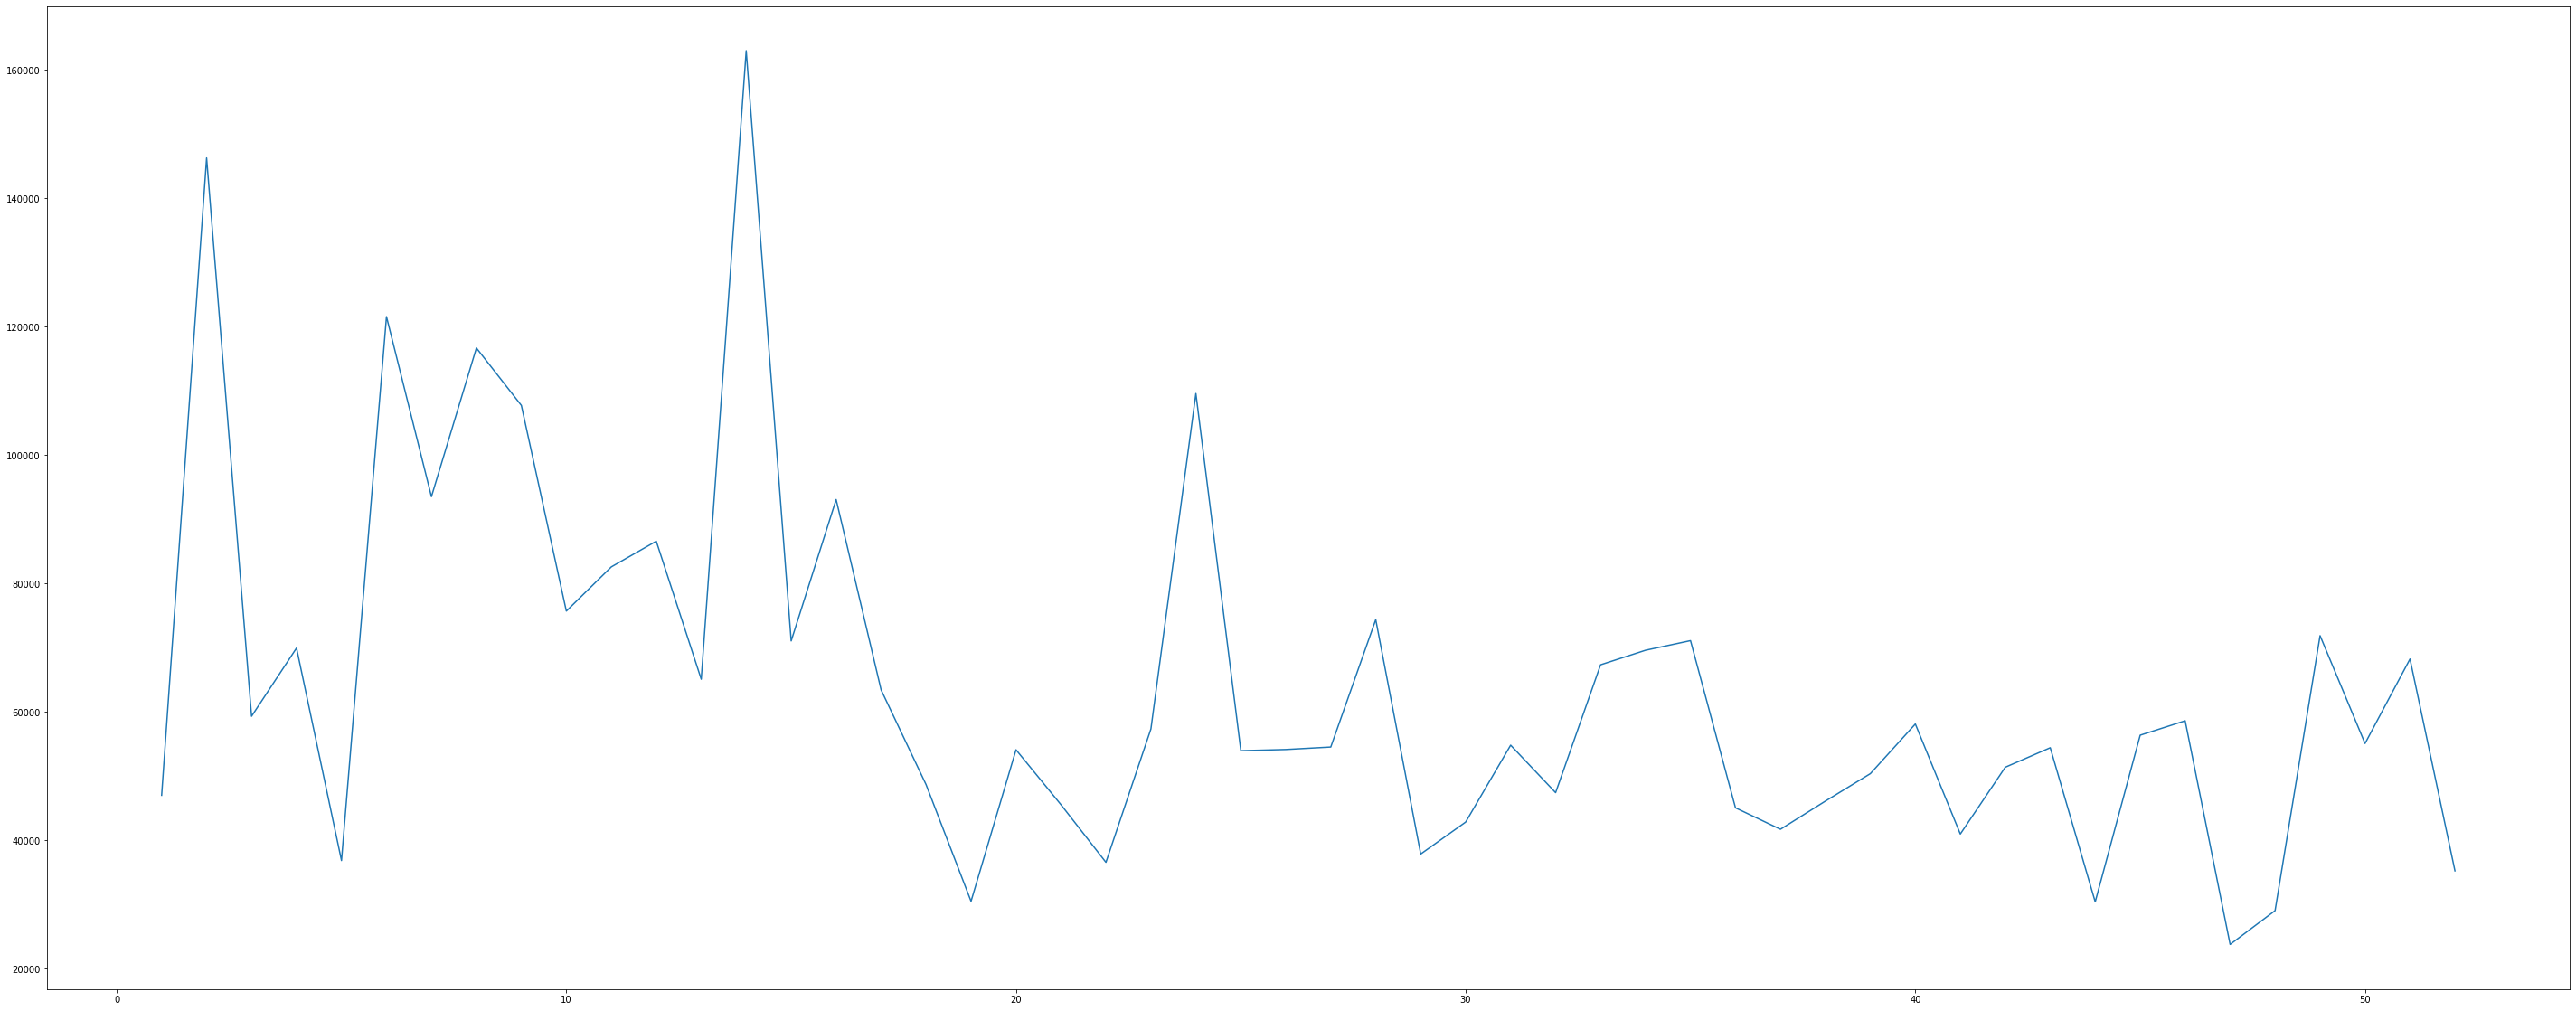

This is the graph for sku_class CX in the year of 2018


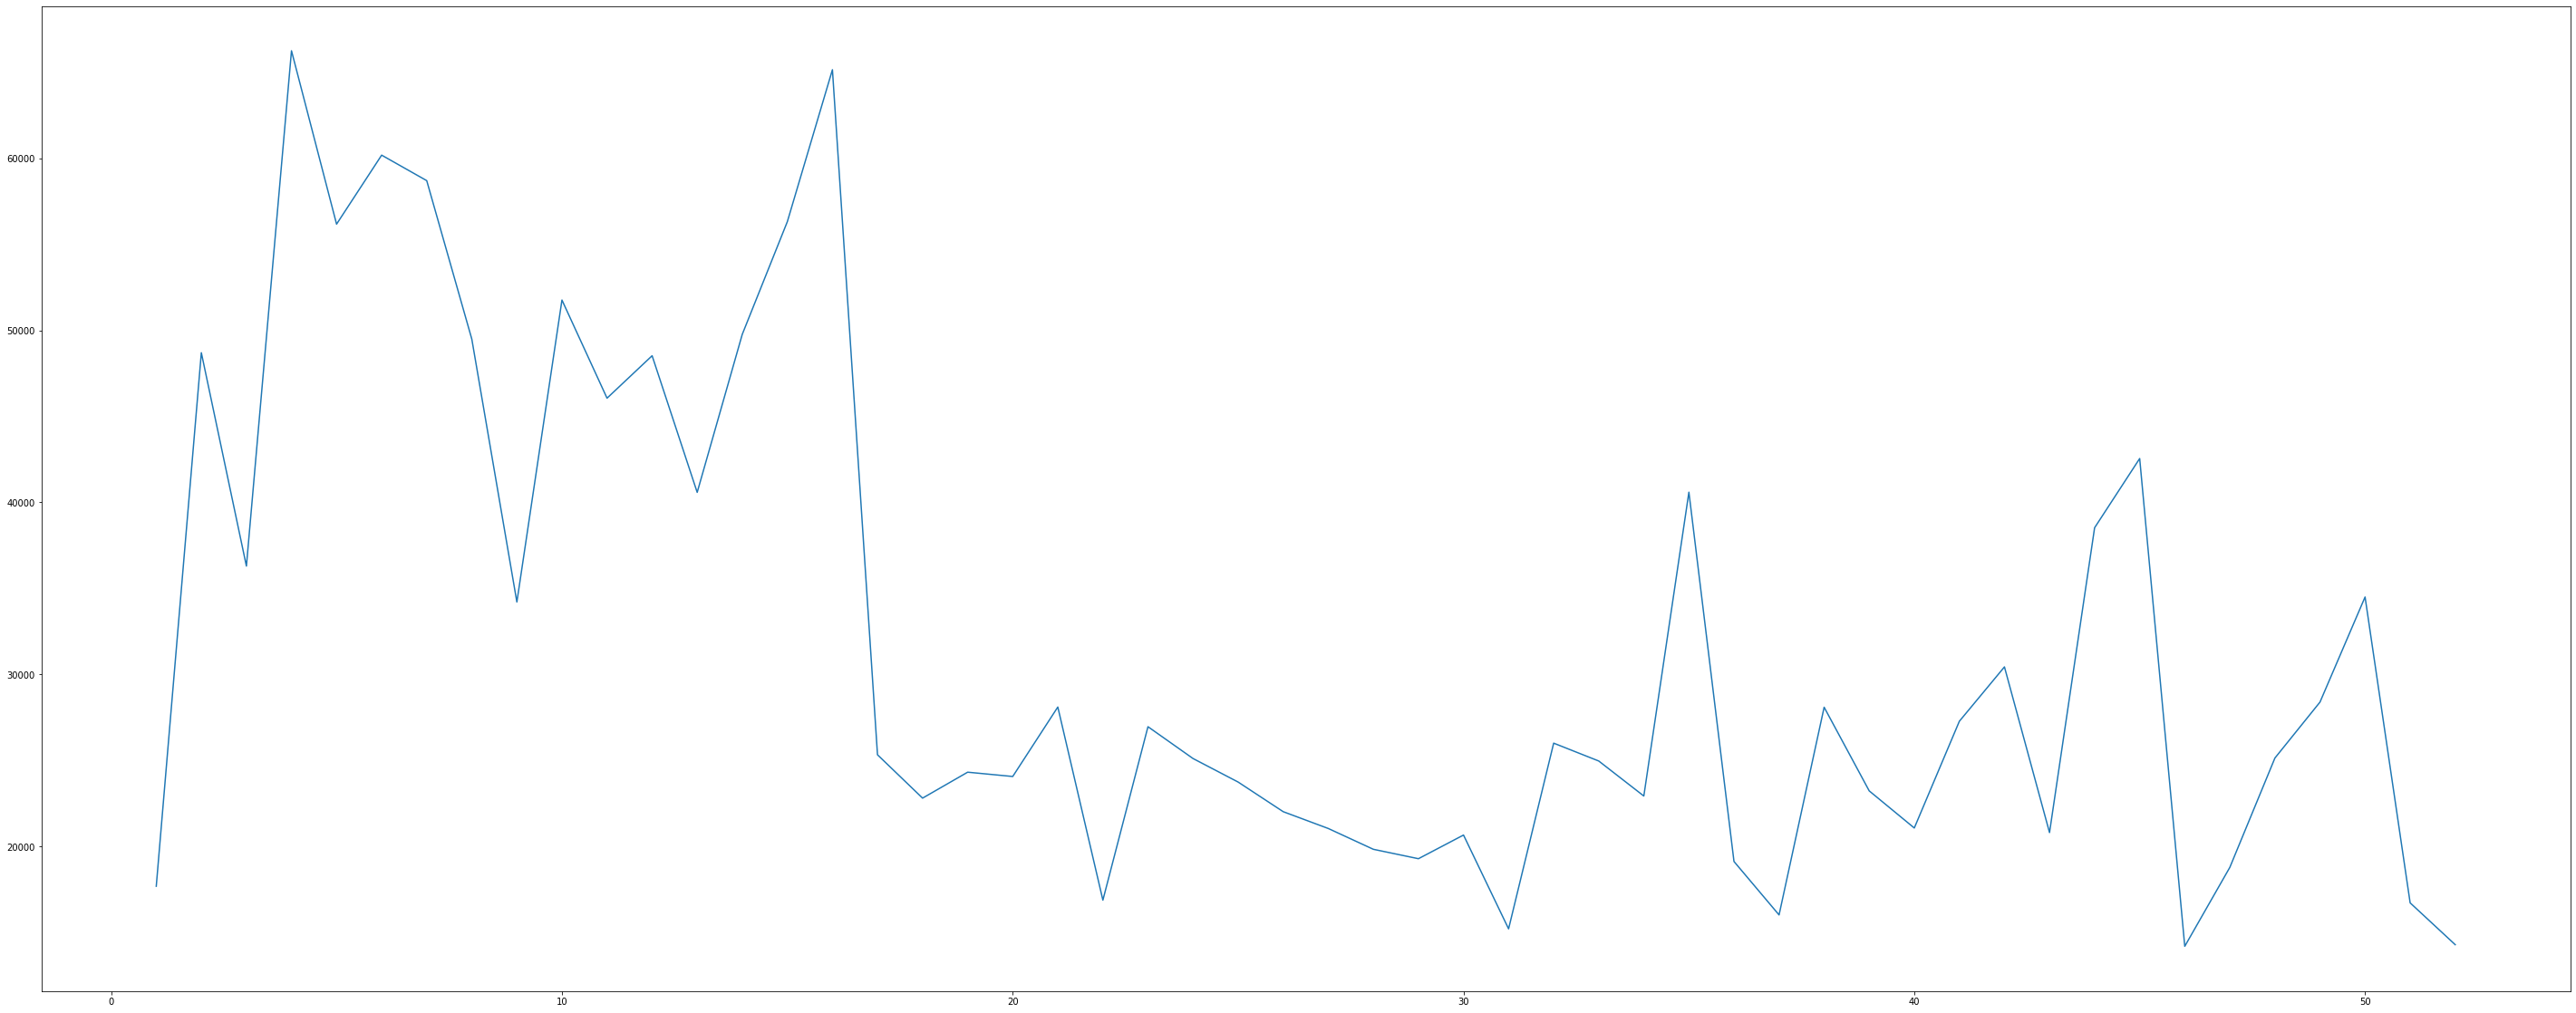

In [50]:
for sc in sku_classes:
    year = 2018
    print("This is the graph for sku_class {} in the year of {}".format(sc, year))
    sku_class_map(sc, year)

Based on the graphs above (sorted from largest class to smallest class) you can see that only `sku_class BZ` has different peaks in 2018 than the others. This is a point to consider later on for the training.

As a last step prior to feature extraction I will look at the distribution of `value` and `cases` per `sku_class` to see whether I can work well with the distribution

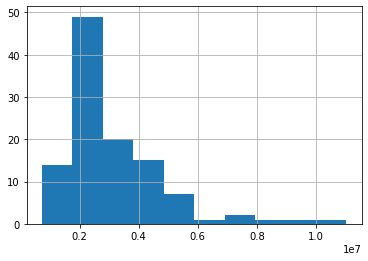

In [61]:
df[df.sku_class == 'AX'].value.hist()

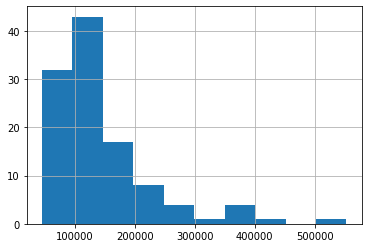

In [62]:
df[df.sku_class == 'AX'].cases.hist()

The distributions are far off a normal distribution. Hence, I will apply the logarithm in order to normalize it further.

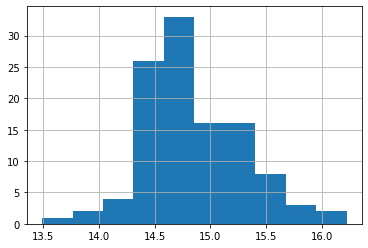

In [63]:
df[(df.sku_class == 'AX') & (df.value >= 1)].value.apply(lambda x: np.log(x+1)).hist()

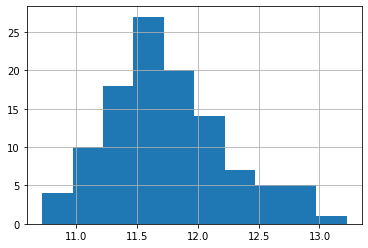

In [64]:
df[(df.sku_class == 'AX') & (df.value >= 1)].cases.apply(lambda x: np.log(x+1)).hist()

Now we have a rather normal distribution (cases even more normal than value), which will help us significantly to improve our results of the prediction.

## Feature Extraction
Let's look at all features we want to take into consideration in our model.

In [9]:
cols = data.columns
cols

Index(['material', 'plant_code', 'cases', 'value', 'sales_date', 'f_day',
       'adbno', 'product_description', 'service_level', 'mrp_desc',
       'group2_desc', 'group3_desc', 'group6_desc', 'est_lead_time',
       'sku_class', 'IS_HOL', 'day', 'month', 'year', 'log_cases', 'weekyear'],
      dtype='object')

In [10]:
features = ['material', 'plant_code', 'service_level', 'mrp_desc', 'group2_desc', 'group3_desc', 'group6_desc', 'est_lead_time', 'sku_class', 'IS_HOL', 'day', 'year', 'weekyear']
categorical_features = ['material', 'plant_code', 'mrp_desc', 'group2_desc', 'group3_desc', 'group6_desc', 'sku_class', 'day', 'year', 'weekyear']

For the first run I only include the above features. Potentially, it makes sense to drop additional features such as `sku_class` or descriptions as well. We will look at the results for now and then see whether there are reasonable actions to take.

## Training Data Preparation
Let's prepare the data for training and validation.

In [75]:
train_data = data[(data.value >= 1) & (data.cases >= 1) & (data.year >= 2017)]
x_train, x_val, y_train, y_val = train_test_split(train_data[features], train_data.value.apply(lambda x: np.log(x+1)), test_size=0.3)

In [76]:
print("x_train shape: {}".format(x_train.shape))
print("x_val shape: {}".format(x_val.shape))
print("y_train shape: {}".format(x_train.shape))
print("y_val shape: {}".format(x_val.shape))

x_train shape: (133007, 13)
x_val shape: (57003, 13)
y_train shape: (133007, 13)
y_val shape: (57003, 13)


The `train_data` is built upon the `data` df for `value >= 1`, `cases >= 1`, and `year >= 2017` based on our findings above in the data exploration part. Following, we split the `train_data` into training and validation parts. Initially, we will use `value` as a parameter for prediction. Further along, we might try `cases` as well to see whether prediction is more accurate.

## Train Model
Since we have a big amount of categorical features, we will use `CatBoostRegressor` as a model. It keeps it simple and takes into consideration the `categorical_features` we defined prior explicitly.

Firstly, I will train a very simple straight forward model to see what the results are. Based on the results I will take further decisions.

In [78]:
cat = CatBoostRegressor()

In [79]:
cat.fit(x_train, y_train, cat_features=categorical_features)

0:	learn: 6.6210130	total: 287ms	remaining: 4m 46s
1:	learn: 6.4319330	total: 341ms	remaining: 2m 50s
2:	learn: 6.2474218	total: 511ms	remaining: 2m 49s
3:	learn: 6.0700276	total: 564ms	remaining: 2m 20s
4:	learn: 5.8973874	total: 660ms	remaining: 2m 11s
5:	learn: 5.7298881	total: 870ms	remaining: 2m 24s
6:	learn: 5.5674236	total: 1.04s	remaining: 2m 28s
7:	learn: 5.4104214	total: 1.26s	remaining: 2m 36s
8:	learn: 5.2571100	total: 1.42s	remaining: 2m 35s
9:	learn: 5.1093168	total: 1.53s	remaining: 2m 31s
10:	learn: 4.9669069	total: 1.65s	remaining: 2m 28s
11:	learn: 4.8281713	total: 1.74s	remaining: 2m 23s
12:	learn: 4.6945122	total: 1.92s	remaining: 2m 26s
13:	learn: 4.5651272	total: 2.07s	remaining: 2m 25s
14:	learn: 4.4398765	total: 2.14s	remaining: 2m 20s
15:	learn: 4.3183772	total: 2.32s	remaining: 2m 22s
16:	learn: 4.2007803	total: 2.5s	remaining: 2m 24s
17:	learn: 4.0874881	total: 2.59s	remaining: 2m 21s
18:	learn: 3.9775417	total: 2.76s	remaining: 2m 22s
19:	learn: 3.8702857	to

158:	learn: 1.0519575	total: 48.6s	remaining: 4m 16s
159:	learn: 1.0515167	total: 49.5s	remaining: 4m 19s
160:	learn: 1.0511516	total: 50.1s	remaining: 4m 21s
161:	learn: 1.0507578	total: 50.7s	remaining: 4m 22s
162:	learn: 1.0503844	total: 51.5s	remaining: 4m 24s
163:	learn: 1.0500093	total: 52s	remaining: 4m 24s
164:	learn: 1.0495407	total: 52.2s	remaining: 4m 24s
165:	learn: 1.0491126	total: 52.4s	remaining: 4m 23s
166:	learn: 1.0487271	total: 52.7s	remaining: 4m 23s
167:	learn: 1.0482920	total: 53s	remaining: 4m 22s
168:	learn: 1.0480025	total: 53.3s	remaining: 4m 22s
169:	learn: 1.0476155	total: 53.6s	remaining: 4m 21s
170:	learn: 1.0473225	total: 53.9s	remaining: 4m 21s
171:	learn: 1.0469522	total: 54.1s	remaining: 4m 20s
172:	learn: 1.0466573	total: 54.3s	remaining: 4m 19s
173:	learn: 1.0464506	total: 54.6s	remaining: 4m 19s
174:	learn: 1.0461308	total: 54.8s	remaining: 4m 18s
175:	learn: 1.0458173	total: 55s	remaining: 4m 17s
176:	learn: 1.0455279	total: 55.1s	remaining: 4m 16s

313:	learn: 1.0246099	total: 1m 23s	remaining: 3m 2s
314:	learn: 1.0245163	total: 1m 23s	remaining: 3m 2s
315:	learn: 1.0244573	total: 1m 24s	remaining: 3m 1s
316:	learn: 1.0243893	total: 1m 24s	remaining: 3m 2s
317:	learn: 1.0243163	total: 1m 25s	remaining: 3m 2s
318:	learn: 1.0242785	total: 1m 25s	remaining: 3m 1s
319:	learn: 1.0242195	total: 1m 25s	remaining: 3m 1s
320:	learn: 1.0241565	total: 1m 25s	remaining: 3m 1s
321:	learn: 1.0240827	total: 1m 25s	remaining: 3m
322:	learn: 1.0240280	total: 1m 25s	remaining: 3m
323:	learn: 1.0239777	total: 1m 26s	remaining: 2m 59s
324:	learn: 1.0238899	total: 1m 26s	remaining: 2m 59s
325:	learn: 1.0238653	total: 1m 26s	remaining: 2m 58s
326:	learn: 1.0238114	total: 1m 26s	remaining: 2m 58s
327:	learn: 1.0237068	total: 1m 26s	remaining: 2m 57s
328:	learn: 1.0236414	total: 1m 27s	remaining: 2m 57s
329:	learn: 1.0235686	total: 1m 27s	remaining: 2m 57s
330:	learn: 1.0234890	total: 1m 27s	remaining: 2m 57s
331:	learn: 1.0233717	total: 1m 28s	remainin

466:	learn: 1.0157334	total: 1m 57s	remaining: 2m 13s
467:	learn: 1.0156932	total: 1m 57s	remaining: 2m 13s
468:	learn: 1.0156692	total: 1m 57s	remaining: 2m 13s
469:	learn: 1.0156093	total: 1m 57s	remaining: 2m 12s
470:	learn: 1.0155785	total: 1m 57s	remaining: 2m 12s
471:	learn: 1.0155247	total: 1m 58s	remaining: 2m 12s
472:	learn: 1.0155062	total: 1m 58s	remaining: 2m 11s
473:	learn: 1.0154867	total: 1m 58s	remaining: 2m 11s
474:	learn: 1.0154613	total: 1m 58s	remaining: 2m 11s
475:	learn: 1.0154132	total: 1m 59s	remaining: 2m 11s
476:	learn: 1.0153446	total: 1m 59s	remaining: 2m 10s
477:	learn: 1.0152924	total: 1m 59s	remaining: 2m 10s
478:	learn: 1.0152155	total: 1m 59s	remaining: 2m 10s
479:	learn: 1.0151847	total: 2m	remaining: 2m 10s
480:	learn: 1.0151014	total: 2m	remaining: 2m 9s
481:	learn: 1.0150434	total: 2m	remaining: 2m 9s
482:	learn: 1.0150136	total: 2m	remaining: 2m 9s
483:	learn: 1.0149938	total: 2m 1s	remaining: 2m 9s
484:	learn: 1.0149685	total: 2m 1s	remaining: 2m 

620:	learn: 1.0101810	total: 2m 28s	remaining: 1m 30s
621:	learn: 1.0101509	total: 2m 29s	remaining: 1m 30s
622:	learn: 1.0101193	total: 2m 29s	remaining: 1m 30s
623:	learn: 1.0101016	total: 2m 29s	remaining: 1m 30s
624:	learn: 1.0100714	total: 2m 29s	remaining: 1m 29s
625:	learn: 1.0100586	total: 2m 29s	remaining: 1m 29s
626:	learn: 1.0100317	total: 2m 30s	remaining: 1m 29s
627:	learn: 1.0100197	total: 2m 30s	remaining: 1m 28s
628:	learn: 1.0099817	total: 2m 30s	remaining: 1m 28s
629:	learn: 1.0099418	total: 2m 30s	remaining: 1m 28s
630:	learn: 1.0099053	total: 2m 30s	remaining: 1m 28s
631:	learn: 1.0098897	total: 2m 31s	remaining: 1m 27s
632:	learn: 1.0098703	total: 2m 31s	remaining: 1m 27s
633:	learn: 1.0098568	total: 2m 31s	remaining: 1m 27s
634:	learn: 1.0098296	total: 2m 31s	remaining: 1m 27s
635:	learn: 1.0097900	total: 2m 31s	remaining: 1m 26s
636:	learn: 1.0097844	total: 2m 32s	remaining: 1m 26s
637:	learn: 1.0097501	total: 2m 32s	remaining: 1m 26s
638:	learn: 1.0097312	total:

775:	learn: 1.0063489	total: 3m 9s	remaining: 54.7s
776:	learn: 1.0063151	total: 3m 9s	remaining: 54.5s
777:	learn: 1.0062999	total: 3m 10s	remaining: 54.3s
778:	learn: 1.0062858	total: 3m 10s	remaining: 54s
779:	learn: 1.0062683	total: 3m 10s	remaining: 53.8s
780:	learn: 1.0062542	total: 3m 10s	remaining: 53.5s
781:	learn: 1.0062392	total: 3m 11s	remaining: 53.3s
782:	learn: 1.0062287	total: 3m 11s	remaining: 53.1s
783:	learn: 1.0061935	total: 3m 11s	remaining: 52.8s
784:	learn: 1.0061789	total: 3m 11s	remaining: 52.6s
785:	learn: 1.0061595	total: 3m 12s	remaining: 52.3s
786:	learn: 1.0061533	total: 3m 12s	remaining: 52.1s
787:	learn: 1.0061338	total: 3m 12s	remaining: 51.8s
788:	learn: 1.0061223	total: 3m 12s	remaining: 51.6s
789:	learn: 1.0061129	total: 3m 13s	remaining: 51.3s
790:	learn: 1.0060876	total: 3m 13s	remaining: 51.1s
791:	learn: 1.0060698	total: 3m 13s	remaining: 50.9s
792:	learn: 1.0060594	total: 3m 14s	remaining: 50.6s
793:	learn: 1.0060431	total: 3m 14s	remaining: 50.

931:	learn: 1.0033268	total: 3m 44s	remaining: 16.4s
932:	learn: 1.0033128	total: 3m 44s	remaining: 16.2s
933:	learn: 1.0032902	total: 3m 45s	remaining: 15.9s
934:	learn: 1.0032656	total: 3m 45s	remaining: 15.7s
935:	learn: 1.0032531	total: 3m 45s	remaining: 15.4s
936:	learn: 1.0032502	total: 3m 45s	remaining: 15.2s
937:	learn: 1.0032311	total: 3m 45s	remaining: 14.9s
938:	learn: 1.0032192	total: 3m 46s	remaining: 14.7s
939:	learn: 1.0032052	total: 3m 46s	remaining: 14.4s
940:	learn: 1.0031828	total: 3m 46s	remaining: 14.2s
941:	learn: 1.0031561	total: 3m 46s	remaining: 14s
942:	learn: 1.0031341	total: 3m 46s	remaining: 13.7s
943:	learn: 1.0031295	total: 3m 47s	remaining: 13.5s
944:	learn: 1.0030933	total: 3m 47s	remaining: 13.2s
945:	learn: 1.0030581	total: 3m 47s	remaining: 13s
946:	learn: 1.0030329	total: 3m 47s	remaining: 12.7s
947:	learn: 1.0030088	total: 3m 47s	remaining: 12.5s
948:	learn: 1.0029953	total: 3m 48s	remaining: 12.3s
949:	learn: 1.0029744	total: 3m 48s	remaining: 12s

In [14]:
f = lambda x: np.exp(x) - 1

In [81]:
y_pred = cat.predict(x_train)
print("MSE: {}".format(mean_squared_error(f(y_train), f(y_pred))))

MSE: 35247435.71518816


The MSE for the `value` is extremely high (>35m). Let's see what caused this variance.

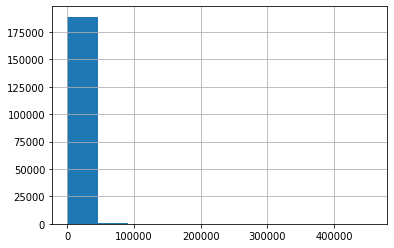

In [82]:
train_data.value.hist()

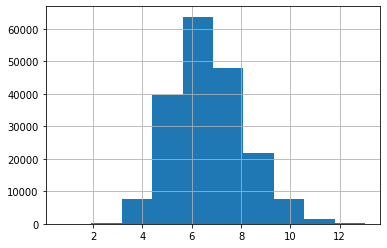

In [83]:
train_data.value.apply(lambda x: np.log(x + 1)).hist()

As can be seen by the two plots above, we have a severe problem with the outliers in the `value` of some orders. Hence, I will use the `zscore` to reduce the outliers impact on the model.

In [85]:
train_data = train_data[np.abs(zscore(train_data.value.apply(lambda x: np.log(x + 1))) < 3)]

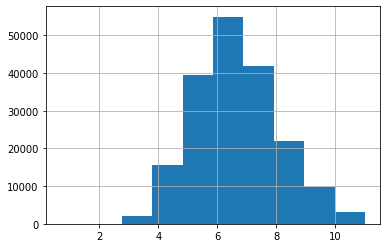

In [86]:
train_data.value.apply(lambda x: np.log(x + 1)).hist()

In [89]:
x_train, x_val, y_train, y_val = train_test_split(train_data[features], train_data.value.apply(lambda x: np.log(x+1)))
cat = CatBoostRegressor()
cat.fit(x_train, y_train, cat_features=categorical_features)

0:	learn: 6.6026542	total: 214ms	remaining: 3m 34s
1:	learn: 6.4125627	total: 357ms	remaining: 2m 58s
2:	learn: 6.2293472	total: 438ms	remaining: 2m 25s
3:	learn: 6.0518878	total: 612ms	remaining: 2m 32s
4:	learn: 5.8791075	total: 840ms	remaining: 2m 47s
5:	learn: 5.7129133	total: 865ms	remaining: 2m 23s
6:	learn: 5.5509153	total: 930ms	remaining: 2m 11s
7:	learn: 5.3951037	total: 1.01s	remaining: 2m 5s
8:	learn: 5.2430047	total: 1.24s	remaining: 2m 16s
9:	learn: 5.0953031	total: 1.57s	remaining: 2m 35s
10:	learn: 4.9523300	total: 1.9s	remaining: 2m 51s
11:	learn: 4.8128952	total: 2.18s	remaining: 2m 59s
12:	learn: 4.6777482	total: 2.46s	remaining: 3m 7s
13:	learn: 4.5484971	total: 2.69s	remaining: 3m 9s
14:	learn: 4.4225858	total: 2.87s	remaining: 3m 8s
15:	learn: 4.3021075	total: 3.06s	remaining: 3m 8s
16:	learn: 4.1859589	total: 3.08s	remaining: 2m 58s
17:	learn: 4.0722704	total: 3.19s	remaining: 2m 53s
18:	learn: 3.9610483	total: 3.41s	remaining: 2m 56s
19:	learn: 3.8544479	total: 

159:	learn: 1.0456204	total: 35.3s	remaining: 3m 5s
160:	learn: 1.0451414	total: 35.5s	remaining: 3m 4s
161:	learn: 1.0447318	total: 35.6s	remaining: 3m 4s
162:	learn: 1.0443085	total: 35.7s	remaining: 3m 3s
163:	learn: 1.0439512	total: 35.9s	remaining: 3m 2s
164:	learn: 1.0435610	total: 36.1s	remaining: 3m 2s
165:	learn: 1.0430695	total: 36.3s	remaining: 3m 2s
166:	learn: 1.0426416	total: 36.5s	remaining: 3m 1s
167:	learn: 1.0422975	total: 36.7s	remaining: 3m 1s
168:	learn: 1.0419432	total: 36.8s	remaining: 3m 1s
169:	learn: 1.0416304	total: 37s	remaining: 3m
170:	learn: 1.0413362	total: 37.2s	remaining: 3m
171:	learn: 1.0410156	total: 37.4s	remaining: 3m
172:	learn: 1.0407304	total: 37.6s	remaining: 2m 59s
173:	learn: 1.0404311	total: 37.8s	remaining: 2m 59s
174:	learn: 1.0401085	total: 38s	remaining: 2m 59s
175:	learn: 1.0397884	total: 38.2s	remaining: 2m 58s
176:	learn: 1.0394818	total: 38.4s	remaining: 2m 58s
177:	learn: 1.0391068	total: 38.6s	remaining: 2m 58s
178:	learn: 1.03884

315:	learn: 1.0189879	total: 1m 15s	remaining: 2m 43s
316:	learn: 1.0189324	total: 1m 15s	remaining: 2m 43s
317:	learn: 1.0188316	total: 1m 16s	remaining: 2m 42s
318:	learn: 1.0187872	total: 1m 16s	remaining: 2m 42s
319:	learn: 1.0187134	total: 1m 16s	remaining: 2m 42s
320:	learn: 1.0186305	total: 1m 16s	remaining: 2m 41s
321:	learn: 1.0185308	total: 1m 16s	remaining: 2m 41s
322:	learn: 1.0184517	total: 1m 17s	remaining: 2m 41s
323:	learn: 1.0183499	total: 1m 17s	remaining: 2m 41s
324:	learn: 1.0182936	total: 1m 17s	remaining: 2m 40s
325:	learn: 1.0182474	total: 1m 17s	remaining: 2m 40s
326:	learn: 1.0181631	total: 1m 18s	remaining: 2m 40s
327:	learn: 1.0180851	total: 1m 18s	remaining: 2m 40s
328:	learn: 1.0180170	total: 1m 18s	remaining: 2m 40s
329:	learn: 1.0179051	total: 1m 19s	remaining: 2m 40s
330:	learn: 1.0178505	total: 1m 19s	remaining: 2m 40s
331:	learn: 1.0177412	total: 1m 19s	remaining: 2m 40s
332:	learn: 1.0176955	total: 1m 19s	remaining: 2m 40s
333:	learn: 1.0176022	total:

468:	learn: 1.0099933	total: 1m 54s	remaining: 2m 9s
469:	learn: 1.0099362	total: 1m 55s	remaining: 2m 9s
470:	learn: 1.0098796	total: 1m 55s	remaining: 2m 9s
471:	learn: 1.0098565	total: 1m 56s	remaining: 2m 10s
472:	learn: 1.0097925	total: 1m 57s	remaining: 2m 11s
473:	learn: 1.0097525	total: 1m 57s	remaining: 2m 10s
474:	learn: 1.0096958	total: 1m 58s	remaining: 2m 10s
475:	learn: 1.0096657	total: 1m 58s	remaining: 2m 10s
476:	learn: 1.0096296	total: 1m 58s	remaining: 2m 10s
477:	learn: 1.0095882	total: 1m 59s	remaining: 2m 10s
478:	learn: 1.0095398	total: 1m 59s	remaining: 2m 9s
479:	learn: 1.0094859	total: 1m 59s	remaining: 2m 9s
480:	learn: 1.0094189	total: 1m 59s	remaining: 2m 9s
481:	learn: 1.0093440	total: 2m	remaining: 2m 8s
482:	learn: 1.0092979	total: 2m	remaining: 2m 8s
483:	learn: 1.0092385	total: 2m	remaining: 2m 8s
484:	learn: 1.0091840	total: 2m	remaining: 2m 8s
485:	learn: 1.0091469	total: 2m	remaining: 2m 7s
486:	learn: 1.0091151	total: 2m 1s	remaining: 2m 7s
487:	le

622:	learn: 1.0040045	total: 2m 34s	remaining: 1m 33s
623:	learn: 1.0039674	total: 2m 35s	remaining: 1m 33s
624:	learn: 1.0039294	total: 2m 35s	remaining: 1m 33s
625:	learn: 1.0039019	total: 2m 35s	remaining: 1m 32s
626:	learn: 1.0038769	total: 2m 35s	remaining: 1m 32s
627:	learn: 1.0038145	total: 2m 35s	remaining: 1m 32s
628:	learn: 1.0037792	total: 2m 36s	remaining: 1m 32s
629:	learn: 1.0037436	total: 2m 36s	remaining: 1m 31s
630:	learn: 1.0037057	total: 2m 36s	remaining: 1m 31s
631:	learn: 1.0036795	total: 2m 36s	remaining: 1m 31s
632:	learn: 1.0036256	total: 2m 36s	remaining: 1m 30s
633:	learn: 1.0035915	total: 2m 37s	remaining: 1m 30s
634:	learn: 1.0035480	total: 2m 37s	remaining: 1m 30s
635:	learn: 1.0035243	total: 2m 37s	remaining: 1m 30s
636:	learn: 1.0034785	total: 2m 37s	remaining: 1m 29s
637:	learn: 1.0034555	total: 2m 37s	remaining: 1m 29s
638:	learn: 1.0034183	total: 2m 38s	remaining: 1m 29s
639:	learn: 1.0034056	total: 2m 38s	remaining: 1m 29s
640:	learn: 1.0033583	total:

778:	learn: 1.0000496	total: 3m 7s	remaining: 53.1s
779:	learn: 1.0000300	total: 3m 7s	remaining: 52.9s
780:	learn: 1.0000066	total: 3m 7s	remaining: 52.6s
781:	learn: 0.9999940	total: 3m 7s	remaining: 52.4s
782:	learn: 0.9999739	total: 3m 8s	remaining: 52.1s
783:	learn: 0.9999664	total: 3m 8s	remaining: 51.9s
784:	learn: 0.9999539	total: 3m 8s	remaining: 51.6s
785:	learn: 0.9999125	total: 3m 8s	remaining: 51.3s
786:	learn: 0.9998697	total: 3m 8s	remaining: 51.1s
787:	learn: 0.9998379	total: 3m 9s	remaining: 50.9s
788:	learn: 0.9998310	total: 3m 9s	remaining: 50.6s
789:	learn: 0.9998017	total: 3m 9s	remaining: 50.4s
790:	learn: 0.9997879	total: 3m 9s	remaining: 50.1s
791:	learn: 0.9997630	total: 3m 9s	remaining: 49.9s
792:	learn: 0.9997486	total: 3m 10s	remaining: 49.6s
793:	learn: 0.9997329	total: 3m 10s	remaining: 49.4s
794:	learn: 0.9997176	total: 3m 10s	remaining: 49.1s
795:	learn: 0.9997114	total: 3m 10s	remaining: 48.8s
796:	learn: 0.9996689	total: 3m 10s	remaining: 48.6s
797:	le

934:	learn: 0.9971184	total: 3m 39s	remaining: 15.2s
935:	learn: 0.9971047	total: 3m 39s	remaining: 15s
936:	learn: 0.9970905	total: 3m 39s	remaining: 14.8s
937:	learn: 0.9970613	total: 3m 39s	remaining: 14.5s
938:	learn: 0.9970170	total: 3m 40s	remaining: 14.3s
939:	learn: 0.9969883	total: 3m 40s	remaining: 14.1s
940:	learn: 0.9969794	total: 3m 40s	remaining: 13.8s
941:	learn: 0.9969502	total: 3m 40s	remaining: 13.6s
942:	learn: 0.9969292	total: 3m 41s	remaining: 13.4s
943:	learn: 0.9969104	total: 3m 41s	remaining: 13.1s
944:	learn: 0.9968812	total: 3m 41s	remaining: 12.9s
945:	learn: 0.9968675	total: 3m 41s	remaining: 12.7s
946:	learn: 0.9968552	total: 3m 42s	remaining: 12.4s
947:	learn: 0.9968417	total: 3m 42s	remaining: 12.2s
948:	learn: 0.9968182	total: 3m 43s	remaining: 12s
949:	learn: 0.9968052	total: 3m 43s	remaining: 11.8s
950:	learn: 0.9967862	total: 3m 43s	remaining: 11.5s
951:	learn: 0.9967773	total: 3m 43s	remaining: 11.3s
952:	learn: 0.9967591	total: 3m 44s	remaining: 11.

ValueError: Found input variables with inconsistent numbers of samples: [47343, 133007]

In [90]:
print("train MSE: {}".format(mean_squared_error(f(y_train), f(cat.predict(x_train)))))
print("valid. MSE: {}".format(mean_squared_error(f(y_val), f(cat.predict(x_val)))))

train MSE: 14456773.407724781
valid. MSE: 15025292.926725497


As we can see, we reduced the `train MSE` by more than 50%. Hence, this is a step in the right direction. Furthermore, we will look into the importances of the various features.

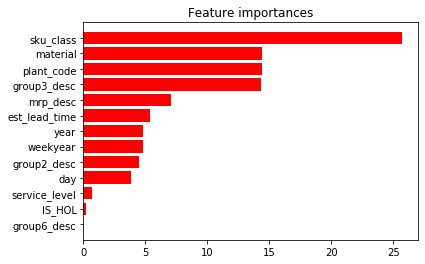

In [92]:
importances = cat.feature_importances_
indices = np.argsort(importances)

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.barh(range(x_train.shape[1]), importances[indices],
       color="r", align="center")
plt.yticks(range(x_train.shape[1]), [features[i] for i in indices])
plt.ylim([-1, x_train.shape[1]])
plt.show()

According to the features we have a high dependency on the `sku_class` and `group6_desc` does not add any importance. Let's additionally look at the errors made in the prediction to see where there errors came from mostly.

In [99]:
dic = {'y_val':f(y_val), 'y_pred':f(cat.predict(x_val))}
df_verification = pd.DataFrame(dic)
df_verification['error'] = abs(f(y_val) - f(cat.predict(x_val)))
df_verification = df_verification.sort_values(['error'], ascending=False)
df_verification[::1500]

y_val        y_pred         error
144799  58020.00    723.582856  57296.417144
68161    2598.46  11568.863131   8970.403131
50059    6856.70   1792.063201   5064.636799
165962   4918.20   1401.981338   3516.218662
55466    2012.40   4611.043262   2598.643262
182927    977.32   2986.588481   2009.268481
78310    1958.22    347.772923   1610.447077
8069     1686.80    372.435768   1314.364232
102774   1724.13    629.998981   1094.131019
113583   1660.30    726.813143    933.486857
177357   1007.70    203.215475    804.484525
181127    982.02    280.959720    701.060280
125657    793.56    177.605538    615.954462
109863    305.62    852.811967    547.191967
138554   1231.51   1715.968629    484.458629
15688     732.60    297.007853    435.592147
63593    5279.73   4890.462146    389.267854
42435     345.60    693.822020    348.222020
81120     732.40   1044.812569    312.412569
122151    187.46    466.983193    279.523193
102408    298.92    548.255505    249.335505
178658    820.40    599.193832    221.206168
134814    425.88    230.269896    195.610104
113646    300.00    472.037020    172.037020
115403    126.92    276.870025    149.950025
189719    361.30    232.918229    128.381771
130530    112.20    220.714853    108.514853
171073     32.11    120.775850     88.665850
2959      216.21    285.690947     69.480947
90107     230.76    179.361177     51.398823
92017     273.15    304.586836     31.436836
125872    397.32    408.692729     11.372729

Based on the `df_verification` we can identify that the outliers (especially top value outliers) cause the MSE to increase significantly.

In [100]:
features = ['material', 'plant_code', 'service_level', 'mrp_desc', 'group2_desc', 'group3_desc', 'est_lead_time', 'IS_HOL', 'day', 'year', 'weekyear']
categorical_features = ['material', 'plant_code', 'mrp_desc', 'group2_desc', 'group3_desc', 'day', 'year', 'weekyear']

train_data = train_data[np.abs(zscore(train_data.value.apply(lambda x: np.log(x + 1))) < 3)]
x_train, x_val, y_train, y_val = train_test_split(train_data[features], train_data.value.apply(lambda x: np.log(x+1)))
cat = CatBoostRegressor()
cat.fit(x_train, y_train, cat_features=categorical_features)

0:	learn: 6.6023691	total: 123ms	remaining: 2m 2s
1:	learn: 6.4136576	total: 177ms	remaining: 1m 28s
2:	learn: 6.2305787	total: 229ms	remaining: 1m 15s
3:	learn: 6.0535559	total: 253ms	remaining: 1m 3s
4:	learn: 5.8817515	total: 467ms	remaining: 1m 32s
5:	learn: 5.7148363	total: 881ms	remaining: 2m 26s
6:	learn: 5.5540931	total: 936ms	remaining: 2m 12s
7:	learn: 5.3984839	total: 1.02s	remaining: 2m 6s
8:	learn: 5.2475106	total: 1.25s	remaining: 2m 18s
9:	learn: 5.1014297	total: 1.3s	remaining: 2m 8s
10:	learn: 4.9584717	total: 1.4s	remaining: 2m 6s
11:	learn: 4.8204891	total: 1.56s	remaining: 2m 8s
12:	learn: 4.6865689	total: 1.67s	remaining: 2m 7s
13:	learn: 4.5575266	total: 1.71s	remaining: 2m
14:	learn: 4.4320709	total: 1.93s	remaining: 2m 6s
15:	learn: 4.3105076	total: 2.06s	remaining: 2m 6s
16:	learn: 4.1930955	total: 2.13s	remaining: 2m 3s
17:	learn: 4.0810664	total: 2.19s	remaining: 1m 59s
18:	learn: 3.9702100	total: 2.45s	remaining: 2m 6s
19:	learn: 3.8629775	total: 2.6s	remain

158:	learn: 1.0461520	total: 29.5s	remaining: 2m 36s
159:	learn: 1.0456529	total: 29.7s	remaining: 2m 35s
160:	learn: 1.0452244	total: 29.9s	remaining: 2m 35s
161:	learn: 1.0448400	total: 30s	remaining: 2m 35s
162:	learn: 1.0444492	total: 30.2s	remaining: 2m 34s
163:	learn: 1.0440133	total: 30.3s	remaining: 2m 34s
164:	learn: 1.0436399	total: 30.5s	remaining: 2m 34s
165:	learn: 1.0432733	total: 30.7s	remaining: 2m 34s
166:	learn: 1.0428713	total: 30.9s	remaining: 2m 33s
167:	learn: 1.0424153	total: 31s	remaining: 2m 33s
168:	learn: 1.0421165	total: 31.3s	remaining: 2m 33s
169:	learn: 1.0417973	total: 31.4s	remaining: 2m 33s
170:	learn: 1.0414515	total: 31.6s	remaining: 2m 33s
171:	learn: 1.0411642	total: 31.8s	remaining: 2m 33s
172:	learn: 1.0408335	total: 31.9s	remaining: 2m 32s
173:	learn: 1.0405158	total: 32.1s	remaining: 2m 32s
174:	learn: 1.0401865	total: 32.3s	remaining: 2m 32s
175:	learn: 1.0399102	total: 32.6s	remaining: 2m 32s
176:	learn: 1.0396263	total: 32.7s	remaining: 2m 3

315:	learn: 1.0195525	total: 1m 1s	remaining: 2m 13s
316:	learn: 1.0194819	total: 1m 1s	remaining: 2m 13s
317:	learn: 1.0194015	total: 1m 2s	remaining: 2m 13s
318:	learn: 1.0193365	total: 1m 2s	remaining: 2m 12s
319:	learn: 1.0192306	total: 1m 2s	remaining: 2m 12s
320:	learn: 1.0191786	total: 1m 2s	remaining: 2m 12s
321:	learn: 1.0191000	total: 1m 2s	remaining: 2m 12s
322:	learn: 1.0190422	total: 1m 3s	remaining: 2m 12s
323:	learn: 1.0189568	total: 1m 3s	remaining: 2m 12s
324:	learn: 1.0189036	total: 1m 3s	remaining: 2m 11s
325:	learn: 1.0188672	total: 1m 3s	remaining: 2m 11s
326:	learn: 1.0188198	total: 1m 3s	remaining: 2m 11s
327:	learn: 1.0187503	total: 1m 4s	remaining: 2m 11s
328:	learn: 1.0186943	total: 1m 4s	remaining: 2m 11s
329:	learn: 1.0186321	total: 1m 4s	remaining: 2m 11s
330:	learn: 1.0185345	total: 1m 5s	remaining: 2m 11s
331:	learn: 1.0185017	total: 1m 5s	remaining: 2m 11s
332:	learn: 1.0184039	total: 1m 5s	remaining: 2m 11s
333:	learn: 1.0183655	total: 1m 5s	remaining: 

470:	learn: 1.0104848	total: 1m 33s	remaining: 1m 44s
471:	learn: 1.0104229	total: 1m 33s	remaining: 1m 44s
472:	learn: 1.0103870	total: 1m 33s	remaining: 1m 44s
473:	learn: 1.0103187	total: 1m 34s	remaining: 1m 44s
474:	learn: 1.0102854	total: 1m 34s	remaining: 1m 44s
475:	learn: 1.0102220	total: 1m 34s	remaining: 1m 43s
476:	learn: 1.0101438	total: 1m 34s	remaining: 1m 43s
477:	learn: 1.0101337	total: 1m 35s	remaining: 1m 43s
478:	learn: 1.0100908	total: 1m 35s	remaining: 1m 43s
479:	learn: 1.0100438	total: 1m 35s	remaining: 1m 43s
480:	learn: 1.0099642	total: 1m 35s	remaining: 1m 43s
481:	learn: 1.0099393	total: 1m 36s	remaining: 1m 43s
482:	learn: 1.0099013	total: 1m 36s	remaining: 1m 42s
483:	learn: 1.0098383	total: 1m 36s	remaining: 1m 42s
484:	learn: 1.0098033	total: 1m 36s	remaining: 1m 42s
485:	learn: 1.0097648	total: 1m 36s	remaining: 1m 42s
486:	learn: 1.0097143	total: 1m 37s	remaining: 1m 42s
487:	learn: 1.0096674	total: 1m 37s	remaining: 1m 42s
488:	learn: 1.0096324	total:

623:	learn: 1.0046818	total: 2m 6s	remaining: 1m 16s
624:	learn: 1.0046527	total: 2m 6s	remaining: 1m 15s
625:	learn: 1.0046324	total: 2m 6s	remaining: 1m 15s
626:	learn: 1.0046014	total: 2m 6s	remaining: 1m 15s
627:	learn: 1.0045797	total: 2m 7s	remaining: 1m 15s
628:	learn: 1.0045507	total: 2m 7s	remaining: 1m 15s
629:	learn: 1.0045128	total: 2m 7s	remaining: 1m 14s
630:	learn: 1.0044922	total: 2m 7s	remaining: 1m 14s
631:	learn: 1.0044682	total: 2m 7s	remaining: 1m 14s
632:	learn: 1.0044186	total: 2m 8s	remaining: 1m 14s
633:	learn: 1.0044002	total: 2m 8s	remaining: 1m 14s
634:	learn: 1.0043646	total: 2m 8s	remaining: 1m 13s
635:	learn: 1.0043395	total: 2m 8s	remaining: 1m 13s
636:	learn: 1.0043069	total: 2m 8s	remaining: 1m 13s
637:	learn: 1.0042912	total: 2m 9s	remaining: 1m 13s
638:	learn: 1.0042494	total: 2m 9s	remaining: 1m 13s
639:	learn: 1.0042132	total: 2m 9s	remaining: 1m 12s
640:	learn: 1.0041905	total: 2m 9s	remaining: 1m 12s
641:	learn: 1.0041702	total: 2m 9s	remaining: 

778:	learn: 1.0006717	total: 2m 38s	remaining: 45.1s
779:	learn: 1.0006554	total: 2m 38s	remaining: 44.8s
780:	learn: 1.0006277	total: 2m 39s	remaining: 44.6s
781:	learn: 1.0006137	total: 2m 39s	remaining: 44.4s
782:	learn: 1.0005889	total: 2m 39s	remaining: 44.2s
783:	learn: 1.0005614	total: 2m 39s	remaining: 44s
784:	learn: 1.0005474	total: 2m 39s	remaining: 43.8s
785:	learn: 1.0005265	total: 2m 40s	remaining: 43.6s
786:	learn: 1.0005129	total: 2m 40s	remaining: 43.4s
787:	learn: 1.0004986	total: 2m 40s	remaining: 43.2s
788:	learn: 1.0004873	total: 2m 40s	remaining: 43s
789:	learn: 1.0004537	total: 2m 40s	remaining: 42.8s
790:	learn: 1.0004192	total: 2m 41s	remaining: 42.6s
791:	learn: 1.0003991	total: 2m 41s	remaining: 42.4s
792:	learn: 1.0003863	total: 2m 41s	remaining: 42.2s
793:	learn: 1.0003550	total: 2m 42s	remaining: 42s
794:	learn: 1.0003491	total: 2m 42s	remaining: 41.9s
795:	learn: 1.0003450	total: 2m 42s	remaining: 41.7s
796:	learn: 1.0003246	total: 2m 42s	remaining: 41.5s

936:	learn: 0.9976584	total: 3m 18s	remaining: 13.3s
937:	learn: 0.9976342	total: 3m 18s	remaining: 13.1s
938:	learn: 0.9976047	total: 3m 18s	remaining: 12.9s
939:	learn: 0.9975876	total: 3m 18s	remaining: 12.7s
940:	learn: 0.9975775	total: 3m 19s	remaining: 12.5s
941:	learn: 0.9975557	total: 3m 19s	remaining: 12.3s
942:	learn: 0.9975259	total: 3m 19s	remaining: 12.1s
943:	learn: 0.9975163	total: 3m 19s	remaining: 11.9s
944:	learn: 0.9974813	total: 3m 20s	remaining: 11.7s
945:	learn: 0.9974491	total: 3m 20s	remaining: 11.4s
946:	learn: 0.9974381	total: 3m 20s	remaining: 11.2s
947:	learn: 0.9974300	total: 3m 20s	remaining: 11s
948:	learn: 0.9974247	total: 3m 21s	remaining: 10.8s
949:	learn: 0.9974090	total: 3m 21s	remaining: 10.6s
950:	learn: 0.9974035	total: 3m 21s	remaining: 10.4s
951:	learn: 0.9973799	total: 3m 21s	remaining: 10.2s
952:	learn: 0.9973537	total: 3m 21s	remaining: 9.96s
953:	learn: 0.9973439	total: 3m 22s	remaining: 9.74s
954:	learn: 0.9973384	total: 3m 22s	remaining: 9

In [101]:
print("train MSE: {}".format(mean_squared_error(f(y_train), f(cat.predict(x_train)))))
print("valid. MSE: {}".format(mean_squared_error(f(y_val), f(cat.predict(x_val)))))

train MSE: 13758934.040072525
valid. MSE: 13322745.310889078


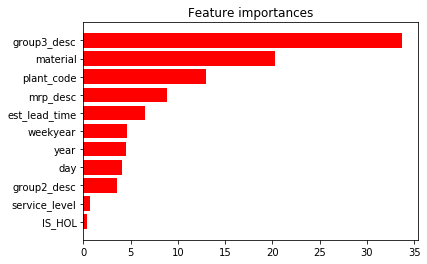

In [102]:
importances = cat.feature_importances_
indices = np.argsort(importances)

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.barh(range(x_train.shape[1]), importances[indices],
       color="r", align="center")
plt.yticks(range(x_train.shape[1]), [features[i] for i in indices])
plt.ylim([-1, x_train.shape[1]])
plt.show()

Also with these adjustments we cannot achieve great results. Reviewing with the client, we agreed on predicting `cases` instead of `value`. The variance of `cases` is lower since the `value` is amplified by the value of each material per case, which can be varying significantly. Additionally, I will remove `service_level` and `IS_HOL` from the features.

In [107]:
train_data = data[(data.value >= 1) & (data.cases >= 1) & (data.year >= 2017)]

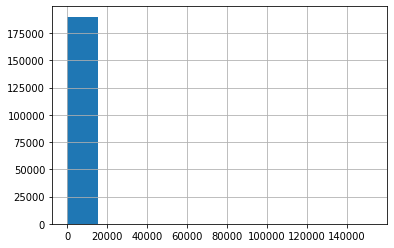

In [108]:
train_data.cases.hist()

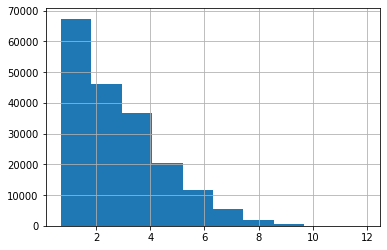

In [109]:
train_data.cases.apply(lambda x: np.log(x + 1)).hist()

In [134]:
features = ['material', 'plant_code', 'mrp_desc', 'group2_desc', 'group3_desc', 'est_lead_time', 'day', 'year', 'weekyear']
categorical_features = ['material', 'plant_code', 'mrp_desc', 'group2_desc', 'group3_desc', 'day', 'year', 'weekyear']

train_data = data[(data.value >= 1) & (data.cases >= 1) & (data.year >= 2017)]
train_data = train_data[np.abs(zscore(train_data.cases.apply(lambda x: np.log(x + 1))) < 2.576)]
x_train, x_val, y_train, y_val = train_test_split(train_data[features], train_data.cases.apply(lambda x: np.log(x+1)))
cat = CatBoostRegressor()
cat.fit(x_train, y_train, cat_features=categorical_features)

0:	learn: 3.0359536	total: 138ms	remaining: 2m 17s
1:	learn: 2.9653781	total: 252ms	remaining: 2m 5s
2:	learn: 2.8965540	total: 500ms	remaining: 2m 46s
3:	learn: 2.8309578	total: 653ms	remaining: 2m 42s
4:	learn: 2.7677729	total: 906ms	remaining: 3m
5:	learn: 2.7071104	total: 1.02s	remaining: 2m 49s
6:	learn: 2.6473505	total: 1.36s	remaining: 3m 13s
7:	learn: 2.5906947	total: 1.53s	remaining: 3m 10s
8:	learn: 2.5352643	total: 1.75s	remaining: 3m 13s
9:	learn: 2.4826242	total: 1.88s	remaining: 3m 6s
10:	learn: 2.4316428	total: 2.12s	remaining: 3m 10s
11:	learn: 2.3829523	total: 2.25s	remaining: 3m 5s
12:	learn: 2.3356921	total: 2.48s	remaining: 3m 8s
13:	learn: 2.2903782	total: 2.68s	remaining: 3m 8s
14:	learn: 2.2470727	total: 2.91s	remaining: 3m 10s
15:	learn: 2.2060834	total: 3.05s	remaining: 3m 7s
16:	learn: 2.1662795	total: 3.29s	remaining: 3m 10s
17:	learn: 2.1282948	total: 3.45s	remaining: 3m 8s
18:	learn: 2.0916459	total: 3.66s	remaining: 3m 9s
19:	learn: 2.0564152	total: 3.81s	

158:	learn: 1.2353748	total: 29.2s	remaining: 2m 34s
159:	learn: 1.2351072	total: 29.3s	remaining: 2m 33s
160:	learn: 1.2348531	total: 29.4s	remaining: 2m 33s
161:	learn: 1.2346295	total: 29.6s	remaining: 2m 32s
162:	learn: 1.2343377	total: 29.8s	remaining: 2m 32s
163:	learn: 1.2340468	total: 30s	remaining: 2m 32s
164:	learn: 1.2338633	total: 30.2s	remaining: 2m 32s
165:	learn: 1.2335440	total: 30.4s	remaining: 2m 32s
166:	learn: 1.2331426	total: 30.6s	remaining: 2m 32s
167:	learn: 1.2327576	total: 30.7s	remaining: 2m 31s
168:	learn: 1.2325331	total: 30.9s	remaining: 2m 32s
169:	learn: 1.2321609	total: 31s	remaining: 2m 31s
170:	learn: 1.2319716	total: 31.2s	remaining: 2m 31s
171:	learn: 1.2316378	total: 31.4s	remaining: 2m 31s
172:	learn: 1.2313328	total: 31.5s	remaining: 2m 30s
173:	learn: 1.2310032	total: 31.7s	remaining: 2m 30s
174:	learn: 1.2307117	total: 31.9s	remaining: 2m 30s
175:	learn: 1.2304313	total: 32s	remaining: 2m 29s
176:	learn: 1.2301751	total: 32.3s	remaining: 2m 30s

314:	learn: 1.2104337	total: 58.6s	remaining: 2m 7s
315:	learn: 1.2103823	total: 58.8s	remaining: 2m 7s
316:	learn: 1.2103235	total: 59s	remaining: 2m 7s
317:	learn: 1.2102858	total: 59.1s	remaining: 2m 6s
318:	learn: 1.2102210	total: 59.3s	remaining: 2m 6s
319:	learn: 1.2101440	total: 59.5s	remaining: 2m 6s
320:	learn: 1.2100648	total: 59.7s	remaining: 2m 6s
321:	learn: 1.2098981	total: 59.9s	remaining: 2m 6s
322:	learn: 1.2098055	total: 1m	remaining: 2m 6s
323:	learn: 1.2097673	total: 1m	remaining: 2m 5s
324:	learn: 1.2097306	total: 1m	remaining: 2m 5s
325:	learn: 1.2096428	total: 1m	remaining: 2m 5s
326:	learn: 1.2095783	total: 1m	remaining: 2m 5s
327:	learn: 1.2095223	total: 1m 1s	remaining: 2m 5s
328:	learn: 1.2094561	total: 1m 1s	remaining: 2m 4s
329:	learn: 1.2093826	total: 1m 1s	remaining: 2m 4s
330:	learn: 1.2092907	total: 1m 1s	remaining: 2m 4s
331:	learn: 1.2092382	total: 1m 1s	remaining: 2m 4s
332:	learn: 1.2091966	total: 1m 1s	remaining: 2m 4s
333:	learn: 1.2091351	total: 

470:	learn: 1.2013757	total: 1m 28s	remaining: 1m 39s
471:	learn: 1.2013359	total: 1m 28s	remaining: 1m 38s
472:	learn: 1.2012916	total: 1m 28s	remaining: 1m 38s
473:	learn: 1.2012431	total: 1m 28s	remaining: 1m 38s
474:	learn: 1.2011789	total: 1m 29s	remaining: 1m 38s
475:	learn: 1.2011245	total: 1m 29s	remaining: 1m 38s
476:	learn: 1.2010451	total: 1m 29s	remaining: 1m 38s
477:	learn: 1.2009645	total: 1m 29s	remaining: 1m 37s
478:	learn: 1.2009327	total: 1m 29s	remaining: 1m 37s
479:	learn: 1.2008908	total: 1m 29s	remaining: 1m 37s
480:	learn: 1.2008236	total: 1m 30s	remaining: 1m 37s
481:	learn: 1.2007656	total: 1m 30s	remaining: 1m 37s
482:	learn: 1.2007263	total: 1m 30s	remaining: 1m 36s
483:	learn: 1.2006901	total: 1m 30s	remaining: 1m 36s
484:	learn: 1.2006007	total: 1m 30s	remaining: 1m 36s
485:	learn: 1.2005446	total: 1m 31s	remaining: 1m 36s
486:	learn: 1.2005208	total: 1m 31s	remaining: 1m 36s
487:	learn: 1.2004722	total: 1m 31s	remaining: 1m 36s
488:	learn: 1.2003993	total:

623:	learn: 1.1956584	total: 1m 56s	remaining: 1m 10s
624:	learn: 1.1956135	total: 1m 57s	remaining: 1m 10s
625:	learn: 1.1955668	total: 1m 57s	remaining: 1m 10s
626:	learn: 1.1955281	total: 1m 57s	remaining: 1m 9s
627:	learn: 1.1954993	total: 1m 57s	remaining: 1m 9s
628:	learn: 1.1954541	total: 1m 58s	remaining: 1m 9s
629:	learn: 1.1954377	total: 1m 58s	remaining: 1m 9s
630:	learn: 1.1954099	total: 1m 58s	remaining: 1m 9s
631:	learn: 1.1953741	total: 1m 58s	remaining: 1m 9s
632:	learn: 1.1953499	total: 1m 58s	remaining: 1m 8s
633:	learn: 1.1953165	total: 1m 58s	remaining: 1m 8s
634:	learn: 1.1952753	total: 1m 59s	remaining: 1m 8s
635:	learn: 1.1952389	total: 1m 59s	remaining: 1m 8s
636:	learn: 1.1952217	total: 1m 59s	remaining: 1m 8s
637:	learn: 1.1952075	total: 1m 59s	remaining: 1m 7s
638:	learn: 1.1951656	total: 1m 59s	remaining: 1m 7s
639:	learn: 1.1951438	total: 1m 59s	remaining: 1m 7s
640:	learn: 1.1951164	total: 2m	remaining: 1m 7s
641:	learn: 1.1950983	total: 2m	remaining: 1m 7

781:	learn: 1.1913676	total: 2m 25s	remaining: 40.7s
782:	learn: 1.1913422	total: 2m 26s	remaining: 40.5s
783:	learn: 1.1913331	total: 2m 26s	remaining: 40.3s
784:	learn: 1.1913206	total: 2m 26s	remaining: 40.1s
785:	learn: 1.1912974	total: 2m 26s	remaining: 39.9s
786:	learn: 1.1912518	total: 2m 26s	remaining: 39.7s
787:	learn: 1.1912277	total: 2m 26s	remaining: 39.5s
788:	learn: 1.1912175	total: 2m 27s	remaining: 39.3s
789:	learn: 1.1911888	total: 2m 27s	remaining: 39.1s
790:	learn: 1.1911721	total: 2m 27s	remaining: 38.9s
791:	learn: 1.1911643	total: 2m 27s	remaining: 38.8s
792:	learn: 1.1911489	total: 2m 27s	remaining: 38.6s
793:	learn: 1.1911249	total: 2m 27s	remaining: 38.4s
794:	learn: 1.1911041	total: 2m 28s	remaining: 38.2s
795:	learn: 1.1910894	total: 2m 28s	remaining: 38s
796:	learn: 1.1910464	total: 2m 28s	remaining: 37.8s
797:	learn: 1.1910344	total: 2m 28s	remaining: 37.6s
798:	learn: 1.1910087	total: 2m 28s	remaining: 37.5s
799:	learn: 1.1909681	total: 2m 29s	remaining: 3

937:	learn: 1.1881599	total: 2m 54s	remaining: 11.5s
938:	learn: 1.1881451	total: 2m 54s	remaining: 11.3s
939:	learn: 1.1881307	total: 2m 54s	remaining: 11.1s
940:	learn: 1.1881218	total: 2m 54s	remaining: 10.9s
941:	learn: 1.1881038	total: 2m 54s	remaining: 10.8s
942:	learn: 1.1880904	total: 2m 54s	remaining: 10.6s
943:	learn: 1.1880791	total: 2m 55s	remaining: 10.4s
944:	learn: 1.1880538	total: 2m 55s	remaining: 10.2s
945:	learn: 1.1880387	total: 2m 55s	remaining: 10s
946:	learn: 1.1880177	total: 2m 55s	remaining: 9.83s
947:	learn: 1.1879992	total: 2m 55s	remaining: 9.65s
948:	learn: 1.1879710	total: 2m 56s	remaining: 9.46s
949:	learn: 1.1879602	total: 2m 56s	remaining: 9.28s
950:	learn: 1.1879424	total: 2m 56s	remaining: 9.09s
951:	learn: 1.1879188	total: 2m 56s	remaining: 8.91s
952:	learn: 1.1879081	total: 2m 56s	remaining: 8.72s
953:	learn: 1.1878887	total: 2m 56s	remaining: 8.53s
954:	learn: 1.1878544	total: 2m 57s	remaining: 8.35s
955:	learn: 1.1878354	total: 2m 57s	remaining: 8

In [135]:
print("train MSE: {}".format(mean_squared_error(f(y_train), f(cat.predict(x_train)))))
print("valid. MSE: {}".format(mean_squared_error(f(y_val), f(cat.predict(x_val)))))

train MSE: 17363.129357488127
valid. MSE: 18339.78804251997


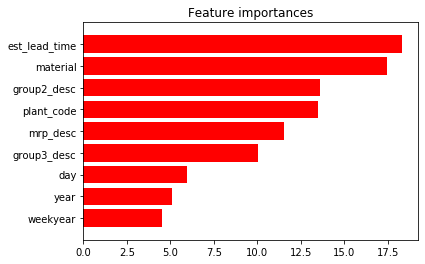

In [136]:
importances = cat.feature_importances_
indices = np.argsort(importances)

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.barh(range(x_train.shape[1]), importances[indices],
       color="r", align="center")
plt.yticks(range(x_train.shape[1]), [features[i] for i in indices])
plt.ylim([-1, x_train.shape[1]])
plt.show()

In [137]:
dic = {'y_val':f(y_val), 'y_pred':f(cat.predict(x_val))}
df_verification = pd.DataFrame(dic)
df_verification['error'] = abs(f(y_val) - f(cat.predict(x_val)))
df_verification = df_verification.sort_values(['error'], ascending=False)
df_verification[::1500]

y_val      y_pred        error
179717  1225.0    9.039433  1215.960567
64958    596.0  218.943822   377.056178
143856   202.0   15.437032   186.562968
100739   125.0   10.263631   114.736369
63262     76.0  155.225400    79.225400
191072    60.0    5.147243    54.852757
185691    50.0    9.384070    40.615930
190448    36.0    4.338097    31.661903
56175      4.0   29.450405    25.450405
176216     7.0   27.953262    20.953262
11400     32.0   14.356453    17.643547
58551      2.0   17.070177    15.070177
7570      20.0    6.993475    13.006525
91055      4.0   15.298216    11.298216
45087      7.0   16.915738     9.915738
159108     7.0   15.741354     8.741354
11836      1.0    8.723208     7.723208
19523     40.0   33.176824     6.823176
178929     1.0    7.042740     6.042740
102998     1.0    6.365419     5.365419
45262      8.0   12.744244     4.744244
94677     18.0   13.838511     4.161489
175197     8.0   11.641321     3.641321
95726      1.0    4.145698     3.145698
159687    12.0    9.297289     2.702711
39416     21.0   18.706538     2.293462
190417     2.0    3.907874     1.907874
154140     4.0    5.548812     1.548812
73501      4.0    5.186988     1.186988
165026     3.0    3.816334     0.816334
153845     4.0    3.565299     0.434701
113024     3.0    3.044985     0.044985

Working with `cases` as values lets the MSE reduce significantly also in comparison to the approx value/case. Hence, this was the right step. Nevertheless, a MSE >40k cases is still very bad. Let's look a little bit more into the data. As seen before there are significant outliers when it comes to amount of cases per sales order. I will try increase our alpha to 0.025 (both-sided).

In [130]:
features = ['material', 'plant_code', 'mrp_desc', 'group2_desc', 'group3_desc', 'est_lead_time', 'day', 'year', 'weekyear']
categorical_features = ['material', 'plant_code', 'mrp_desc', 'group2_desc', 'group3_desc', 'day', 'year', 'weekyear']

train_data = data[(data.value >= 1) & (data.cases >= 1) & (data.year >= 2017)]
train_data = train_data[np.abs(zscore(train_data.cases.apply(lambda x: np.log(x + 1))) < 1.96)]
x_train, x_val, y_train, y_val = train_test_split(train_data[features], train_data.cases.apply(lambda x: np.log(x+1)))
cat = CatBoostRegressor()
cat.fit(x_train, y_train, cat_features=categorical_features)

0:	learn: 2.8585877	total: 189ms	remaining: 3m 8s
1:	learn: 2.7907011	total: 327ms	remaining: 2m 43s
2:	learn: 2.7253913	total: 583ms	remaining: 3m 13s
3:	learn: 2.6625701	total: 691ms	remaining: 2m 52s
4:	learn: 2.6020122	total: 884ms	remaining: 2m 56s
5:	learn: 2.5441732	total: 979ms	remaining: 2m 42s
6:	learn: 2.4883790	total: 1.23s	remaining: 2m 53s
7:	learn: 2.4342967	total: 1.38s	remaining: 2m 51s
8:	learn: 2.3818287	total: 1.59s	remaining: 2m 55s
9:	learn: 2.3316402	total: 1.71s	remaining: 2m 48s
10:	learn: 2.2843147	total: 1.81s	remaining: 2m 42s
11:	learn: 2.2378126	total: 2.1s	remaining: 2m 52s
12:	learn: 2.1945373	total: 2.17s	remaining: 2m 44s
13:	learn: 2.1518162	total: 2.32s	remaining: 2m 43s
14:	learn: 2.1109398	total: 2.58s	remaining: 2m 49s
15:	learn: 2.0718497	total: 2.77s	remaining: 2m 50s
16:	learn: 2.0342897	total: 2.99s	remaining: 2m 52s
17:	learn: 1.9980778	total: 3.19s	remaining: 2m 53s
18:	learn: 1.9633524	total: 3.36s	remaining: 2m 53s
19:	learn: 1.9296404	tot

159:	learn: 1.1487831	total: 35.4s	remaining: 3m 5s
160:	learn: 1.1486055	total: 35.6s	remaining: 3m 5s
161:	learn: 1.1483266	total: 35.9s	remaining: 3m 5s
162:	learn: 1.1481307	total: 36.1s	remaining: 3m 5s
163:	learn: 1.1479420	total: 36.3s	remaining: 3m 4s
164:	learn: 1.1476699	total: 36.5s	remaining: 3m 4s
165:	learn: 1.1474112	total: 36.8s	remaining: 3m 4s
166:	learn: 1.1471317	total: 37s	remaining: 3m 4s
167:	learn: 1.1468411	total: 37.2s	remaining: 3m 4s
168:	learn: 1.1466048	total: 37.5s	remaining: 3m 4s
169:	learn: 1.1463815	total: 37.7s	remaining: 3m 3s
170:	learn: 1.1462251	total: 37.9s	remaining: 3m 3s
171:	learn: 1.1459909	total: 38s	remaining: 3m 2s
172:	learn: 1.1458222	total: 38.2s	remaining: 3m 2s
173:	learn: 1.1456950	total: 38.4s	remaining: 3m 2s
174:	learn: 1.1454537	total: 38.6s	remaining: 3m 1s
175:	learn: 1.1452283	total: 38.8s	remaining: 3m 1s
176:	learn: 1.1449918	total: 39.2s	remaining: 3m 2s
177:	learn: 1.1447494	total: 39.3s	remaining: 3m 1s
178:	learn: 1.14

315:	learn: 1.1307552	total: 1m 9s	remaining: 2m 30s
316:	learn: 1.1307109	total: 1m 9s	remaining: 2m 30s
317:	learn: 1.1306520	total: 1m 10s	remaining: 2m 30s
318:	learn: 1.1305643	total: 1m 10s	remaining: 2m 30s
319:	learn: 1.1304916	total: 1m 10s	remaining: 2m 30s
320:	learn: 1.1304033	total: 1m 10s	remaining: 2m 29s
321:	learn: 1.1303445	total: 1m 11s	remaining: 2m 29s
322:	learn: 1.1302952	total: 1m 11s	remaining: 2m 29s
323:	learn: 1.1302291	total: 1m 11s	remaining: 2m 29s
324:	learn: 1.1301925	total: 1m 11s	remaining: 2m 29s
325:	learn: 1.1301165	total: 1m 12s	remaining: 2m 28s
326:	learn: 1.1300254	total: 1m 12s	remaining: 2m 28s
327:	learn: 1.1299864	total: 1m 12s	remaining: 2m 28s
328:	learn: 1.1299298	total: 1m 12s	remaining: 2m 28s
329:	learn: 1.1298793	total: 1m 13s	remaining: 2m 28s
330:	learn: 1.1298312	total: 1m 13s	remaining: 2m 28s
331:	learn: 1.1297944	total: 1m 13s	remaining: 2m 28s
332:	learn: 1.1297566	total: 1m 14s	remaining: 2m 28s
333:	learn: 1.1296976	total: 1

469:	learn: 1.1233633	total: 1m 44s	remaining: 1m 58s
470:	learn: 1.1233211	total: 1m 45s	remaining: 1m 58s
471:	learn: 1.1232778	total: 1m 45s	remaining: 1m 58s
472:	learn: 1.1232216	total: 1m 45s	remaining: 1m 57s
473:	learn: 1.1232047	total: 1m 46s	remaining: 1m 57s
474:	learn: 1.1231695	total: 1m 46s	remaining: 1m 57s
475:	learn: 1.1231083	total: 1m 46s	remaining: 1m 57s
476:	learn: 1.1230831	total: 1m 46s	remaining: 1m 57s
477:	learn: 1.1230612	total: 1m 47s	remaining: 1m 56s
478:	learn: 1.1230059	total: 1m 47s	remaining: 1m 56s
479:	learn: 1.1229779	total: 1m 47s	remaining: 1m 56s
480:	learn: 1.1229245	total: 1m 47s	remaining: 1m 56s
481:	learn: 1.1229118	total: 1m 48s	remaining: 1m 56s
482:	learn: 1.1228717	total: 1m 48s	remaining: 1m 55s
483:	learn: 1.1227932	total: 1m 48s	remaining: 1m 55s
484:	learn: 1.1227435	total: 1m 48s	remaining: 1m 55s
485:	learn: 1.1227251	total: 1m 48s	remaining: 1m 55s
486:	learn: 1.1226987	total: 1m 49s	remaining: 1m 55s
487:	learn: 1.1226426	total:

622:	learn: 1.1182826	total: 2m 20s	remaining: 1m 24s
623:	learn: 1.1182465	total: 2m 20s	remaining: 1m 24s
624:	learn: 1.1182188	total: 2m 20s	remaining: 1m 24s
625:	learn: 1.1181926	total: 2m 20s	remaining: 1m 24s
626:	learn: 1.1181707	total: 2m 21s	remaining: 1m 23s
627:	learn: 1.1181269	total: 2m 21s	remaining: 1m 23s
628:	learn: 1.1181125	total: 2m 21s	remaining: 1m 23s
629:	learn: 1.1180908	total: 2m 21s	remaining: 1m 23s
630:	learn: 1.1180661	total: 2m 21s	remaining: 1m 22s
631:	learn: 1.1180419	total: 2m 22s	remaining: 1m 22s
632:	learn: 1.1180073	total: 2m 22s	remaining: 1m 22s
633:	learn: 1.1179824	total: 2m 22s	remaining: 1m 22s
634:	learn: 1.1179438	total: 2m 22s	remaining: 1m 21s
635:	learn: 1.1179057	total: 2m 22s	remaining: 1m 21s
636:	learn: 1.1178951	total: 2m 22s	remaining: 1m 21s
637:	learn: 1.1178677	total: 2m 23s	remaining: 1m 21s
638:	learn: 1.1178308	total: 2m 23s	remaining: 1m 21s
639:	learn: 1.1178062	total: 2m 24s	remaining: 1m 21s
640:	learn: 1.1177980	total:

778:	learn: 1.1145511	total: 3m 1s	remaining: 51.6s
779:	learn: 1.1145275	total: 3m 2s	remaining: 51.4s
780:	learn: 1.1145000	total: 3m 2s	remaining: 51.2s
781:	learn: 1.1144752	total: 3m 2s	remaining: 51s
782:	learn: 1.1144469	total: 3m 3s	remaining: 50.7s
783:	learn: 1.1144307	total: 3m 3s	remaining: 50.5s
784:	learn: 1.1144117	total: 3m 3s	remaining: 50.2s
785:	learn: 1.1144001	total: 3m 3s	remaining: 50s
786:	learn: 1.1143840	total: 3m 3s	remaining: 49.7s
787:	learn: 1.1143512	total: 3m 3s	remaining: 49.5s
788:	learn: 1.1143237	total: 3m 4s	remaining: 49.2s
789:	learn: 1.1143133	total: 3m 4s	remaining: 49s
790:	learn: 1.1142845	total: 3m 4s	remaining: 48.8s
791:	learn: 1.1142672	total: 3m 4s	remaining: 48.5s
792:	learn: 1.1142580	total: 3m 4s	remaining: 48.3s
793:	learn: 1.1142451	total: 3m 5s	remaining: 48s
794:	learn: 1.1142091	total: 3m 5s	remaining: 47.8s
795:	learn: 1.1141932	total: 3m 5s	remaining: 47.5s
796:	learn: 1.1141756	total: 3m 5s	remaining: 47.3s
797:	learn: 1.114157

936:	learn: 1.1115483	total: 3m 32s	remaining: 14.3s
937:	learn: 1.1115392	total: 3m 33s	remaining: 14.1s
938:	learn: 1.1115076	total: 3m 33s	remaining: 13.9s
939:	learn: 1.1114890	total: 3m 33s	remaining: 13.6s
940:	learn: 1.1114744	total: 3m 33s	remaining: 13.4s
941:	learn: 1.1114616	total: 3m 33s	remaining: 13.2s
942:	learn: 1.1114426	total: 3m 34s	remaining: 12.9s
943:	learn: 1.1114321	total: 3m 34s	remaining: 12.7s
944:	learn: 1.1114262	total: 3m 34s	remaining: 12.5s
945:	learn: 1.1114178	total: 3m 34s	remaining: 12.3s
946:	learn: 1.1114034	total: 3m 34s	remaining: 12s
947:	learn: 1.1113968	total: 3m 35s	remaining: 11.8s
948:	learn: 1.1113891	total: 3m 35s	remaining: 11.6s
949:	learn: 1.1113788	total: 3m 35s	remaining: 11.3s
950:	learn: 1.1113643	total: 3m 35s	remaining: 11.1s
951:	learn: 1.1113578	total: 3m 35s	remaining: 10.9s
952:	learn: 1.1113362	total: 3m 36s	remaining: 10.7s
953:	learn: 1.1113173	total: 3m 36s	remaining: 10.4s
954:	learn: 1.1113109	total: 3m 36s	remaining: 1

In [131]:
print("train MSE: {}".format(mean_squared_error(f(y_train), f(cat.predict(x_train)))))
print("valid. MSE: {}".format(mean_squared_error(f(y_val), f(cat.predict(x_val)))))

train MSE: 4011.4681499744815
valid. MSE: 3963.114684989614


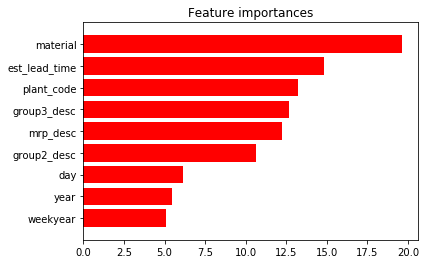

In [132]:
importances = cat.feature_importances_
indices = np.argsort(importances)

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.barh(range(x_train.shape[1]), importances[indices],
       color="r", align="center")
plt.yticks(range(x_train.shape[1]), [features[i] for i in indices])
plt.ylim([-1, x_train.shape[1]])
plt.show()

In [133]:
dic = {'y_val':f(y_val), 'y_pred':f(cat.predict(x_val))}
df_verification = pd.DataFrame(dic)
df_verification['error'] = abs(f(y_val) - f(cat.predict(x_val)))
df_verification = df_verification.sort_values(['error'], ascending=False)
df_verification[::1500]

y_val     y_pred       error
98632   438.0  11.383057  426.616943
115697  200.0   8.100372  191.899628
52592   125.0  14.396472  110.603528
9441    113.0  39.889609   73.110391
9206     85.0  35.323136   49.676864
37185    50.0  13.413005   36.586995
51722    15.0  42.747418   27.747418
188409    2.0  24.383804   22.383804
106566   30.0  11.198372   18.801628
2542     30.0  14.011819   15.988181
130276    9.0  22.795835   13.795835
74723    18.0   6.034223   11.965777
156839    6.0  16.462153   10.462153
167750    1.0  10.154438    9.154438
32215    24.0  32.065661    8.065661
129296   14.0  21.173322    7.173322
169297   25.0  18.627342    6.372658
84845     4.0   9.642817    5.642817
5203     15.0  19.996954    4.996954
171137    5.0   9.427080    4.427080
156284    2.0   5.886980    3.886980
159187    3.0   6.411261    3.411261
127964   22.0  24.981125    2.981125
101958    1.0   3.562043    2.562043
13719    10.0   7.825404    2.174596
85050     5.0   3.192183    1.807817
127667    1.0   2.472731    1.472731
84519     8.0   6.865483    1.134517
69877     5.0   5.768651    0.768651
117141   10.0   9.598800    0.401200
12234     8.0   8.031831    0.031831

Changing the z-score accordingly we receive way better results. Let's look at the data.

In [142]:
train_data.cases.describe()

count    180484.000000
mean         36.757109
std          69.226642
min           1.000000
25%           3.000000
50%          10.000000
75%          32.000000
max         439.000000
Name: cases, dtype: float64

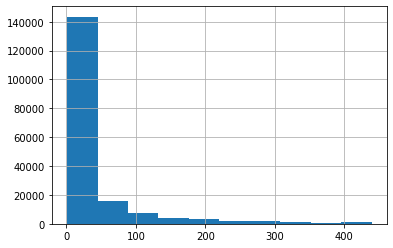

In [143]:
train_data.cases.hist()

We still have 180,484 values in our `training_data`. Nevertheless, we can see that our model still has issues predicting the outlier values.

There are two more ideas which can be applied to see whether data can be predicted better:
    1: downsampling
    2: weights based on amount of cases

In [144]:
train_data_low = train_data[(train_data.cases <= 100)]
train_data_high = train_data[(train_data.cases > 100)]

In [145]:
train_data_low.describe()

cases          value          f_day          adbno  \
count  162012.000000  162012.000000  162012.000000  162012.000000   
mean       16.724212    1222.727735     242.492643       6.836703   
std        21.460159    2130.670910     146.059803      12.608281   
min         1.000000       1.000000       2.000000       1.000000   
25%         3.000000     236.640000     118.000000       2.000000   
50%         8.000000     564.960000     222.000000       4.000000   
75%        21.000000    1356.340000     360.000000       7.000000   
max       100.000000  109419.000000     562.000000     584.000000   

       service_level  est_lead_time         IS_HOL          month  \
count  162012.000000  162012.000000  162012.000000  162012.000000   
mean        0.947286      59.830864       0.029214       6.219533   
std         0.009111      20.191191       0.168406       3.566372   
min         0.850000      16.000000       0.000000       1.000000   
25%         0.950000      50.000000       0.000000       3.000000   
50%         0.950000      69.000000       0.000000       6.000000   
75%         0.950000      71.000000       0.000000       9.000000   
max         0.990000     120.000000       1.000000      12.000000   

                year      log_cases       weekyear  
count  162012.000000  162012.000000  162012.000000  
mean     2017.639533       2.050595      25.287349  
std         0.621778       1.290214      15.483870  
min      2017.000000       0.000000       1.000000  
25%      2017.000000       1.098612      11.000000  
50%      2018.000000       2.079442      25.000000  
75%      2018.000000       3.044522      39.000000  
max      2019.000000       4.605170      52.000000

In [146]:
train_data_high.describe()

cases          value         f_day         adbno  service_level  \
count  18472.000000   18472.000000  18472.000000  18472.000000   18472.000000   
mean     212.459236    7339.304767    372.912300      4.303216       0.949235   
std       91.620018    9307.182808    157.509243     12.177012       0.005017   
min      101.000000      39.300000      2.000000      1.000000       0.850000   
25%      134.000000    1106.625000    262.000000      2.000000       0.950000   
50%      191.000000    3601.700000    397.000000      2.000000       0.950000   
75%      275.000000   10961.845000    517.000000      3.000000       0.950000   
max      439.000000  218838.000000    562.000000    632.000000       0.990000   

       est_lead_time        IS_HOL         month          year     log_cases  \
count   18472.000000  18472.000000  18472.000000  18472.000000  18472.000000   
mean       68.868125      0.031291      5.923235   2017.593330      5.270167   
std        16.596194      0.174107      3.605282      0.620735      0.417842   
min        16.000000      0.000000      1.000000   2017.000000      4.615121   
25%        68.000000      0.000000      3.000000   2017.000000      4.897840   
50%        69.000000      0.000000      6.000000   2018.000000      5.252273   
75%        71.000000      0.000000      9.000000   2018.000000      5.616771   
max       120.000000      1.000000     12.000000   2019.000000      6.084499   

           weekyear  
count  18472.000000  
mean      23.991013  
std       15.660698  
min        1.000000  
25%        9.000000  
50%       23.000000  
75%       38.000000  
max       52.000000

In [147]:
train_data_low_selection = train_data_low.sample(n=18472)

In [148]:
train_data_low_selection.describe()

cases         value         f_day         adbno  service_level  \
count  18472.000000  18472.000000  18472.000000  18472.000000   18472.000000   
mean      16.703064   1219.415096    243.695323      6.671503       0.947285   
std       21.399688   2063.118572    145.229300     12.151349       0.009093   
min        1.000000      1.250000      2.000000      1.000000       0.850000   
25%        3.000000    237.495000    122.000000      2.000000       0.950000   
50%        8.000000    564.960000    224.000000      4.000000       0.950000   
75%       20.000000   1336.340000    360.000000      6.000000       0.950000   
max      100.000000  72216.540000    562.000000    391.000000       0.990000   

       est_lead_time        IS_HOL         month          year     log_cases  \
count   18472.000000  18472.000000  18472.000000  18472.000000  18472.000000   
mean       59.881929      0.030912      6.230944   2017.640158      2.053712   
std        20.122998      0.173083      3.582004      0.621434      1.286983   
min        16.000000      0.000000      1.000000   2017.000000      0.000000   
25%        50.000000      0.000000      3.000000   2017.000000      1.098612   
50%        69.000000      0.000000      6.000000   2018.000000      2.079442   
75%        71.000000      0.000000      9.000000   2018.000000      2.995732   
max       120.000000      1.000000     12.000000   2019.000000      4.605170   

           weekyear  
count  18472.000000  
mean      25.324437  
std       15.553615  
min        1.000000  
25%       10.000000  
50%       25.000000  
75%       39.000000  
max       52.000000

In [149]:
train_data_new = pd.concat([train_data_low_selection, train_data_high])

In [150]:
train_data_new.describe()

cases          value         f_day         adbno  service_level  \
count  36944.000000   36944.000000  36944.000000  36944.000000   36944.000000   
mean     114.581150    4279.359932    308.303811      5.487359       0.948260   
std      118.348411    7402.860317    164.693971     12.221525       0.007408   
min        1.000000       1.250000      2.000000      1.000000       0.850000   
25%        8.000000     468.540000    171.000000      2.000000       0.950000   
50%      100.500000    1221.190000    316.000000      3.000000       0.950000   
75%      191.000000    4712.232500    443.000000      5.000000       0.950000   
max      439.000000  218838.000000    562.000000    632.000000       0.990000   

       est_lead_time        IS_HOL         month          year     log_cases  \
count   36944.000000  36944.000000  36944.000000  36944.000000  36944.000000   
mean       64.375027      0.031101      6.077090   2017.616744      3.661939   
std        18.983246      0.173593      3.596905      0.621517      1.871336   
min        16.000000      0.000000      1.000000   2017.000000      0.000000   
25%        66.000000      0.000000      3.000000   2017.000000      2.079442   
50%        69.000000      0.000000      6.000000   2018.000000      4.610145   
75%        71.000000      0.000000      9.000000   2018.000000      5.252273   
max       120.000000      1.000000     12.000000   2019.000000      6.084499   

           weekyear  
count  36944.000000  
mean      24.657725  
std       15.621271  
min        1.000000  
25%       10.000000  
50%       24.000000  
75%       39.000000  
max       52.000000

In [151]:
x_train, x_val, y_train, y_val = train_test_split(train_data_new[features], train_data_new.cases.apply(lambda x: np.log(x+1)))
cat4 = CatBoostRegressor()
cat4.fit(x_train, y_train, cat_features=categorical_features)
y_pred = cat4.predict(x_val)
print("MSE of log: {}".format(mean_squared_error(y_val, y_pred)))
print("MSE of not log: {}".format(mean_squared_error(f(y_val), f(y_pred))))

0:	learn: 4.0346768	total: 52.3ms	remaining: 52.2s
1:	learn: 3.9326451	total: 135ms	remaining: 1m 7s
2:	learn: 3.8336205	total: 215ms	remaining: 1m 11s
3:	learn: 3.7383838	total: 361ms	remaining: 1m 29s
4:	learn: 3.6466219	total: 430ms	remaining: 1m 25s
5:	learn: 3.5589418	total: 493ms	remaining: 1m 21s
6:	learn: 3.4743175	total: 535ms	remaining: 1m 15s
7:	learn: 3.3928289	total: 585ms	remaining: 1m 12s
8:	learn: 3.3129275	total: 714ms	remaining: 1m 18s
9:	learn: 3.2369162	total: 751ms	remaining: 1m 14s
10:	learn: 3.1627683	total: 857ms	remaining: 1m 17s
11:	learn: 3.0914150	total: 938ms	remaining: 1m 17s
12:	learn: 3.0230444	total: 1.03s	remaining: 1m 17s
13:	learn: 2.9568687	total: 1.19s	remaining: 1m 23s
14:	learn: 2.8920147	total: 1.27s	remaining: 1m 23s
15:	learn: 2.8301556	total: 1.35s	remaining: 1m 22s
16:	learn: 2.7710258	total: 1.47s	remaining: 1m 24s
17:	learn: 2.7152617	total: 1.53s	remaining: 1m 23s
18:	learn: 2.6607174	total: 1.61s	remaining: 1m 22s
19:	learn: 2.6078028	to

158:	learn: 1.3523487	total: 15.4s	remaining: 1m 21s
159:	learn: 1.3515789	total: 15.5s	remaining: 1m 21s
160:	learn: 1.3508032	total: 15.5s	remaining: 1m 21s
161:	learn: 1.3501249	total: 15.6s	remaining: 1m 20s
162:	learn: 1.3494679	total: 15.7s	remaining: 1m 20s
163:	learn: 1.3489862	total: 15.8s	remaining: 1m 20s
164:	learn: 1.3486329	total: 15.9s	remaining: 1m 20s
165:	learn: 1.3478264	total: 16s	remaining: 1m 20s
166:	learn: 1.3474165	total: 16.1s	remaining: 1m 20s
167:	learn: 1.3467511	total: 16.2s	remaining: 1m 20s
168:	learn: 1.3465461	total: 16.3s	remaining: 1m 20s
169:	learn: 1.3458839	total: 16.4s	remaining: 1m 19s
170:	learn: 1.3454289	total: 16.5s	remaining: 1m 19s
171:	learn: 1.3451189	total: 16.5s	remaining: 1m 19s
172:	learn: 1.3445776	total: 16.6s	remaining: 1m 19s
173:	learn: 1.3442139	total: 16.7s	remaining: 1m 19s
174:	learn: 1.3435749	total: 16.8s	remaining: 1m 19s
175:	learn: 1.3433450	total: 16.9s	remaining: 1m 19s
176:	learn: 1.3427325	total: 17s	remaining: 1m 1

316:	learn: 1.3134310	total: 29.3s	remaining: 1m 3s
317:	learn: 1.3133594	total: 29.3s	remaining: 1m 2s
318:	learn: 1.3131915	total: 29.4s	remaining: 1m 2s
319:	learn: 1.3131155	total: 29.5s	remaining: 1m 2s
320:	learn: 1.3131152	total: 29.5s	remaining: 1m 2s
321:	learn: 1.3130841	total: 29.6s	remaining: 1m 2s
322:	learn: 1.3130380	total: 29.7s	remaining: 1m 2s
323:	learn: 1.3129624	total: 29.8s	remaining: 1m 2s
324:	learn: 1.3128332	total: 29.9s	remaining: 1m 2s
325:	learn: 1.3127397	total: 29.9s	remaining: 1m 1s
326:	learn: 1.3126864	total: 30s	remaining: 1m 1s
327:	learn: 1.3126128	total: 30.1s	remaining: 1m 1s
328:	learn: 1.3125607	total: 30.2s	remaining: 1m 1s
329:	learn: 1.3123394	total: 30.3s	remaining: 1m 1s
330:	learn: 1.3122483	total: 30.4s	remaining: 1m 1s
331:	learn: 1.3122280	total: 30.4s	remaining: 1m 1s
332:	learn: 1.3121505	total: 30.5s	remaining: 1m 1s
333:	learn: 1.3118629	total: 30.6s	remaining: 1m 1s
334:	learn: 1.3115677	total: 30.7s	remaining: 1m
335:	learn: 1.311

477:	learn: 1.2978130	total: 43.2s	remaining: 47.1s
478:	learn: 1.2977854	total: 43.2s	remaining: 47s
479:	learn: 1.2977297	total: 43.3s	remaining: 46.9s
480:	learn: 1.2977022	total: 43.3s	remaining: 46.8s
481:	learn: 1.2976830	total: 43.5s	remaining: 46.7s
482:	learn: 1.2976769	total: 43.5s	remaining: 46.6s
483:	learn: 1.2976312	total: 43.6s	remaining: 46.5s
484:	learn: 1.2975659	total: 43.7s	remaining: 46.4s
485:	learn: 1.2974646	total: 43.8s	remaining: 46.3s
486:	learn: 1.2973092	total: 43.9s	remaining: 46.2s
487:	learn: 1.2972682	total: 44s	remaining: 46.1s
488:	learn: 1.2972004	total: 44.1s	remaining: 46s
489:	learn: 1.2971471	total: 44.1s	remaining: 45.9s
490:	learn: 1.2971114	total: 44.2s	remaining: 45.9s
491:	learn: 1.2970030	total: 44.3s	remaining: 45.8s
492:	learn: 1.2969874	total: 44.4s	remaining: 45.7s
493:	learn: 1.2969512	total: 44.5s	remaining: 45.6s
494:	learn: 1.2968664	total: 44.6s	remaining: 45.5s
495:	learn: 1.2967936	total: 44.6s	remaining: 45.4s
496:	learn: 1.2967

637:	learn: 1.2898190	total: 57.7s	remaining: 32.7s
638:	learn: 1.2897837	total: 57.8s	remaining: 32.7s
639:	learn: 1.2897341	total: 58s	remaining: 32.6s
640:	learn: 1.2897073	total: 58.1s	remaining: 32.5s
641:	learn: 1.2897058	total: 58.1s	remaining: 32.4s
642:	learn: 1.2897058	total: 58.1s	remaining: 32.3s
643:	learn: 1.2896900	total: 58.2s	remaining: 32.2s
644:	learn: 1.2896488	total: 58.3s	remaining: 32.1s
645:	learn: 1.2895028	total: 58.4s	remaining: 32s
646:	learn: 1.2894638	total: 58.5s	remaining: 31.9s
647:	learn: 1.2894622	total: 58.6s	remaining: 31.9s
648:	learn: 1.2894595	total: 58.8s	remaining: 31.8s
649:	learn: 1.2894492	total: 58.9s	remaining: 31.7s
650:	learn: 1.2894403	total: 59s	remaining: 31.6s
651:	learn: 1.2893343	total: 59.1s	remaining: 31.6s
652:	learn: 1.2893169	total: 59.2s	remaining: 31.5s
653:	learn: 1.2893126	total: 59.4s	remaining: 31.4s
654:	learn: 1.2893096	total: 59.6s	remaining: 31.4s
655:	learn: 1.2893071	total: 59.7s	remaining: 31.3s
656:	learn: 1.2892

796:	learn: 1.2845257	total: 1m 11s	remaining: 18.1s
797:	learn: 1.2845223	total: 1m 11s	remaining: 18.1s
798:	learn: 1.2844933	total: 1m 11s	remaining: 18s
799:	learn: 1.2844919	total: 1m 11s	remaining: 17.9s
800:	learn: 1.2844919	total: 1m 11s	remaining: 17.8s
801:	learn: 1.2844415	total: 1m 11s	remaining: 17.7s
802:	learn: 1.2844348	total: 1m 11s	remaining: 17.6s
803:	learn: 1.2844345	total: 1m 11s	remaining: 17.5s
804:	learn: 1.2844310	total: 1m 11s	remaining: 17.4s
805:	learn: 1.2844310	total: 1m 11s	remaining: 17.3s
806:	learn: 1.2844281	total: 1m 11s	remaining: 17.2s
807:	learn: 1.2843576	total: 1m 12s	remaining: 17.1s
808:	learn: 1.2843502	total: 1m 12s	remaining: 17s
809:	learn: 1.2842802	total: 1m 12s	remaining: 16.9s
810:	learn: 1.2841985	total: 1m 12s	remaining: 16.8s
811:	learn: 1.2841931	total: 1m 12s	remaining: 16.8s
812:	learn: 1.2841817	total: 1m 12s	remaining: 16.7s
813:	learn: 1.2841789	total: 1m 12s	remaining: 16.6s
814:	learn: 1.2841756	total: 1m 12s	remaining: 16.

954:	learn: 1.2800250	total: 1m 23s	remaining: 3.94s
955:	learn: 1.2800235	total: 1m 23s	remaining: 3.85s
956:	learn: 1.2800105	total: 1m 23s	remaining: 3.76s
957:	learn: 1.2800083	total: 1m 23s	remaining: 3.68s
958:	learn: 1.2800074	total: 1m 23s	remaining: 3.59s
959:	learn: 1.2799984	total: 1m 23s	remaining: 3.5s
960:	learn: 1.2799869	total: 1m 24s	remaining: 3.41s
961:	learn: 1.2799851	total: 1m 24s	remaining: 3.32s
962:	learn: 1.2799533	total: 1m 24s	remaining: 3.23s
963:	learn: 1.2799251	total: 1m 24s	remaining: 3.15s
964:	learn: 1.2799115	total: 1m 24s	remaining: 3.06s
965:	learn: 1.2798295	total: 1m 24s	remaining: 2.97s
966:	learn: 1.2798173	total: 1m 24s	remaining: 2.88s
967:	learn: 1.2797783	total: 1m 24s	remaining: 2.79s
968:	learn: 1.2797671	total: 1m 24s	remaining: 2.71s
969:	learn: 1.2797110	total: 1m 24s	remaining: 2.62s
970:	learn: 1.2797017	total: 1m 24s	remaining: 2.53s
971:	learn: 1.2796688	total: 1m 24s	remaining: 2.44s
972:	learn: 1.2796548	total: 1m 24s	remaining: 

In [155]:
features

['material',
 'plant_code',
 'mrp_desc',
 'group2_desc',
 'group3_desc',
 'est_lead_time',
 'day',
 'year',
 'weekyear']

In [156]:
categorical_features

['material',
 'plant_code',
 'mrp_desc',
 'group2_desc',
 'group3_desc',
 'day',
 'year',
 'weekyear']

Using `CatBoost` we found the features we can now apply to train a simple `LinearRegression` or `RandomForest`. We will train both and compare the results.

In [187]:
dummy_variables = ['material', 'plant_code',
 'mrp_desc',
 'group2_desc',
 'group3_desc',
 'day',
 'year',
 'weekyear']
train_data = data[(data.value >= 1) & (data.cases >= 1) & (data.year >= 2017)]
dropped_columns = ['month', 'sku_class', 'group6_desc', 'service_level', 'IS_HOL', 'sales_date', 'f_day', 'adbno', 'product_description', 'log_cases']
train_data = train_data.drop(dropped_columns, axis=1)

for var in dummy_variables:
    dummy = pd.get_dummies(train_data[var], prefix=var, drop_first=False)
    train_data = pd.concat([train_data, dummy], axis=1)

train_data = train_data.drop(dummy_variables, axis=1)

train_data = train_data[np.abs(zscore(train_data.cases.apply(lambda x: np.log(x + 1))) < 1.96)]

to_drop = ['cases', 'value']
x_data = train_data.drop(['cases', 'value'], axis=1)
y_data = pd.DataFrame(data=train_data['cases'])

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data.cases.apply(lambda x: np.log(x+1)))

In [191]:
train_data.describe()

cases          value  est_lead_time  material_D13384914  \
count  180484.000000  180484.000000  180484.000000       180484.000000   
mean       36.757109    1848.741181      60.755801            0.002244   
std        69.226642    4046.918935      20.041222            0.047317   
min         1.000000       1.000000      16.000000            0.000000   
25%         3.000000     261.500000      66.000000            0.000000   
50%        10.000000     647.090000      69.000000            0.000000   
75%        32.000000    1659.340000      71.000000            0.000000   
max       439.000000  218838.000000     120.000000            1.000000   

       material_D13395853  material_D13395864  material_D13395927  \
count       180484.000000       180484.000000       180484.000000   
mean             0.000183            0.000249            0.001723   
std              0.013521            0.015788            0.041475   
min              0.000000            0.000000            0.000000   
25%              0.000000            0.000000            0.000000   
50%              0.000000            0.000000            0.000000   
75%              0.000000            0.000000            0.000000   
max              1.000000            1.000000            1.000000   

       material_D13395945  material_D13395960  material_D13395979  ...  \
count       180484.000000       180484.000000       180484.000000  ...   
mean             0.003430            0.002455            0.002981  ...   
std              0.058463            0.049482            0.054516  ...   
min              0.000000            0.000000            0.000000  ...   
25%              0.000000            0.000000            0.000000  ...   
50%              0.000000            0.000000            0.000000  ...   
75%              0.000000            0.000000            0.000000  ...   
max              1.000000            1.000000            1.000000  ...   

         weekyear_43    weekyear_44    weekyear_45    weekyear_46  \
count  180484.000000  180484.000000  180484.000000  180484.000000   
mean        0.018373       0.017575       0.020495       0.019946   
std         0.134296       0.131401       0.141686       0.139816   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

         weekyear_47    weekyear_48    weekyear_49    weekyear_50  \
count  180484.000000  180484.000000  180484.000000  180484.000000   
mean        0.014129       0.017991       0.019996       0.020212   
std         0.118022       0.132917       0.139987       0.140726   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

         weekyear_51    weekyear_52  
count  180484.000000  180484.000000  
mean        0.019337       0.012295  
std         0.137707       0.110198  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000  

[8 rows x 1612 columns]

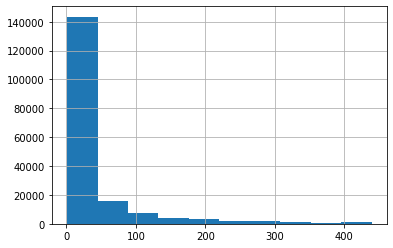

In [190]:
train_data.cases.hist()

In [188]:
#this is the LR for all materials in one model
lr_clf = LinearRegression().fit(x_train, y_train)
print("train MSE: {}".format(mean_squared_error(f(y_train), f(lr_clf.predict(x_train)))))
print("validation MSE: {}".format(mean_squared_error(f(y_val), f(lr_clf.predict(x_val)))))

train MSE: 4229.354533703899
validation MSE: 4325.63685775007


In [180]:
# this is the LR for only material D13398151
lr_clf = LinearRegression().fit(x_train, y_train)
print("train MSE: {}".format(mean_squared_error(f(y_train), f(lr_clf.predict(x_train)))))
print("validation MSE: {}".format(mean_squared_error(f(y_val), f(lr_clf.predict(x_val)))))

train MSE: 108219.64018659692
validation MSE: 172896.8390422385


In [184]:
import statsmodels


In [192]:
model = statsmodels.regression.linear_model.OLS(y_train, x_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  cases   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     43.35
Date:                Thu, 25 Jul 2019   Prob (F-statistic):               0.00
Time:                        17:19:26   Log-Likelihood:            -2.1015e+05
No. Observations:              135363   AIC:                         4.233e+05
Df Residuals:                  133855   BIC:                         4.381e+05
Df Model:                        1507                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
est_lead_time                             -0.0329      0.004     -7.664      0.000      -0.041      -0.024
material_D13384914                         2.2581      0.211     10.678      0.000       1.844       2.673
material_D13395853                        -0.0266      0.164     -0.162      0.871      -0.349       0.295
material_D13395864                         0.3548      0.151      2.346      0.019       0.058       0.651
material_D13395927                         0.6062      0.082      7.403      0.000       0.446       0.767
material_D13395945                         1.3125      0.061     21.429      0.000       1.192       1.433
material_D13395960                         0.8617      0.067     12.825      0.000       0.730       0.993
material_D13395979                         0.8540      0.064     13.418      0.000       0.729       0.979
material_D13395998                         0.3715      0.097      3.825      0.000       0.181       0.562
material_D13396008                         0.4128      0.133      3.101      0.002       0.152       0.674
material_D13396028                        -0.0232      0.098     -0.237      0.813      -0.216       0.169
material_D13396099                        -0.5599      0.083     -6.719      0.000      -0.723      -0.397
material_D13396273                        -0.7078      0.199     -3.555      0.000      -1.098      -0.318
material_D13396319                         0.1704      0.147      1.160      0.246      -0.117       0.458
material_D13396343                         0.0991      0.087      1.143      0.253      -0.071       0.269
material_D13396511                         1.8190      0.113     16.081      0.000       1.597       2.041
material_D13396521                         0.6861      0.101      6.769      0.000       0.487       0.885
material_D13396530                         1.0635      0.101     10.575      0.000       0.866       1.261
material_D13396600                        -0.2355      0.176     -1.336      0.181      -0.581       0.110
material_D13396614                         1.5419      0.114     13.538      0.000       1.319       1.765
material_D13396625                         0.5492      0.094      5.850      0.000       0.365       0.733
material_D13396667                         0.5170      0.089      5.816      0.000       0.343       0.691
material_D13396673                         1.2597      0.060     20.935      0.000       1.142       1.378
material_D13396694                         1.0735      0.062     17.178      0.000       0.951       1.196
material_D13396707                        -1.1243      0.105    -10.741      0.000      -1.329      -0.919
material_D13396719                         1.7623      0.110     15.956      0.000     

In [211]:
dummy_variables = [
 'day',
 'year',
 'weekyear']
train_data = data[(data.value >= 1) & (data.cases >= 1) & (data.year >= 2017) & (data.material == 'D13484454')]
dropped_columns = ['est_lead_time', 'plant_code',
 'mrp_desc',
 'group2_desc',
 'group3_desc','material', 'month', 'sku_class', 'group6_desc', 'service_level', 'sales_date', 'f_day', 'adbno', 'product_description', 'log_cases']
train_data = train_data.drop(dropped_columns, axis=1)

for var in dummy_variables:
    dummy = pd.get_dummies(train_data[var], prefix=var, drop_first=False)
    train_data = pd.concat([train_data, dummy], axis=1)

train_data = train_data.drop(dummy_variables, axis=1)

train_data = train_data[np.abs(zscore(train_data.cases.apply(lambda x: np.log(x + 1))) < 1.96)]

to_drop = ['cases', 'value']
x_data = train_data.drop(['cases', 'value'], axis=1)
y_data = pd.DataFrame(data=train_data['cases'])

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data.cases.apply(lambda x: np.log(x+1)))

In [215]:
from sklearn.linear_model import ElasticNet

In [220]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
dummy_variables = [
 'day',
 'year',
 'weekyear']
train_data = data[(data.value >= 1) & (data.cases >= 1) & (data.year >= 2017) & (data.material == 'D13484454')]
dropped_columns = ['est_lead_time', 'plant_code',
 'mrp_desc',
 'group2_desc',
 'group3_desc','material', 'month', 'sku_class', 'group6_desc', 'service_level', 'sales_date', 'f_day', 'adbno', 'product_description', 'log_cases']
train_data = train_data.drop(dropped_columns, axis=1)

for var in dummy_variables:
    dummy = pd.get_dummies(train_data[var], prefix=var, drop_first=False)
    train_data = pd.concat([train_data, dummy], axis=1)

train_data = train_data.drop(dummy_variables, axis=1)

train_data = train_data[np.abs(zscore(train_data.cases.apply(lambda x: np.log(x + 1))) < 1.96)]

to_drop = ['cases', 'value']
x_data = train_data.drop(['cases', 'value'], axis=1)
y_data = pd.DataFrame(data=train_data['cases'])

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data.cases.apply(lambda x: np.log(x+1)))

In [226]:
time_split = TimeSeriesSplit(n_splits=10)
params = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0], 'l1_ratio': [0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75]}
lr_clf = GridSearchCV(
    ElasticNet(),
    params,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=time_split
)


lr_clf.fit(x_train, y_train)

print("Best parameters of EN:", lr_clf.best_params_)
print("Best RMSE on validation:", np.sqrt(-lr_clf.best_score_))
print("RMSE on validation:", np.sqrt(mean_squared_error(f(y_val), f(lr_clf.predict(x_val)))))
print("RMSE on train:", np.sqrt(mean_squared_error(f(y_train), f(lr_clf.predict(x_train)))))


Best parameters of EN: {'alpha': 0.3, 'l1_ratio': 0.15}
Best RMSE on validation: 0.9016001766134123
RMSE on validation: 13.750980770885313
RMSE on train: 10.451189901230602


In [231]:
features = ['day', 'year', 'weekyear', 'IS_HOL']
categorical_features = ['day', 'year', 'weekyear']

train_data = data[(data.value >= 1) & (data.cases >= 1) & (data.year >= 2017) & (data.material == 'D13484454')]
train_data = train_data[np.abs(zscore(train_data.cases.apply(lambda x: np.log(x + 1))) < 1.96)]
x_train, x_val, y_train, y_val = train_test_split(train_data[features], train_data.cases.apply(lambda x: np.log(x+1)))
cat = CatBoostRegressor()
cat.fit(x_train, y_train, cat_features=categorical_features)

0:	learn: 2.0348520	total: 42.7ms	remaining: 42.6s
1:	learn: 1.9874585	total: 65.5ms	remaining: 32.7s
2:	learn: 1.9429445	total: 85ms	remaining: 28.2s
3:	learn: 1.8988576	total: 93.3ms	remaining: 23.2s
4:	learn: 1.8568710	total: 96.8ms	remaining: 19.3s
5:	learn: 1.8159348	total: 102ms	remaining: 17s
6:	learn: 1.7770943	total: 110ms	remaining: 15.6s
7:	learn: 1.7425070	total: 125ms	remaining: 15.5s
8:	learn: 1.7064670	total: 133ms	remaining: 14.6s
9:	learn: 1.6730239	total: 140ms	remaining: 13.8s
10:	learn: 1.6390145	total: 147ms	remaining: 13.2s
11:	learn: 1.6067730	total: 150ms	remaining: 12.4s
12:	learn: 1.5753358	total: 155ms	remaining: 11.8s
13:	learn: 1.5451395	total: 159ms	remaining: 11.2s
14:	learn: 1.5161471	total: 163ms	remaining: 10.7s
15:	learn: 1.4887664	total: 166ms	remaining: 10.2s
16:	learn: 1.4624440	total: 170ms	remaining: 9.83s
17:	learn: 1.4372192	total: 174ms	remaining: 9.47s
18:	learn: 1.4149560	total: 186ms	remaining: 9.61s
19:	learn: 1.3913080	total: 193ms	remain

167:	learn: 0.8876417	total: 2.33s	remaining: 11.5s
168:	learn: 0.8873796	total: 2.35s	remaining: 11.5s
169:	learn: 0.8863474	total: 2.43s	remaining: 11.9s
170:	learn: 0.8863380	total: 2.45s	remaining: 11.9s
171:	learn: 0.8858161	total: 2.47s	remaining: 11.9s
172:	learn: 0.8851120	total: 2.49s	remaining: 11.9s
173:	learn: 0.8851037	total: 2.5s	remaining: 11.9s
174:	learn: 0.8849159	total: 2.5s	remaining: 11.8s
175:	learn: 0.8840977	total: 2.51s	remaining: 11.8s
176:	learn: 0.8840445	total: 2.52s	remaining: 11.7s
177:	learn: 0.8839628	total: 2.52s	remaining: 11.7s
178:	learn: 0.8839562	total: 2.53s	remaining: 11.6s
179:	learn: 0.8827304	total: 2.55s	remaining: 11.6s
180:	learn: 0.8826428	total: 2.57s	remaining: 11.6s
181:	learn: 0.8822316	total: 2.57s	remaining: 11.6s
182:	learn: 0.8821431	total: 2.58s	remaining: 11.5s
183:	learn: 0.8820431	total: 2.61s	remaining: 11.6s
184:	learn: 0.8818538	total: 2.62s	remaining: 11.5s
185:	learn: 0.8818385	total: 2.63s	remaining: 11.5s
186:	learn: 0.

329:	learn: 0.7846281	total: 4.6s	remaining: 9.34s
330:	learn: 0.7841299	total: 4.62s	remaining: 9.34s
331:	learn: 0.7834022	total: 4.68s	remaining: 9.42s
332:	learn: 0.7829456	total: 4.72s	remaining: 9.46s
333:	learn: 0.7818769	total: 4.76s	remaining: 9.49s
334:	learn: 0.7814213	total: 4.79s	remaining: 9.51s
335:	learn: 0.7811855	total: 4.84s	remaining: 9.56s
336:	learn: 0.7801715	total: 4.86s	remaining: 9.55s
337:	learn: 0.7800690	total: 4.87s	remaining: 9.54s
338:	learn: 0.7788732	total: 4.88s	remaining: 9.51s
339:	learn: 0.7773301	total: 4.89s	remaining: 9.49s
340:	learn: 0.7764893	total: 4.9s	remaining: 9.47s
341:	learn: 0.7763532	total: 4.91s	remaining: 9.44s
342:	learn: 0.7761249	total: 4.91s	remaining: 9.41s
343:	learn: 0.7759052	total: 4.92s	remaining: 9.39s
344:	learn: 0.7758144	total: 4.93s	remaining: 9.36s
345:	learn: 0.7745349	total: 4.94s	remaining: 9.33s
346:	learn: 0.7744882	total: 4.94s	remaining: 9.3s
347:	learn: 0.7740549	total: 4.95s	remaining: 9.28s
348:	learn: 0.7

500:	learn: 0.6841303	total: 6.79s	remaining: 6.77s
501:	learn: 0.6835572	total: 6.81s	remaining: 6.76s
502:	learn: 0.6833029	total: 6.83s	remaining: 6.75s
503:	learn: 0.6831992	total: 6.84s	remaining: 6.73s
504:	learn: 0.6829600	total: 6.85s	remaining: 6.71s
505:	learn: 0.6823610	total: 6.86s	remaining: 6.7s
506:	learn: 0.6823265	total: 6.87s	remaining: 6.68s
507:	learn: 0.6816158	total: 6.89s	remaining: 6.67s
508:	learn: 0.6804135	total: 6.9s	remaining: 6.66s
509:	learn: 0.6801597	total: 6.91s	remaining: 6.64s
510:	learn: 0.6801432	total: 6.92s	remaining: 6.62s
511:	learn: 0.6800565	total: 6.93s	remaining: 6.61s
512:	learn: 0.6798902	total: 6.95s	remaining: 6.59s
513:	learn: 0.6787956	total: 6.96s	remaining: 6.58s
514:	learn: 0.6786037	total: 6.97s	remaining: 6.57s
515:	learn: 0.6784130	total: 6.99s	remaining: 6.55s
516:	learn: 0.6781161	total: 7.03s	remaining: 6.57s
517:	learn: 0.6777390	total: 7.04s	remaining: 6.55s
518:	learn: 0.6777063	total: 7.05s	remaining: 6.54s
519:	learn: 0.

662:	learn: 0.6253764	total: 8.78s	remaining: 4.46s
663:	learn: 0.6250940	total: 8.79s	remaining: 4.45s
664:	learn: 0.6248616	total: 8.81s	remaining: 4.44s
665:	learn: 0.6246885	total: 8.83s	remaining: 4.43s
666:	learn: 0.6239092	total: 8.84s	remaining: 4.41s
667:	learn: 0.6238787	total: 8.85s	remaining: 4.4s
668:	learn: 0.6236233	total: 8.85s	remaining: 4.38s
669:	learn: 0.6236081	total: 8.86s	remaining: 4.36s
670:	learn: 0.6231085	total: 8.87s	remaining: 4.35s
671:	learn: 0.6224257	total: 8.88s	remaining: 4.33s
672:	learn: 0.6222852	total: 8.89s	remaining: 4.32s
673:	learn: 0.6221185	total: 8.9s	remaining: 4.3s
674:	learn: 0.6215504	total: 8.91s	remaining: 4.29s
675:	learn: 0.6212534	total: 8.94s	remaining: 4.28s
676:	learn: 0.6212285	total: 8.95s	remaining: 4.27s
677:	learn: 0.6212120	total: 8.96s	remaining: 4.25s
678:	learn: 0.6210114	total: 8.98s	remaining: 4.25s
679:	learn: 0.6210044	total: 9.02s	remaining: 4.25s
680:	learn: 0.6208486	total: 9.04s	remaining: 4.23s
681:	learn: 0.6

828:	learn: 0.5840194	total: 10.6s	remaining: 2.19s
829:	learn: 0.5839486	total: 10.6s	remaining: 2.18s
830:	learn: 0.5836160	total: 10.6s	remaining: 2.16s
831:	learn: 0.5835459	total: 10.7s	remaining: 2.15s
832:	learn: 0.5833966	total: 10.7s	remaining: 2.14s
833:	learn: 0.5833477	total: 10.7s	remaining: 2.12s
834:	learn: 0.5832935	total: 10.7s	remaining: 2.11s
835:	learn: 0.5830645	total: 10.7s	remaining: 2.1s
836:	learn: 0.5830291	total: 10.7s	remaining: 2.08s
837:	learn: 0.5825100	total: 10.7s	remaining: 2.07s
838:	learn: 0.5824564	total: 10.7s	remaining: 2.05s
839:	learn: 0.5822180	total: 10.7s	remaining: 2.04s
840:	learn: 0.5821598	total: 10.7s	remaining: 2.03s
841:	learn: 0.5818991	total: 10.7s	remaining: 2.01s
842:	learn: 0.5817761	total: 10.7s	remaining: 2s
843:	learn: 0.5816557	total: 10.9s	remaining: 2.02s
844:	learn: 0.5815252	total: 11.6s	remaining: 2.13s
845:	learn: 0.5814794	total: 11.6s	remaining: 2.12s
846:	learn: 0.5814503	total: 11.7s	remaining: 2.1s
847:	learn: 0.581

999:	learn: 0.5530231	total: 16.1s	remaining: 0us


In [232]:
print("train RMSE: {}".format(np.sqrt(mean_squared_error(f(y_train), f(cat.predict(x_train))))))
print("val RMSE: {}".format(np.sqrt(mean_squared_error(f(y_val), f(cat.predict(x_val))))))

train RMSE: 11.250181662585426
val RMSE: 9.43837982140168


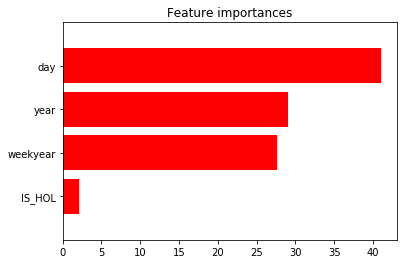

In [233]:
importances = cat.feature_importances_
indices = np.argsort(importances)

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.barh(range(x_train.shape[1]), importances[indices],
       color="r", align="center")
plt.yticks(range(x_train.shape[1]), [features[i] for i in indices])
plt.ylim([-1, x_train.shape[1]])
plt.show()

### Summary and outlook
After exploring the data we had at hand we extracted the features, which can be applied to our model. We used `CatBoostRegressor` for the feature extraction and identified that `day`, `year`, `weekyear` as well as `IS_HOL`, are the main features, which help our model to train and later predict. A key challenge is the wide spread among the ordered cases per day, which can vary from 1 to >200k. This is the reason why we're trying to reduce the outliers with zscore. This already helped us to reduce the loss function (MSE) significantly. 

With the extracted features we have the chance to train a model per material. Above we can see the results for one material code. The results are reosanbly good (RMSE < std). Advancing, we will use the model weights per material to identify whether we can cluster some of the materials (potentially, t-SNE) and train more complex models on them. Furthermore, we will align further with the client to identify whether they already have an updated pre-classification similar to the `sku_class`.

In [11]:
data.columns

Index(['material', 'plant_code', 'cases', 'value', 'sales_date', 'f_day',
       'adbno', 'product_description', 'service_level', 'mrp_desc',
       'group2_desc', 'group3_desc', 'group6_desc', 'est_lead_time',
       'sku_class', 'IS_HOL', 'day', 'month', 'year', 'log_cases', 'weekyear'],
      dtype='object')

In [12]:
materials = ['D13384914', 'D13397569', 'D13397959', 'D13398084', 'D13398148', 'D13398112', 'D13398151', 'D13398135', 'D13397918', 'D13397940']

In [19]:
dummy_variables = ['material', 'plant_code',
 'mrp_desc',
 'group2_desc',
 'group3_desc',
 'day',
 'year',
 'weekyear']
train_data = data[(data.value >= 1) & (data.cases >= 1) & (data.year >= 2017) * (data.material == materials[0])]
dropped_columns = ['month', 'sku_class', 'group6_desc', 'service_level', 'IS_HOL', 'sales_date', 'f_day', 'adbno', 'product_description', 'log_cases']
train_data = train_data.drop(dropped_columns, axis=1)

for var in dummy_variables:
    dummy = pd.get_dummies(train_data[var], prefix=var, drop_first=False)
    train_data = pd.concat([train_data, dummy], axis=1)

train_data = train_data.drop(dummy_variables, axis=1)

train_data = train_data[np.abs(zscore(train_data.cases.apply(lambda x: np.log(x + 1))) < 1.96)]

to_drop = ['cases', 'value']
x_data = train_data.drop(['cases', 'value'], axis=1)
y_data = pd.DataFrame(data=train_data['cases'])

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data.cases.apply(lambda x: np.log(x+1)))

#this is the LR for all materials in one model

train_data.describe()

lr_clf1 = LinearRegression().fit(x_train, y_train)
print("train MSE: {}".format(mean_squared_error(f(y_train), f(lr_clf1.predict(x_train)))))
print("validation MSE: {}".format(mean_squared_error(f(y_val), f(lr_clf1.predict(x_val)))))




# time_split = TimeSeriesSplit(n_splits=10)
# params = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0], 'l1_ratio': [0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75]}
# lr_clf = GridSearchCV(
#     ElasticNet(),
#     params,
#     scoring=make_scorer(mean_squared_error, greater_is_better=False),
#     cv=time_split
# )


# lr_clf.fit(x_train, y_train)

# print("Best parameters of EN:", lr_clf1.best_params_)
# print("Best RMSE on validation:", np.sqrt(-lr_clf1.best_score_))
print("RMSE on validation:", np.sqrt(mean_squared_error(f(y_val), f(lr_clf1.predict(x_val)))))
print("RMSE on train:", np.sqrt(mean_squared_error(f(y_train), f(lr_clf1.predict(x_train)))))


/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


train MSE: 2288643.5052021528
validation MSE: 1921208.4270588285
RMSE on validation: 1386.0766310196664
RMSE on train: 1512.8263301523255


In [20]:
train_data.describe()

cases          value  est_lead_time  material_D13384914  \
count    838.000000     838.000000     838.000000               838.0   
mean     968.122912   23628.375263      61.298329                 1.0   
std     1573.545815   28893.397048      29.538453                 0.0   
min        1.000000      74.840000      16.000000                 1.0   
25%       47.000000    2953.635000      68.000000                 1.0   
50%      477.000000   15559.930000      68.000000                 1.0   
75%     1192.750000   31431.445000      68.000000                 1.0   
max    14700.000000  278010.300000     120.000000                 1.0   

       plant_code_AC01  plant_code_WM46  plant_code_WM84  mrp_desc_Coveralls  \
count       838.000000       838.000000       838.000000               838.0   
mean          0.233890         0.105012         0.661098                 1.0   
std           0.423556         0.306752         0.473619                 0.0   
min           0.000000         0.000000         0.000000                 1.0   
25%           0.000000         0.000000         0.000000                 1.0   
50%           0.000000         0.000000         1.000000                 1.0   
75%           0.000000         0.000000         1.000000                 1.0   
max           1.000000         1.000000         1.000000                 1.0   

       group2_desc_TYVEK PROTECTION  group3_desc_TYVEK PROTECTION  ...  \
count                         838.0                         838.0  ...   
mean                            1.0                           1.0  ...   
std                             0.0                           0.0  ...   
min                             1.0                           1.0  ...   
25%                             1.0                           1.0  ...   
50%                             1.0                           1.0  ...   
75%                             1.0                           1.0  ...   
max                             1.0                           1.0  ...   

       weekyear_43  weekyear_44  weekyear_45  weekyear_46  weekyear_47  \
count   838.000000   838.000000   838.000000   838.000000   838.000000   
mean      0.020286     0.017900     0.020286     0.016706     0.017900   
std       0.141062     0.132666     0.141062     0.128246     0.132666   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       weekyear_48  weekyear_49  weekyear_50  weekyear_51  weekyear_52  
count   838.000000   838.000000   838.000000   838.000000   838.000000  
mean      0.019093     0.017900     0.016706     0.019093     0.013126  
std       0.136934     0.132666     0.128246     0.136934     0.113884  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 71 columns]

In [22]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit

In [23]:
time_split = TimeSeriesSplit(n_splits=10)
params = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0], 'l1_ratio': [0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75]}
lr_clf1 = GridSearchCV(
    ElasticNet(),
    params,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=time_split
)


lr_clf1.fit(x_train, y_train)

print("Best parameters of EN:", lr_clf1.best_params_)
print("Best RMSE on validation:", np.sqrt(-lr_clf1.best_score_))
print("RMSE on validation:", np.sqrt(mean_squared_error(f(y_val), f(lr_clf1.predict(x_val)))))
print("RMSE on train:", np.sqrt(mean_squared_error(f(y_train), f(lr_clf1.predict(x_train)))))


Best parameters of EN: {'alpha': 0.1, 'l1_ratio': 0.05}
Best RMSE on validation: 1.112324182135016
RMSE on validation: 1446.8576531523163
RMSE on train: 1613.1677721768322


In [27]:
features = ['day', 'year', 'weekyear', 'IS_HOL']
categorical_features = ['day', 'year', 'weekyear', 'IS_HOL']

train_data = data[(data.value >= 1) & (data.cases >= 1) & (data.year >= 2017) & (data.material == materials[0])]
train_data = train_data[np.abs(zscore(train_data.cases.apply(lambda x: np.log(x + 1))) < 1.96)]
x_train, x_val, y_train, y_val = train_test_split(train_data[features], train_data.cases.apply(lambda x: np.log(x+1)))

cat = CatBoostRegressor()
cat.fit(x_train, y_train, cat_features=categorical_features)

print("train MSE: {}".format(mean_squared_error(f(y_train), f(cat.predict(x_train)))))
print("validation MSE: {}".format(mean_squared_error(f(y_val), f(cat.predict(x_val)))))
print("train RMSE: {}".format(np.sqrt(mean_squared_error(f(y_train), f(cat.predict(x_train))))))
print("val RMSE: {}".format(np.sqrt(mean_squared_error(f(y_val), f(cat.predict(x_val))))))

0:	learn: 5.7765361	total: 12.5ms	remaining: 12.5s
1:	learn: 5.6294245	total: 25.6ms	remaining: 12.8s
2:	learn: 5.4868265	total: 40.4ms	remaining: 13.4s
3:	learn: 5.3491139	total: 51.6ms	remaining: 12.9s
4:	learn: 5.2191269	total: 75ms	remaining: 14.9s
5:	learn: 5.0909749	total: 82.8ms	remaining: 13.7s
6:	learn: 4.9693017	total: 91.6ms	remaining: 13s
7:	learn: 4.8520090	total: 98.8ms	remaining: 12.3s
8:	learn: 4.7359724	total: 105ms	remaining: 11.6s
9:	learn: 4.6241022	total: 117ms	remaining: 11.6s
10:	learn: 4.5176826	total: 122ms	remaining: 11s
11:	learn: 4.4145565	total: 126ms	remaining: 10.4s
12:	learn: 4.3164720	total: 130ms	remaining: 9.86s
13:	learn: 4.2199237	total: 133ms	remaining: 9.37s
14:	learn: 4.1271401	total: 135ms	remaining: 8.88s
15:	learn: 4.0377169	total: 138ms	remaining: 8.49s
16:	learn: 3.9536217	total: 142ms	remaining: 8.22s
17:	learn: 3.8712330	total: 146ms	remaining: 7.95s
18:	learn: 3.7920084	total: 148ms	remaining: 7.65s
19:	learn: 3.7170927	total: 152ms	remai

181:	learn: 2.0655439	total: 1.44s	remaining: 6.48s
182:	learn: 2.0655356	total: 1.44s	remaining: 6.45s
183:	learn: 2.0654182	total: 1.45s	remaining: 6.44s
184:	learn: 2.0650800	total: 1.47s	remaining: 6.47s
185:	learn: 2.0644746	total: 1.48s	remaining: 6.48s
186:	learn: 2.0643154	total: 1.49s	remaining: 6.47s
187:	learn: 2.0621761	total: 1.49s	remaining: 6.45s
188:	learn: 2.0596480	total: 1.5s	remaining: 6.43s
189:	learn: 2.0592095	total: 1.5s	remaining: 6.42s
190:	learn: 2.0586527	total: 1.51s	remaining: 6.41s
191:	learn: 2.0567450	total: 1.52s	remaining: 6.39s
192:	learn: 2.0567116	total: 1.52s	remaining: 6.36s
193:	learn: 2.0546915	total: 1.52s	remaining: 6.33s
194:	learn: 2.0542457	total: 1.53s	remaining: 6.31s
195:	learn: 2.0542418	total: 1.53s	remaining: 6.28s
196:	learn: 2.0541767	total: 1.53s	remaining: 6.25s
197:	learn: 2.0533820	total: 1.54s	remaining: 6.23s
198:	learn: 2.0533788	total: 1.54s	remaining: 6.21s
199:	learn: 2.0532737	total: 1.54s	remaining: 6.18s
200:	learn: 2.

349:	learn: 1.9512917	total: 2.87s	remaining: 5.33s
350:	learn: 1.9493711	total: 2.88s	remaining: 5.32s
351:	learn: 1.9491000	total: 2.88s	remaining: 5.3s
352:	learn: 1.9489774	total: 2.9s	remaining: 5.32s
353:	learn: 1.9484160	total: 2.91s	remaining: 5.32s
354:	learn: 1.9455486	total: 2.93s	remaining: 5.32s
355:	learn: 1.9453352	total: 2.95s	remaining: 5.34s
356:	learn: 1.9451945	total: 2.97s	remaining: 5.35s
357:	learn: 1.9450996	total: 3s	remaining: 5.38s
358:	learn: 1.9433722	total: 3.01s	remaining: 5.38s
359:	learn: 1.9425220	total: 3.02s	remaining: 5.38s
360:	learn: 1.9423910	total: 3.05s	remaining: 5.4s
361:	learn: 1.9414835	total: 3.07s	remaining: 5.41s
362:	learn: 1.9412114	total: 3.11s	remaining: 5.46s
363:	learn: 1.9389807	total: 3.12s	remaining: 5.46s
364:	learn: 1.9387922	total: 3.15s	remaining: 5.47s
365:	learn: 1.9384824	total: 3.16s	remaining: 5.48s
366:	learn: 1.9375959	total: 3.19s	remaining: 5.5s
367:	learn: 1.9374665	total: 3.2s	remaining: 5.5s
368:	learn: 1.9372877

511:	learn: 1.8748857	total: 5.74s	remaining: 5.47s
512:	learn: 1.8746694	total: 5.76s	remaining: 5.47s
513:	learn: 1.8745243	total: 5.78s	remaining: 5.47s
514:	learn: 1.8738374	total: 5.8s	remaining: 5.46s
515:	learn: 1.8737310	total: 5.82s	remaining: 5.46s
516:	learn: 1.8731403	total: 5.84s	remaining: 5.45s
517:	learn: 1.8727504	total: 5.86s	remaining: 5.45s
518:	learn: 1.8725767	total: 5.87s	remaining: 5.44s
519:	learn: 1.8722851	total: 5.88s	remaining: 5.42s
520:	learn: 1.8722729	total: 5.88s	remaining: 5.41s
521:	learn: 1.8717848	total: 5.88s	remaining: 5.39s
522:	learn: 1.8717726	total: 5.89s	remaining: 5.38s
523:	learn: 1.8715852	total: 5.9s	remaining: 5.36s
524:	learn: 1.8714636	total: 5.91s	remaining: 5.35s
525:	learn: 1.8712863	total: 5.92s	remaining: 5.33s
526:	learn: 1.8709214	total: 5.92s	remaining: 5.32s
527:	learn: 1.8699929	total: 5.93s	remaining: 5.3s
528:	learn: 1.8698307	total: 5.95s	remaining: 5.29s
529:	learn: 1.8696173	total: 5.96s	remaining: 5.29s
530:	learn: 1.8

676:	learn: 1.8169310	total: 8.66s	remaining: 4.13s
677:	learn: 1.8167682	total: 8.67s	remaining: 4.12s
678:	learn: 1.8166791	total: 8.69s	remaining: 4.11s
679:	learn: 1.8161335	total: 8.7s	remaining: 4.09s
680:	learn: 1.8160792	total: 8.76s	remaining: 4.1s
681:	learn: 1.8160552	total: 8.78s	remaining: 4.09s
682:	learn: 1.8159722	total: 8.82s	remaining: 4.09s
683:	learn: 1.8159189	total: 8.87s	remaining: 4.1s
684:	learn: 1.8154049	total: 8.92s	remaining: 4.1s
685:	learn: 1.8151725	total: 8.96s	remaining: 4.1s
686:	learn: 1.8151151	total: 8.97s	remaining: 4.09s
687:	learn: 1.8151151	total: 8.98s	remaining: 4.07s
688:	learn: 1.8149928	total: 9s	remaining: 4.06s
689:	learn: 1.8140766	total: 9.02s	remaining: 4.05s
690:	learn: 1.8140545	total: 9.05s	remaining: 4.05s
691:	learn: 1.8133665	total: 9.1s	remaining: 4.05s
692:	learn: 1.8133567	total: 9.14s	remaining: 4.05s
693:	learn: 1.8123205	total: 9.16s	remaining: 4.04s
694:	learn: 1.8117293	total: 9.19s	remaining: 4.03s
695:	learn: 1.8116598

844:	learn: 1.7673691	total: 11.5s	remaining: 2.11s
845:	learn: 1.7672732	total: 11.5s	remaining: 2.1s
846:	learn: 1.7670075	total: 11.5s	remaining: 2.08s
847:	learn: 1.7669609	total: 11.6s	remaining: 2.07s
848:	learn: 1.7664663	total: 11.6s	remaining: 2.06s
849:	learn: 1.7663744	total: 11.6s	remaining: 2.04s
850:	learn: 1.7663652	total: 11.6s	remaining: 2.03s
851:	learn: 1.7663299	total: 11.6s	remaining: 2.02s
852:	learn: 1.7663064	total: 11.6s	remaining: 2s
853:	learn: 1.7662638	total: 11.6s	remaining: 1.99s
854:	learn: 1.7662187	total: 11.6s	remaining: 1.97s
855:	learn: 1.7661310	total: 11.6s	remaining: 1.96s
856:	learn: 1.7658641	total: 11.7s	remaining: 1.94s
857:	learn: 1.7657612	total: 11.7s	remaining: 1.93s
858:	learn: 1.7657284	total: 11.7s	remaining: 1.92s
859:	learn: 1.7655313	total: 11.7s	remaining: 1.9s
860:	learn: 1.7654816	total: 11.7s	remaining: 1.89s
861:	learn: 1.7651908	total: 11.7s	remaining: 1.87s
862:	learn: 1.7651586	total: 11.7s	remaining: 1.86s
863:	learn: 1.764

In [38]:
def lr_en(df, material_code):
    dummy_variables = ['material', 'plant_code',
     'mrp_desc',
     'group2_desc',
     'group3_desc',
     'day',
     'year',
     'weekyear']
    train_data = df[(data.value >= 1) & (data.cases >= 1) & (data.year >= 2017) * (data.material == material_code)]
    dropped_columns = ['month', 'sku_class', 'group6_desc', 'service_level', 'IS_HOL', 'sales_date', 'f_day', 'adbno', 'product_description', 'log_cases']
    train_data = train_data.drop(dropped_columns, axis=1)

    for var in dummy_variables:
        dummy = pd.get_dummies(train_data[var], prefix=var, drop_first=False)
        train_data = pd.concat([train_data, dummy], axis=1)

    train_data = train_data.drop(dummy_variables, axis=1)

    train_data = train_data[np.abs(zscore(train_data.cases.apply(lambda x: np.log(x + 1))) < 1.96)]

    to_drop = ['cases', 'value']
    x_data = train_data.drop(['cases', 'value'], axis=1)
    y_data = pd.DataFrame(data=train_data['cases'])

    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data.cases.apply(lambda x: np.log(x+1)))
    
    lr_clf = LinearRegression().fit(x_train, y_train)
    print("Linear Regression Material Code: {}\n".format(material_code))
    print("train MSE: {}".format(mean_squared_error(f(y_train), f(lr_clf.predict(x_train)))))
    print("validation MSE: {}".format(mean_squared_error(f(y_val), f(lr_clf.predict(x_val)))))
    print("std cases: {}".format(train_data.std()[0]))
    print("RMSE on validation:", np.sqrt(mean_squared_error(f(y_val), f(lr_clf.predict(x_val)))))
    print("RMSE on train: {}\n".format(np.sqrt(mean_squared_error(f(y_train), f(lr_clf.predict(x_train))))))
    
    time_split = TimeSeriesSplit(n_splits=10)
    params = {'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0], 'l1_ratio': [0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75]}
    en_clf = GridSearchCV(
        ElasticNet(),
        params,
        scoring=make_scorer(mean_squared_error, greater_is_better=False),
        cv=time_split
    )


    en_clf.fit(x_train, y_train)
    print("Elastic Net Material Code: {}\n".format(material_code))
    print("Best parameters of EN:", en_clf.best_params_)
    print("Best RMSE on validation:", np.sqrt(-en_clf.best_score_))
    print("std cases: {}".format(train_data.std()[0]))
    print("RMSE on validation:", np.sqrt(mean_squared_error(f(y_val), f(en_clf.predict(x_val)))))
    print("RMSE on train: {}\n".format(np.sqrt(mean_squared_error(f(y_train), f(en_clf.predict(x_train))))))

In [39]:
lr_en(data, materials[1])

/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Linear Regression Material Code: D13397569

train MSE: 13931719.367723273
validation MSE: 10019956.454911858
std cases: 3769.3847185471705
RMSE on validation: 3165.43148005321
RMSE on train: 3732.521850937148

Elastic Net Material Code: D13397569

Best parameters of EN: {'alpha': 0.1, 'l1_ratio': 0.05}
Best RMSE on validation: 1.4382336206231148
std cases: 3769.3847185471705
RMSE on validation: 3281.404374877661
RMSE on train: 3923.7845818575342



In [40]:
for material in materials:
    lr_en(data, material)

/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Linear Regression Material Code: D13384914

train MSE: 2461544.2378990827
validation MSE: 1122220.5402030998
std cases: 1573.54581531754
RMSE on validation: 1059.349111578945
RMSE on train: 1568.9309219653626

Elastic Net Material Code: D13384914

Best parameters of EN: {'alpha': 0.1, 'l1_ratio': 0.05}
Best RMSE on validation: 1.152331594701715
std cases: 1573.54581531754
RMSE on validation: 1112.0612913680616
RMSE on train: 1700.876879527263

Linear Regression Material Code: D13397569

train MSE: 13850056.467105333
validation MSE: 10572919.384168925
std cases: 3769.3847185471705
RMSE on validation: 3251.602587059022
RMSE on train: 3721.5663996636326



/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Elastic Net Material Code: D13397569

Best parameters of EN: {'alpha': 0.1, 'l1_ratio': 0.5}
Best RMSE on validation: 1.4040033367292166
std cases: 3769.3847185471705
RMSE on validation: 3399.18362244545
RMSE on train: 3943.738483467037

Linear Regression Material Code: D13397959

train MSE: 2514861.2780242795
validation MSE: 1350371.5176140768
std cases: 1632.572170879086
RMSE on validation: 1162.0548685901526
RMSE on train: 1585.8314153857211



/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Elastic Net Material Code: D13397959

Best parameters of EN: {'alpha': 0.1, 'l1_ratio': 0.1}
Best RMSE on validation: 1.1590458720192747
std cases: 1632.572170879086
RMSE on validation: 1239.3393267714964
RMSE on train: 1758.1824999399096

Linear Regression Material Code: D13398084

train MSE: 281395.6979474579
validation MSE: 369653.23618344445
std cases: 602.6764019681175
RMSE on validation: 607.9911481127373
RMSE on train: 530.4674334466329



/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Elastic Net Material Code: D13398084

Best parameters of EN: {'alpha': 0.1, 'l1_ratio': 0.05}
Best RMSE on validation: 1.0331974215686832
std cases: 602.6764019681175
RMSE on validation: 625.011167199432
RMSE on train: 563.4242267577717

Linear Regression Material Code: D13398148

train MSE: 267782.82027059974
validation MSE: 435535.4607169852
std cases: 597.9060139252879
RMSE on validation: 659.951104792609
RMSE on train: 517.4773620851445



/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Elastic Net Material Code: D13398148

Best parameters of EN: {'alpha': 0.1, 'l1_ratio': 0.05}
Best RMSE on validation: 1.1205549814890594
std cases: 597.9060139252879
RMSE on validation: 667.3943136784604
RMSE on train: 562.3117768190099

Linear Regression Material Code: D13398112

train MSE: 180644.93906882257
validation MSE: 245903.1348917583
std cases: 519.857784750487
RMSE on validation: 495.88621163706324
RMSE on train: 425.0234570806917



/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Elastic Net Material Code: D13398112

Best parameters of EN: {'alpha': 0.1, 'l1_ratio': 0.05}
Best RMSE on validation: 1.004689492339615
std cases: 519.857784750487
RMSE on validation: 512.7292670415194
RMSE on train: 459.0384483048896

Linear Regression Material Code: D13398151

train MSE: 124686.63246537907
validation MSE: 123056.01043282422
std cases: 404.8004301473887
RMSE on validation: 350.79340135302465
RMSE on train: 353.1099438777943



/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Elastic Net Material Code: D13398151

Best parameters of EN: {'alpha': 0.1, 'l1_ratio': 0.05}
Best RMSE on validation: 1.0477368037509684
std cases: 404.8004301473887
RMSE on validation: 354.04163752714135
RMSE on train: 379.41748673458926

Linear Regression Material Code: D13398135

train MSE: 148417.28824117166
validation MSE: 122380.70761513028
std cases: 396.81286351503377
RMSE on validation: 349.8295407982726
RMSE on train: 385.2496440506748



/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Elastic Net Material Code: D13398135

Best parameters of EN: {'alpha': 0.1, 'l1_ratio': 0.05}
Best RMSE on validation: 1.08332409155304
std cases: 396.81286351503377
RMSE on validation: 358.7956382321637
RMSE on train: 403.85052520464444

Linear Regression Material Code: D13397918

train MSE: 546918.3959010477
validation MSE: 710453.4954853408
std cases: 819.5985263891919
RMSE on validation: 842.8840344230877
RMSE on train: 739.5393132897316



/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Elastic Net Material Code: D13397918

Best parameters of EN: {'alpha': 0.1, 'l1_ratio': 0.05}
Best RMSE on validation: 1.1538695900245908
std cases: 819.5985263891919
RMSE on validation: 889.8819269151229
RMSE on train: 806.5294006679821

Linear Regression Material Code: D13397940

train MSE: 615299.5190912657
validation MSE: 959020.9828231453
std cases: 790.1774166592362
RMSE on validation: 979.296167062419
RMSE on train: 784.4103002200225



/usr/local/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


Elastic Net Material Code: D13397940

Best parameters of EN: {'alpha': 0.1, 'l1_ratio': 0.05}
Best RMSE on validation: 1.2621682243015993
std cases: 790.1774166592362
RMSE on validation: 872.7936802500402
RMSE on train: 801.9663547393164



In [41]:
df = data[['weekyear', 'material', 'value', 'cases', 'year']].groupby(['year', 'weekyear', 'material'], as_index=False).sum()

In [42]:
df.head()

year  weekyear   material  value  cases
0  2016        34  D13473315    0.0      1
1  2016        34  D14238430    0.0      1
2  2016        34  D14247548    0.0      1
3  2016        34  D14249065    0.0      1
4  2016        34  D14659130    0.0      1

In [43]:
def material_map(material_code, year):
    plt.figure(figsize=(50,20))
    plt.plot(df[(df.year == year) & (df.material == material_code)].weekyear, df[(df.year == year) & (df.material == material_code)].cases)
    plt.show()

Graph for material D13384914 in year 2017


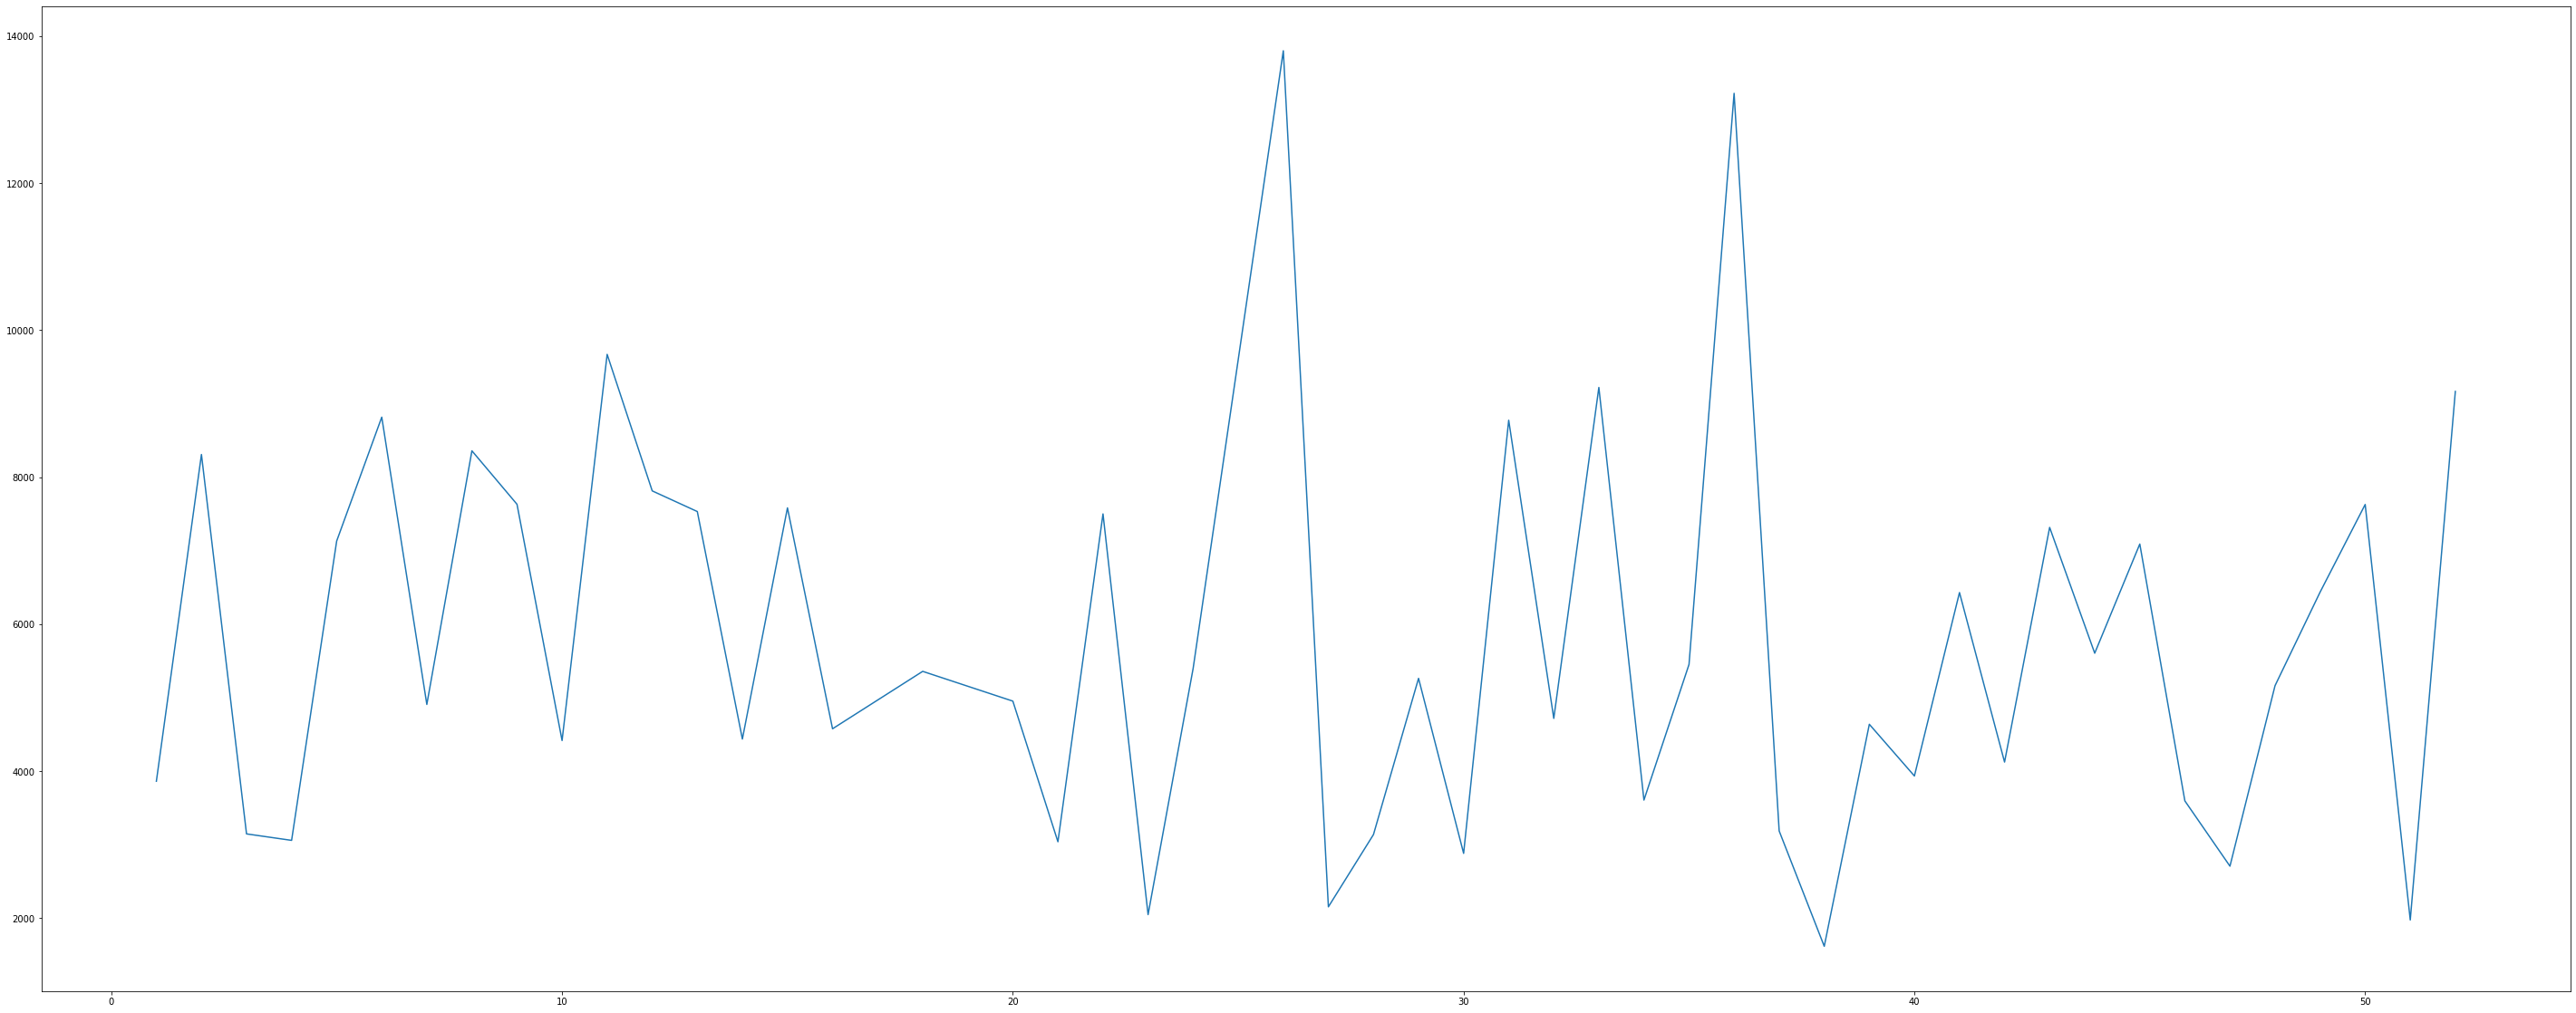

Graph for material D13384914 in year 2018


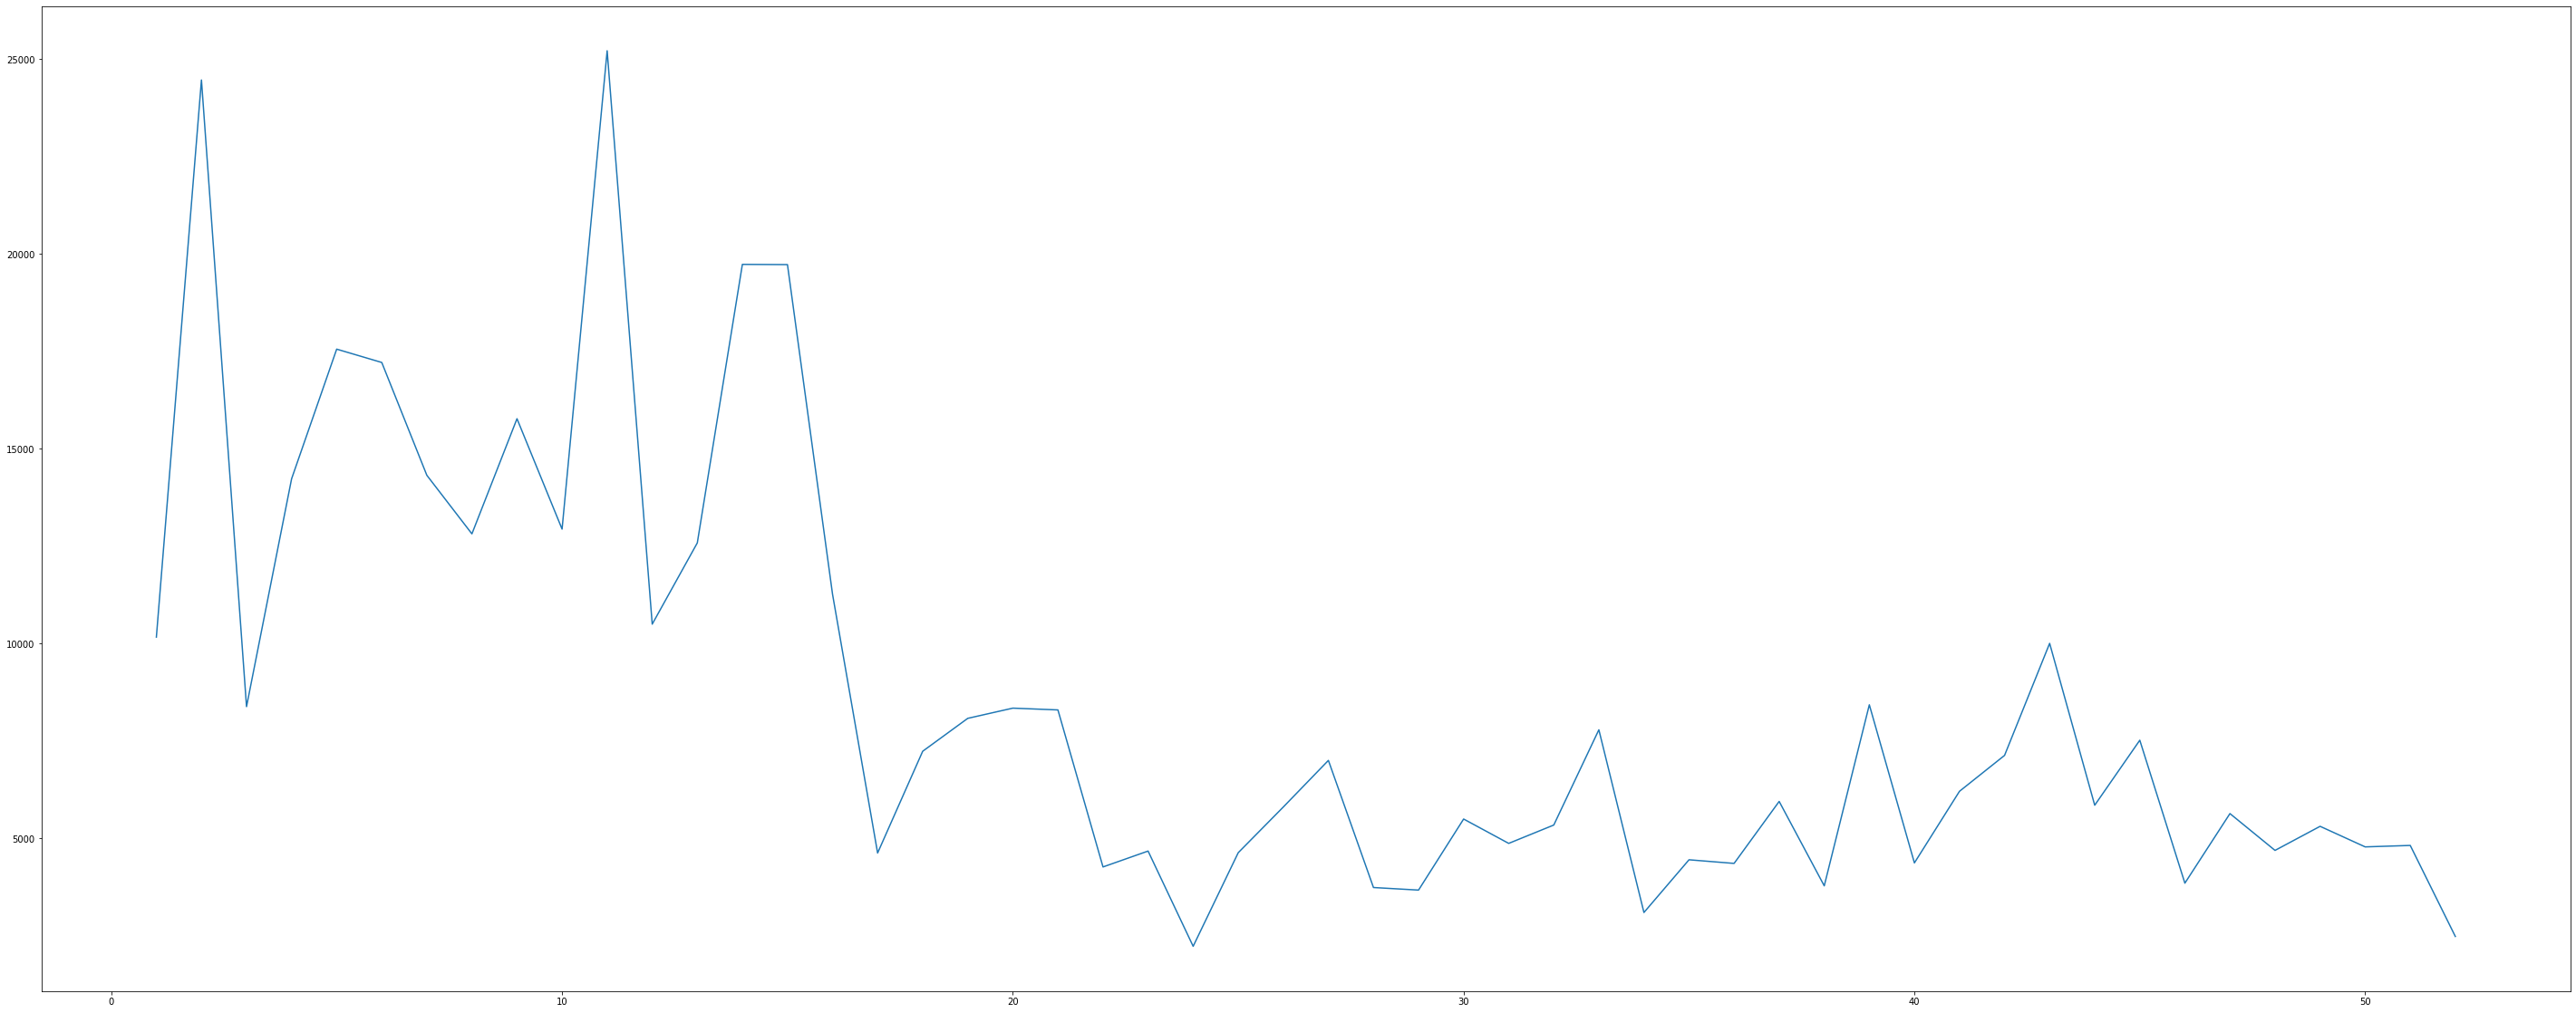

Graph for material D13397569 in year 2017


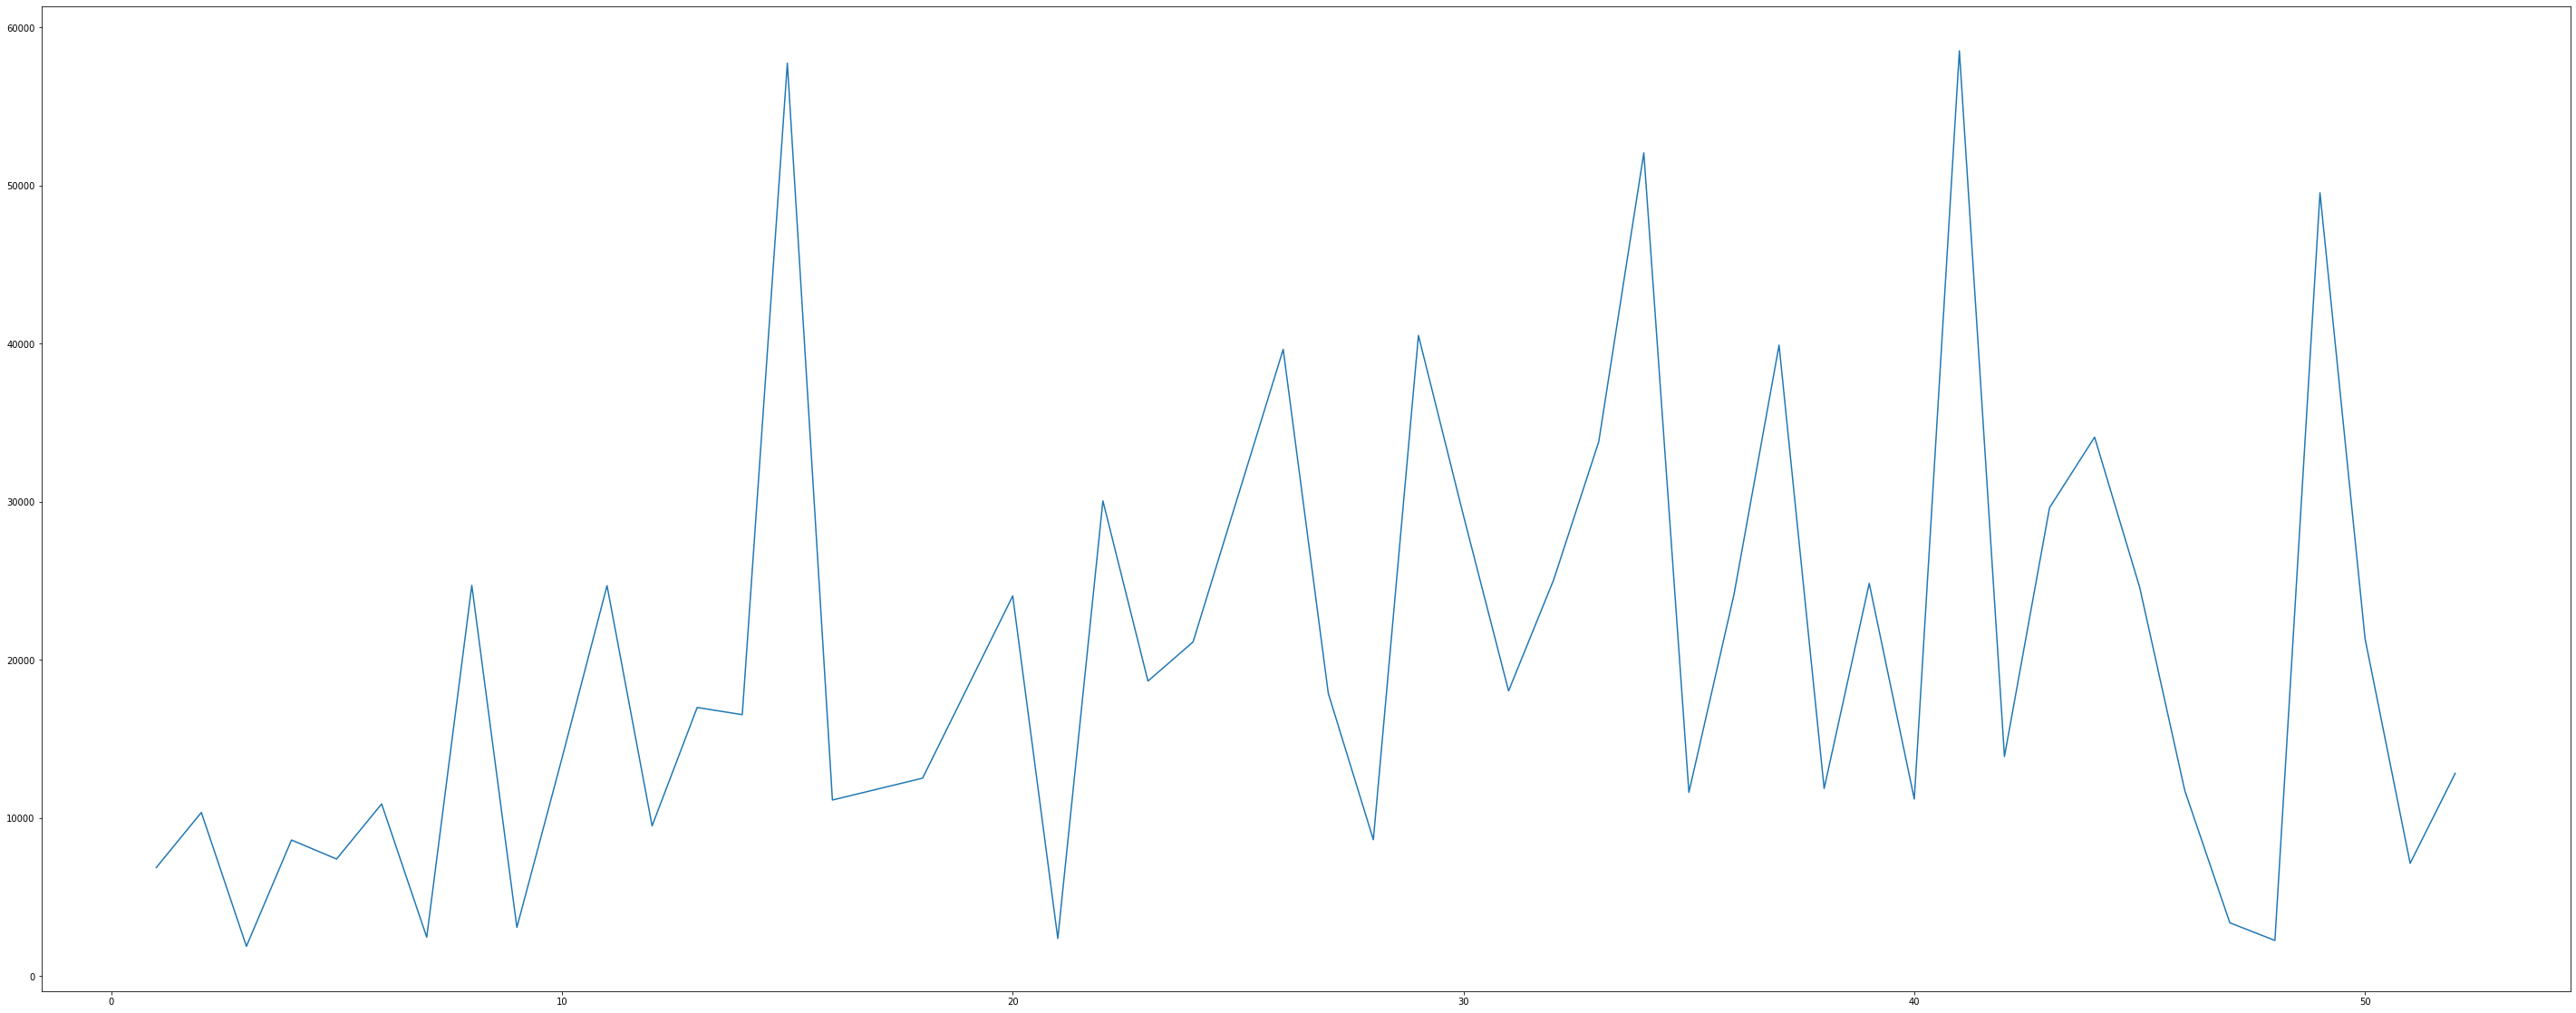

Graph for material D13397569 in year 2018


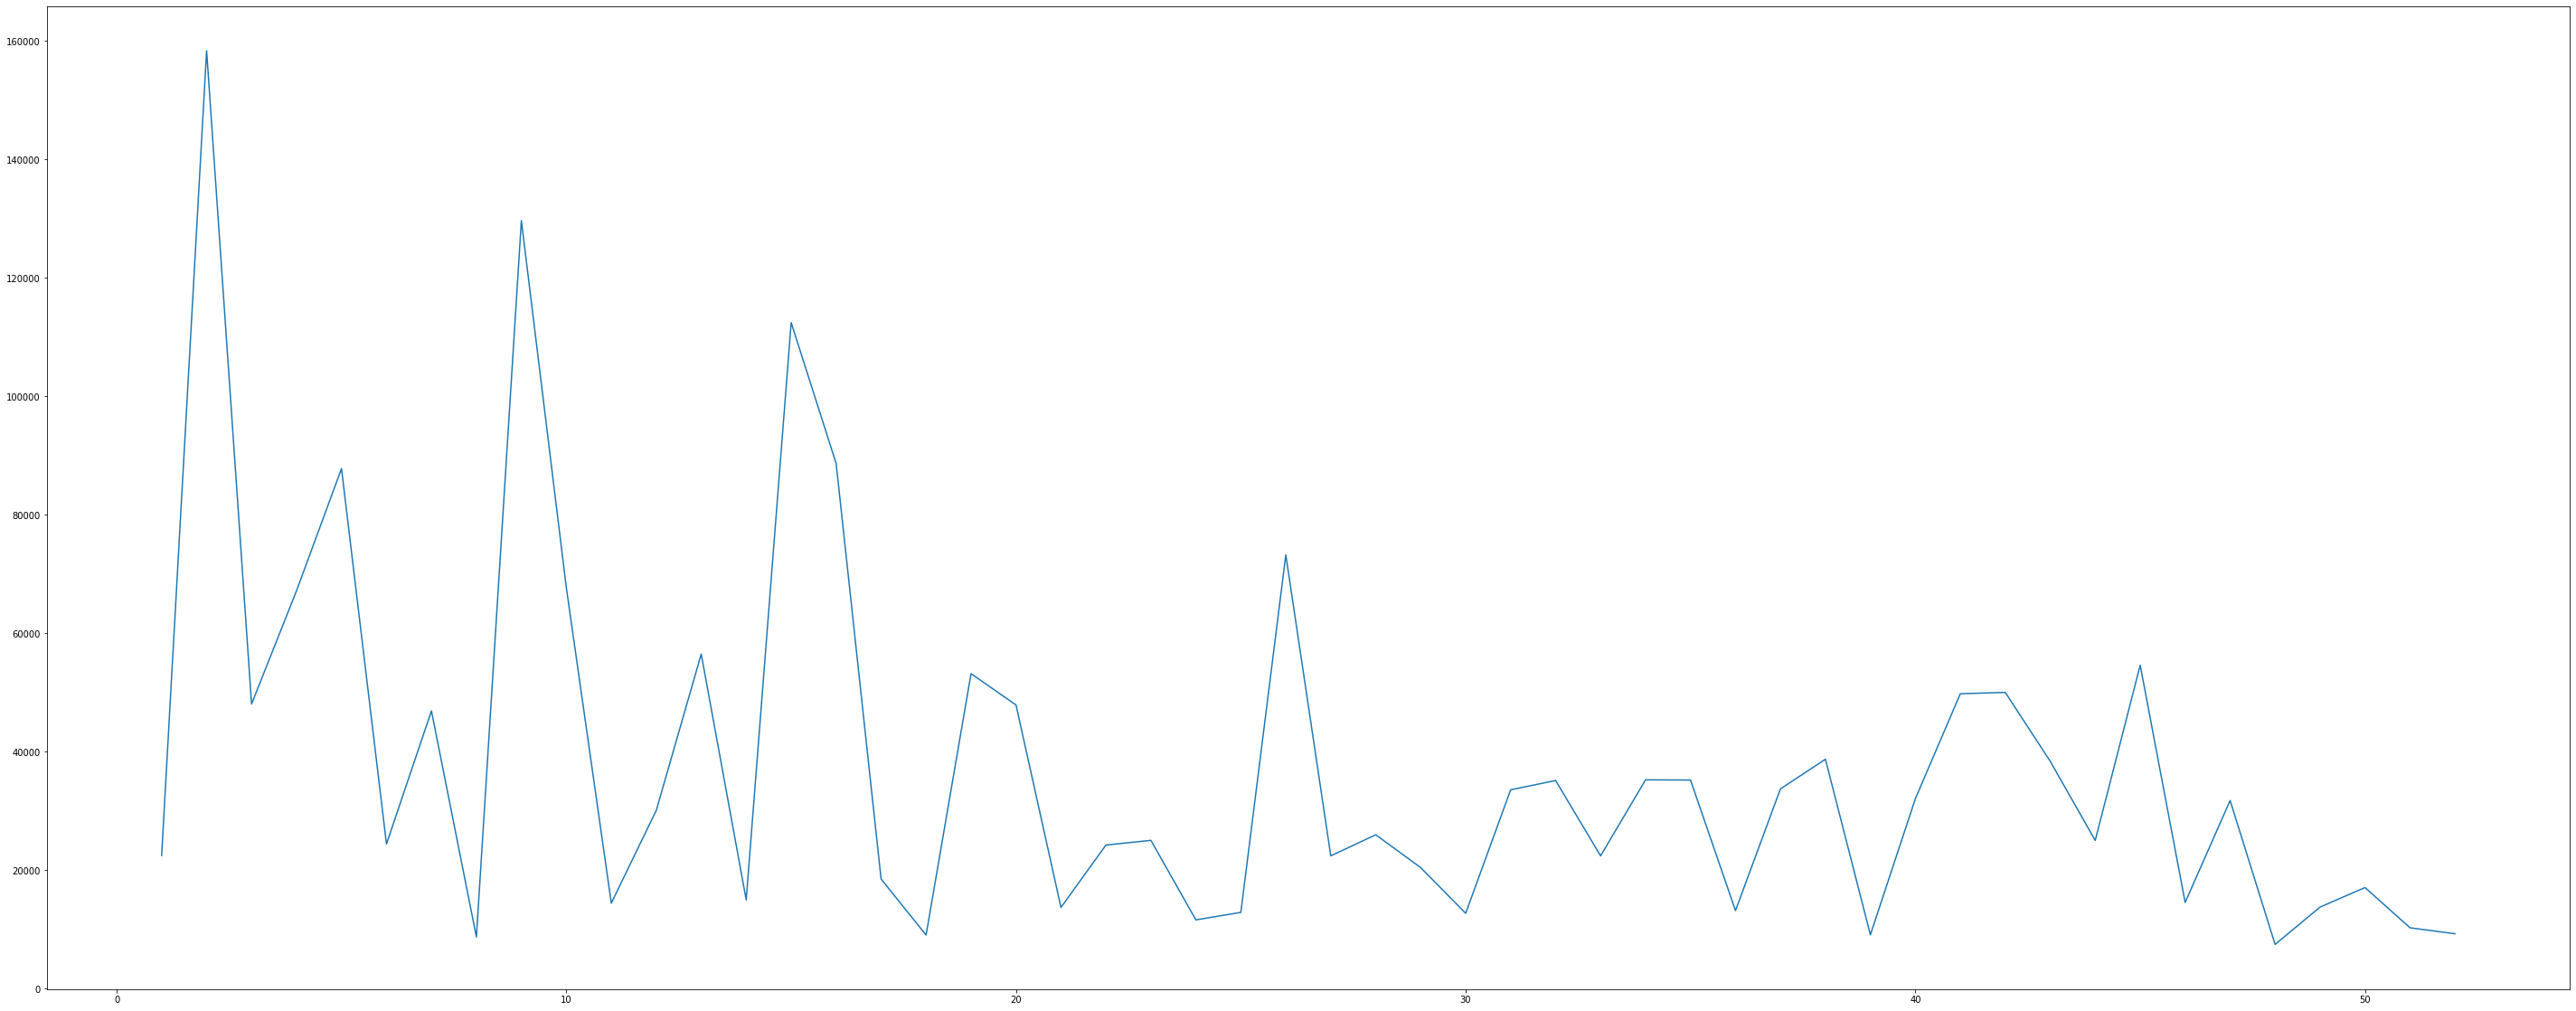

Graph for material D13397959 in year 2017


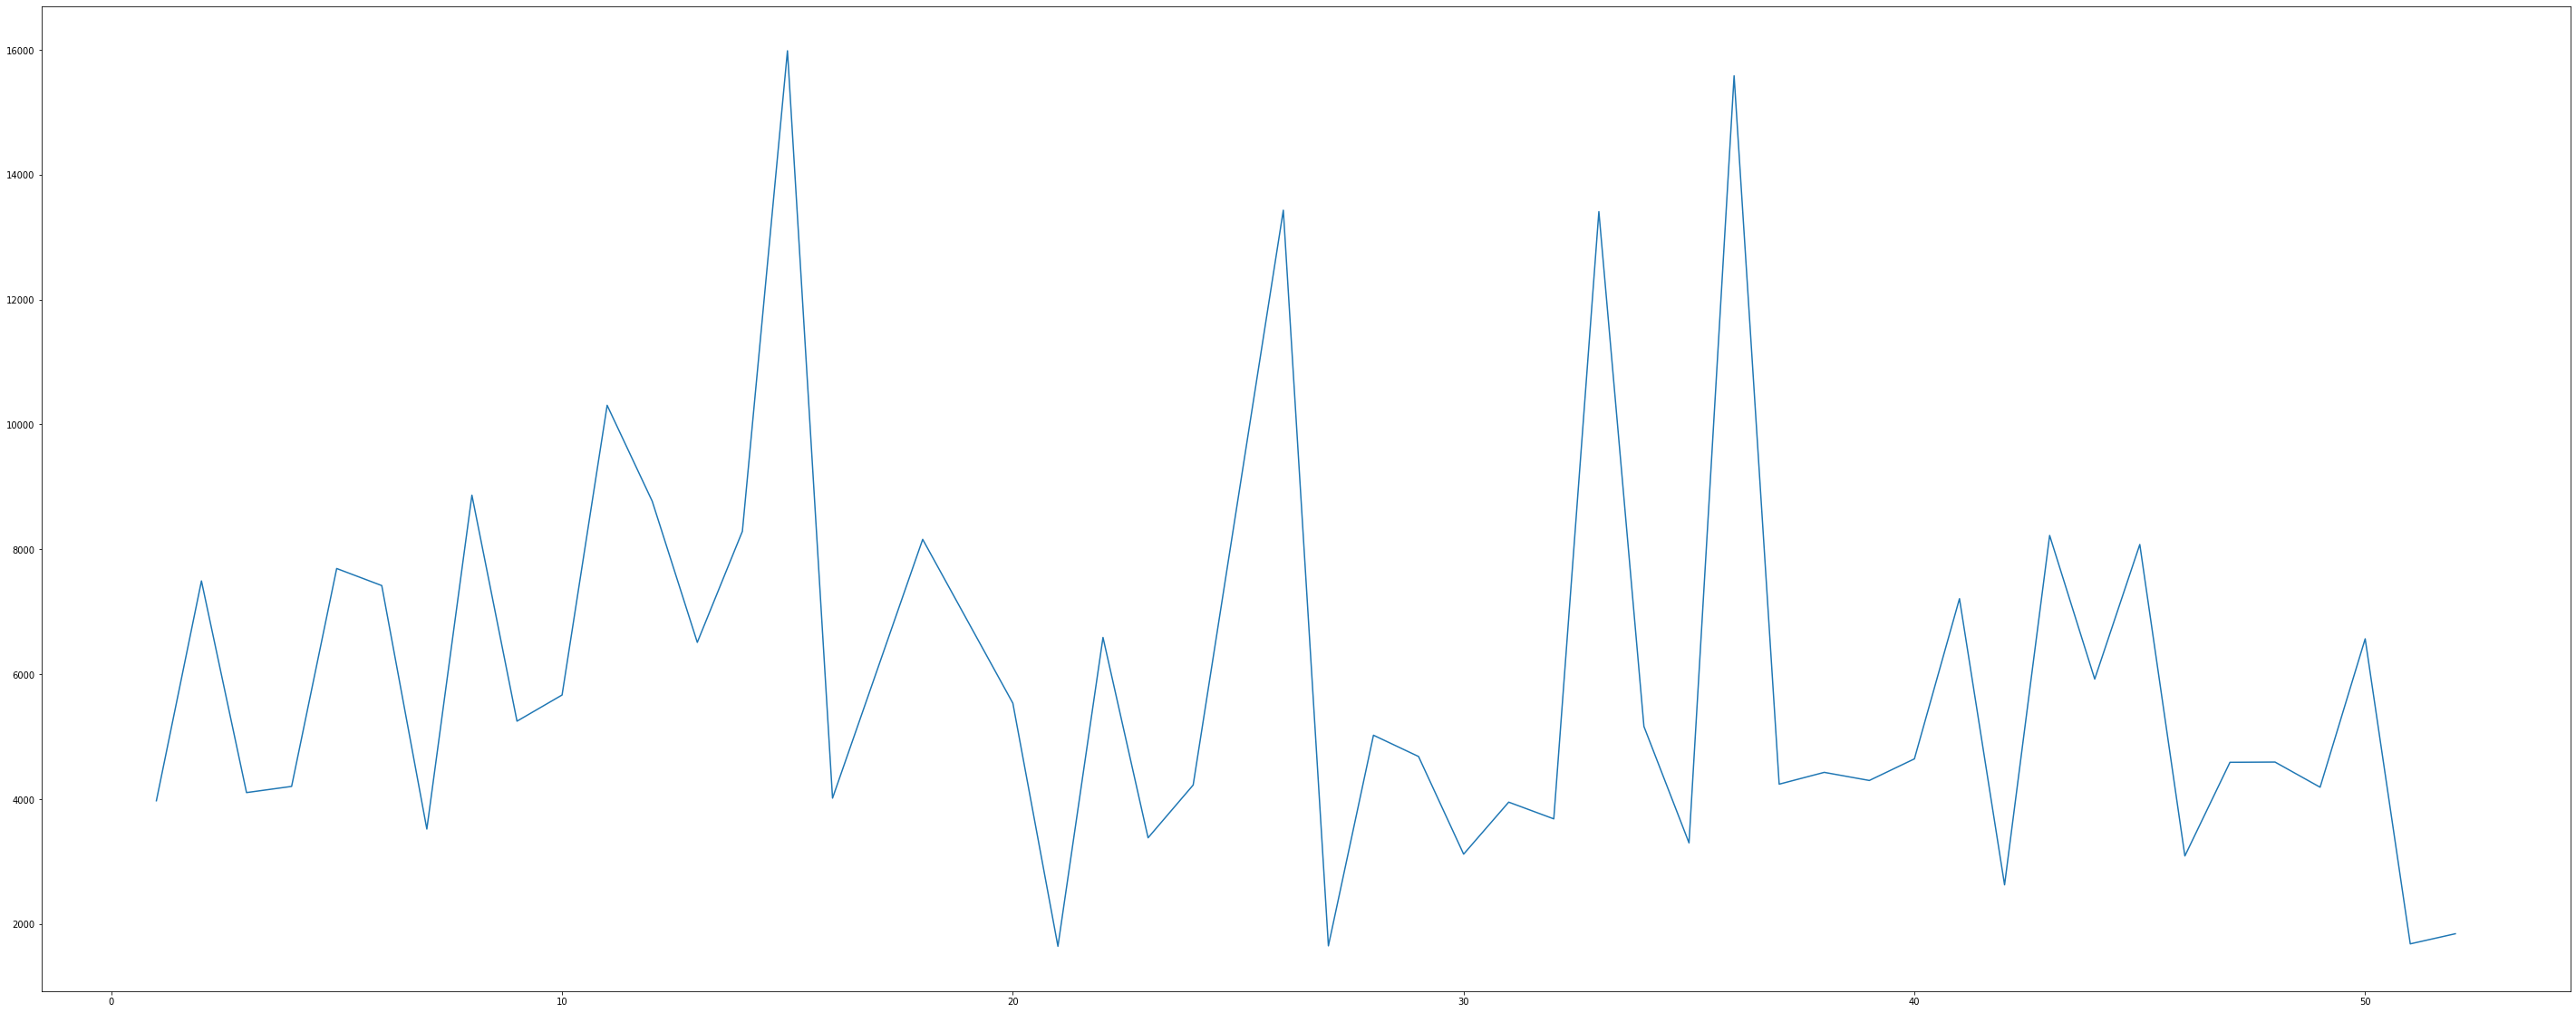

Graph for material D13397959 in year 2018


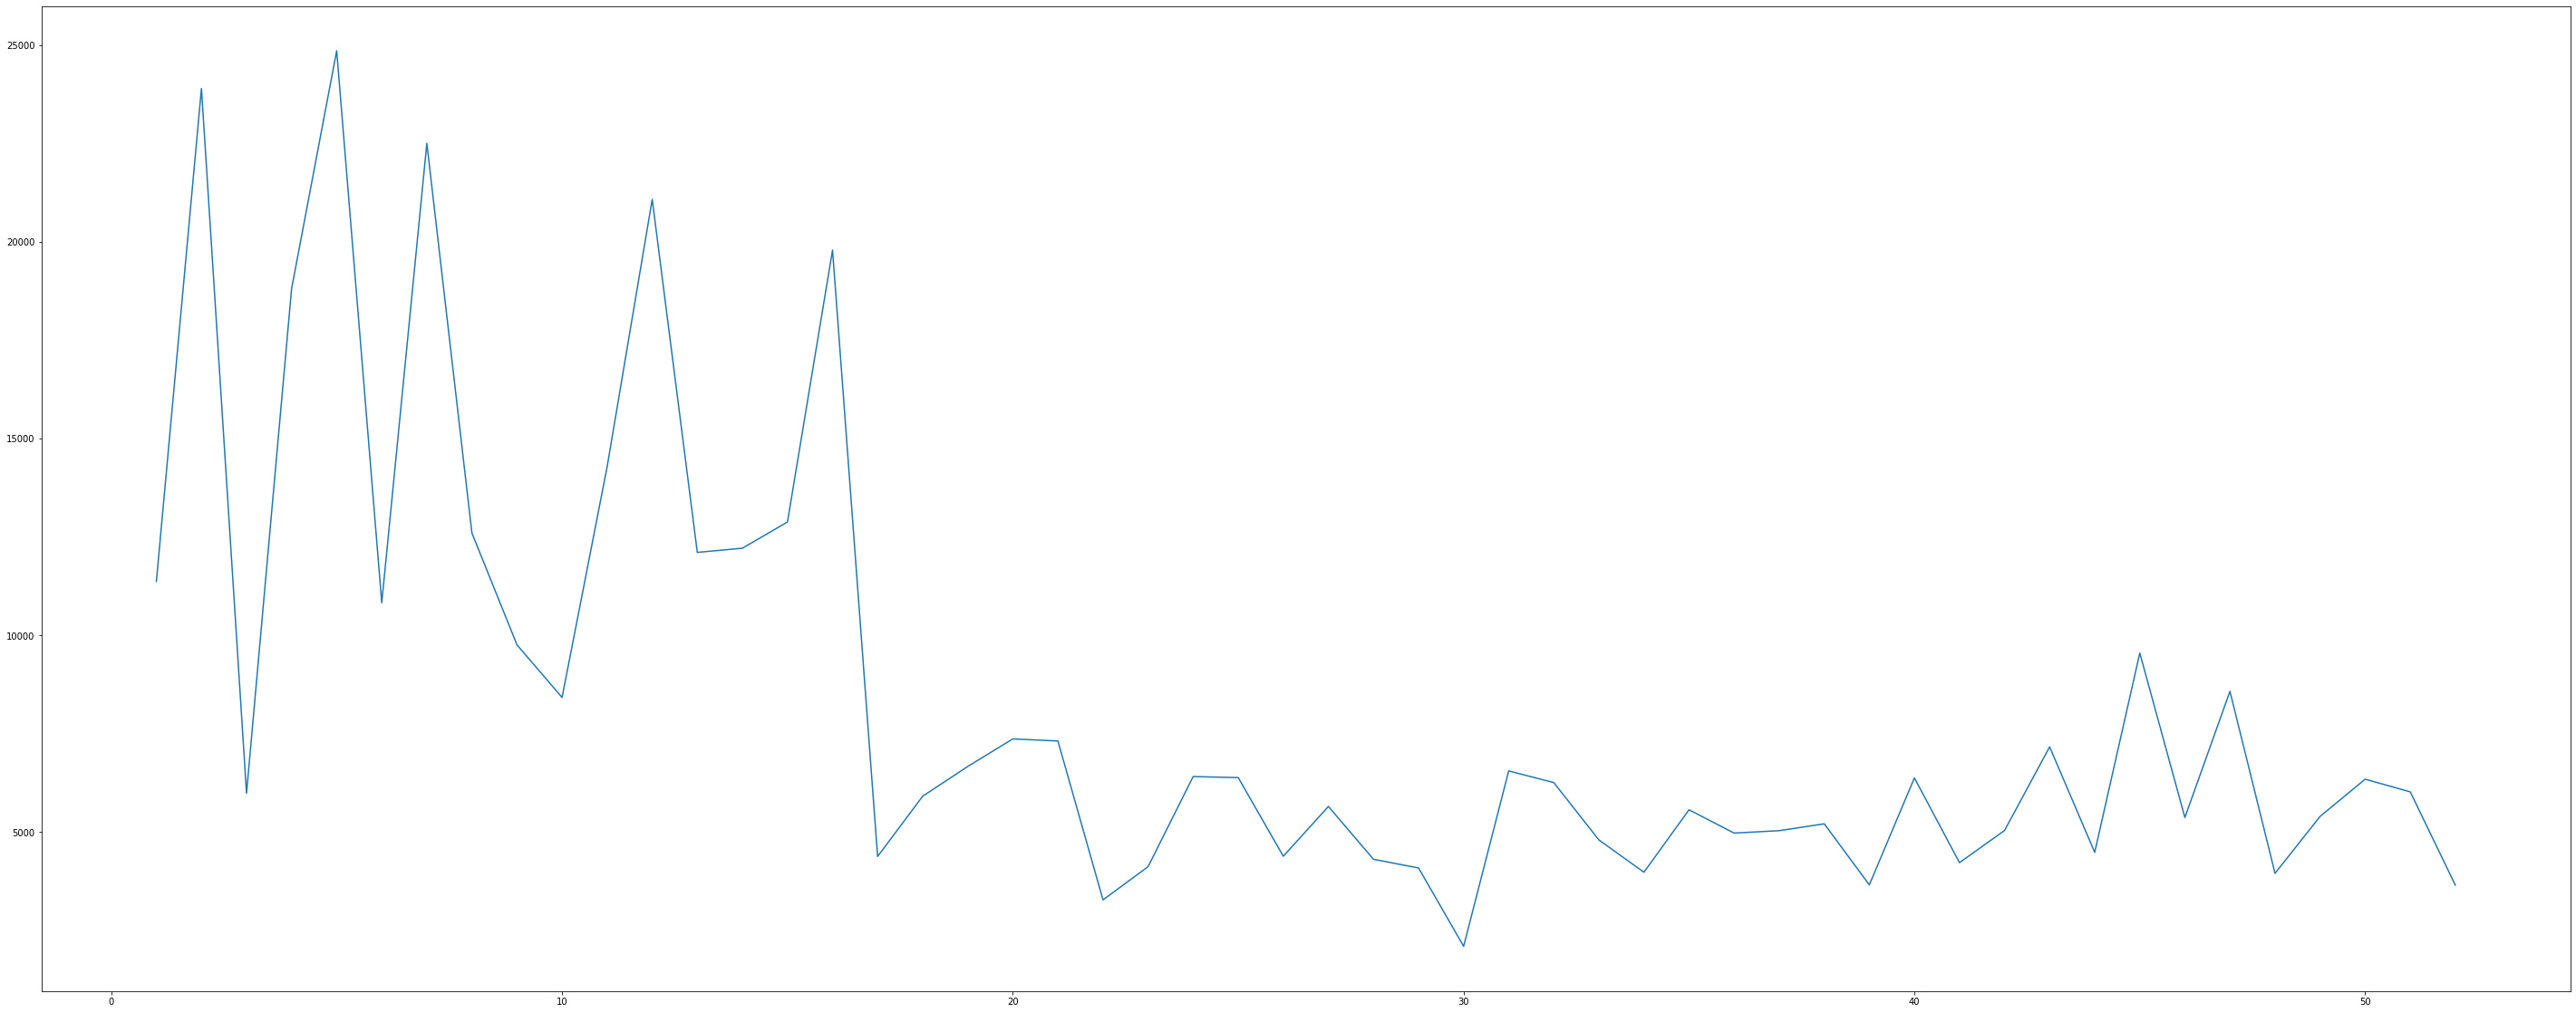

Graph for material D13398084 in year 2017


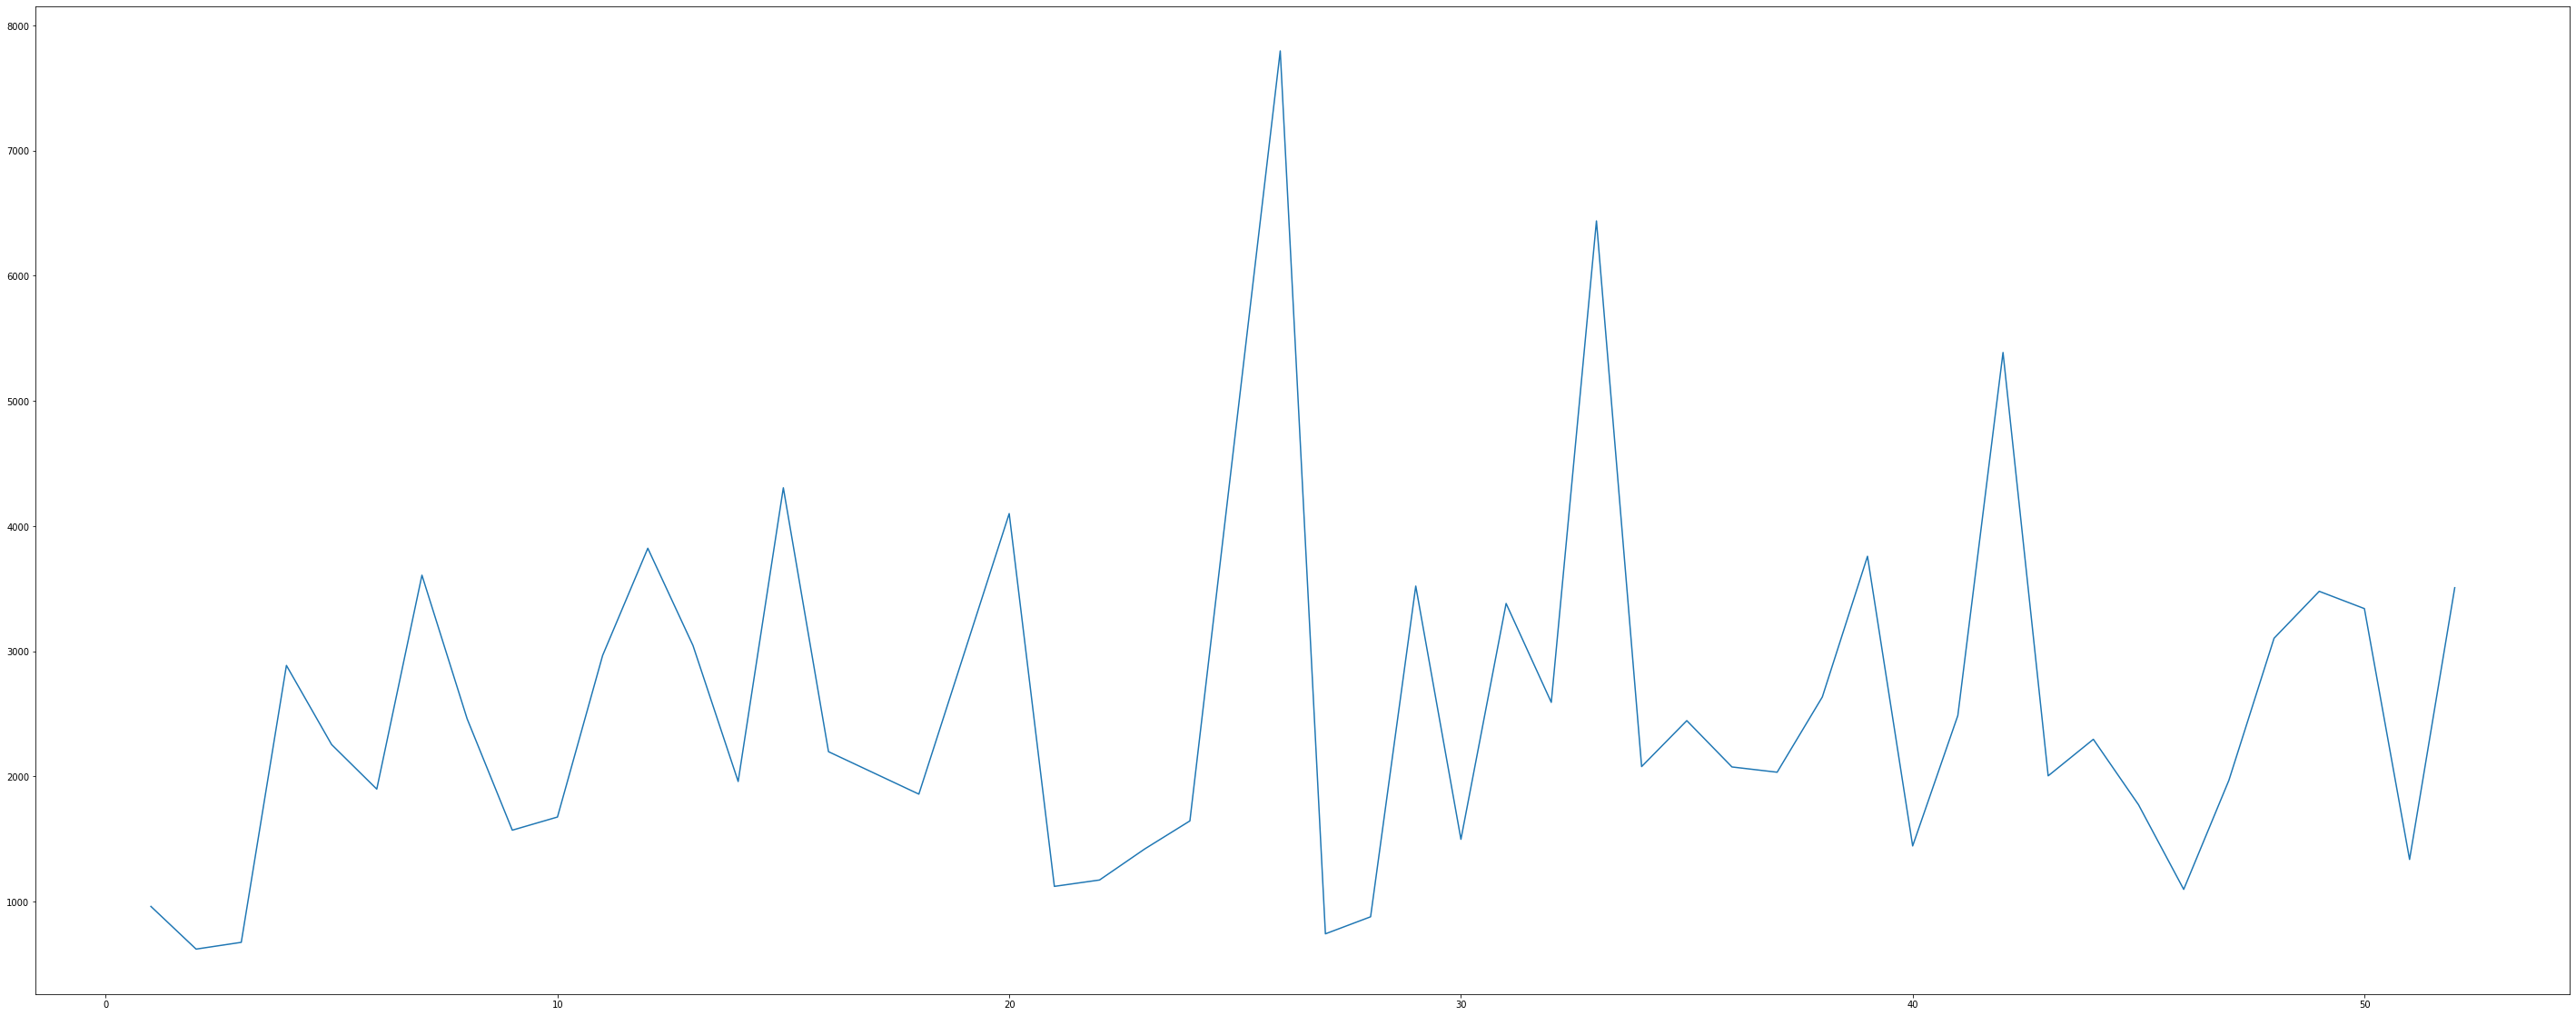

Graph for material D13398084 in year 2018


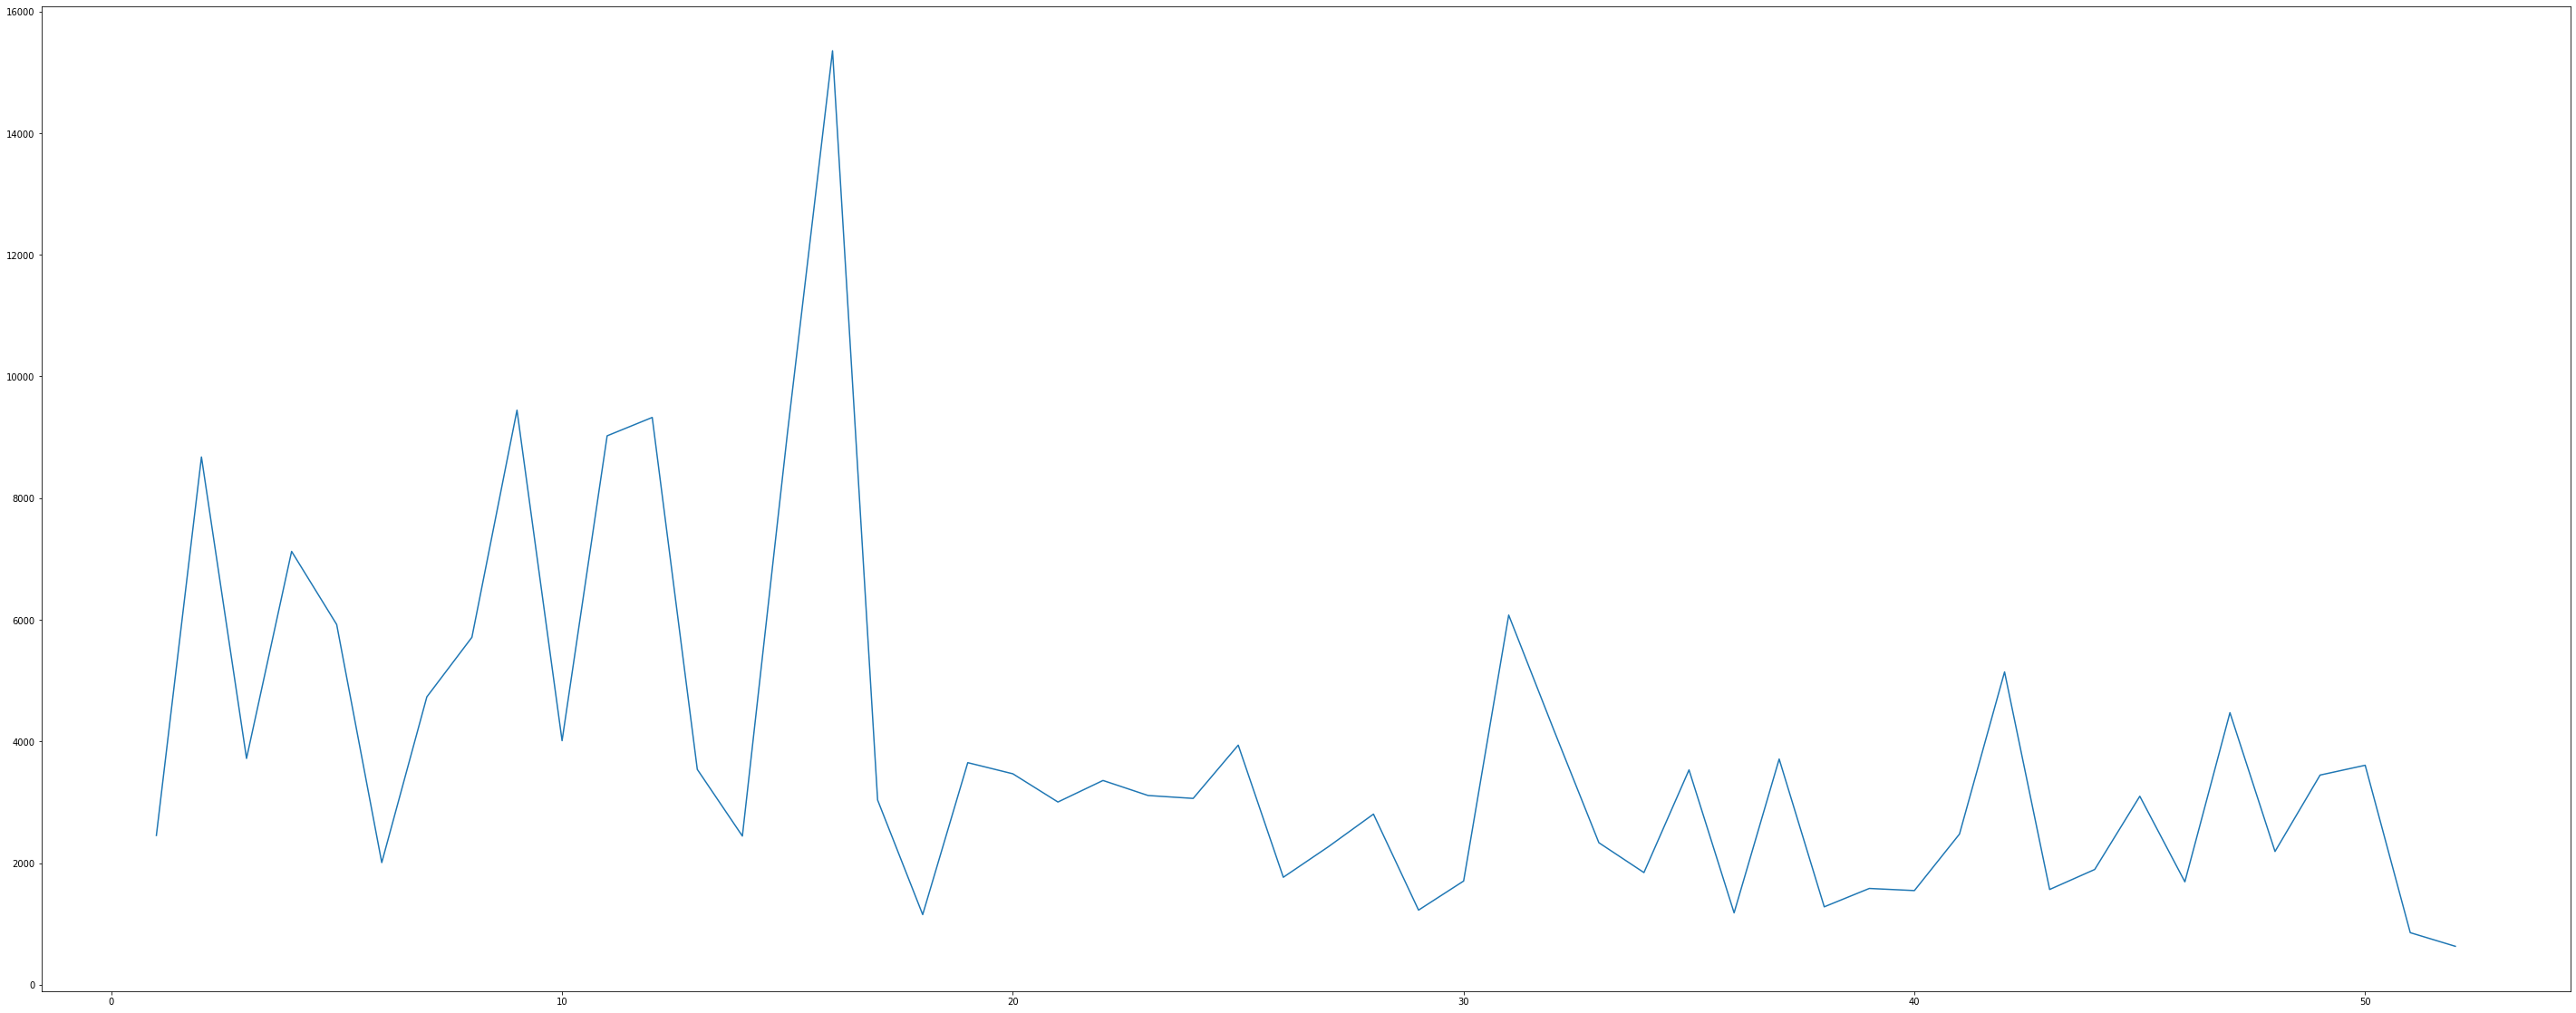

Graph for material D13398148 in year 2017


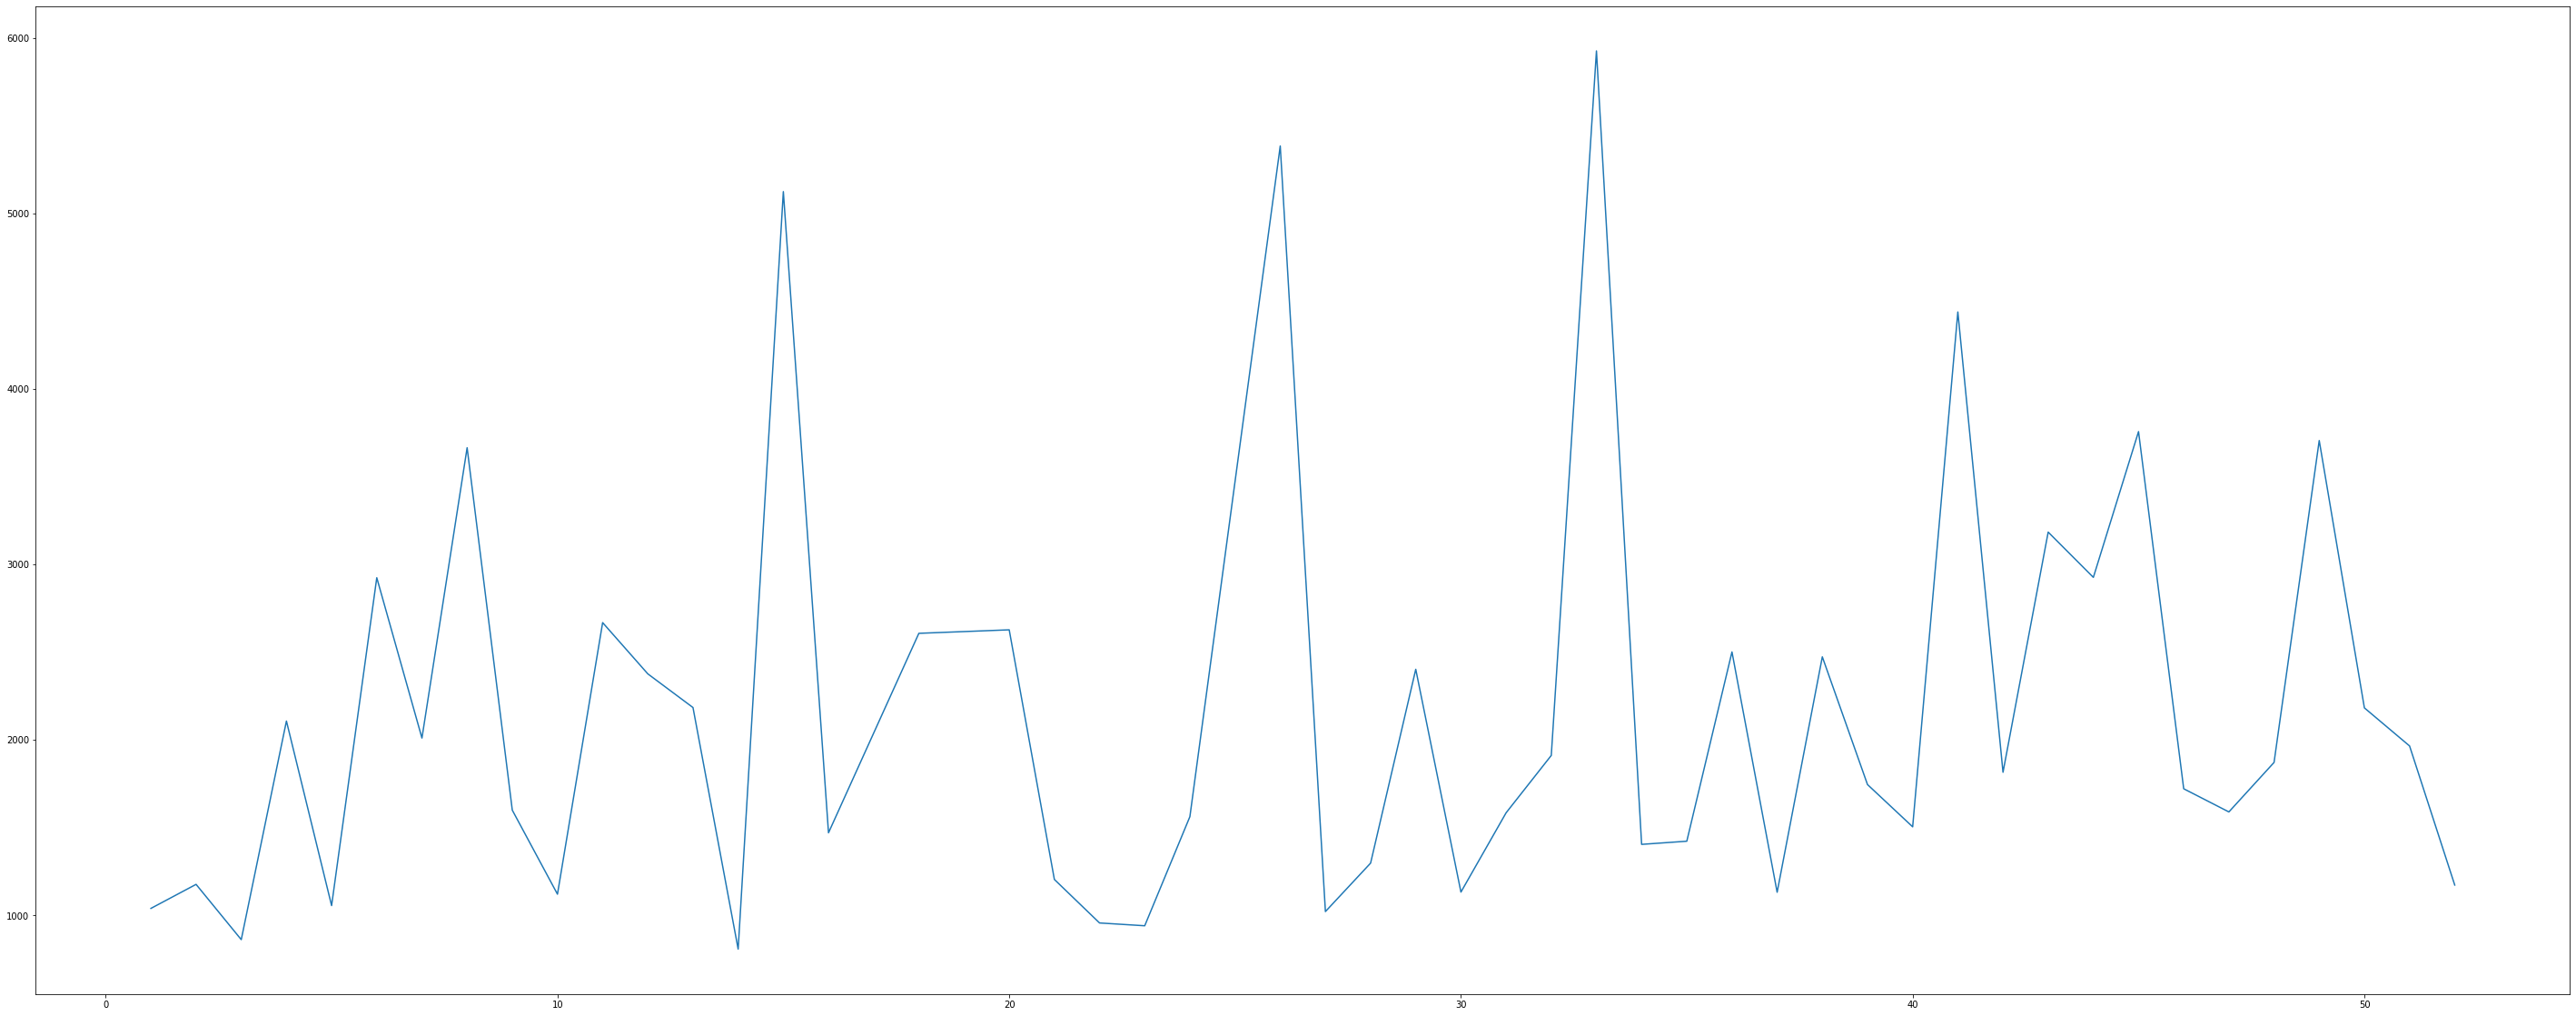

Graph for material D13398148 in year 2018


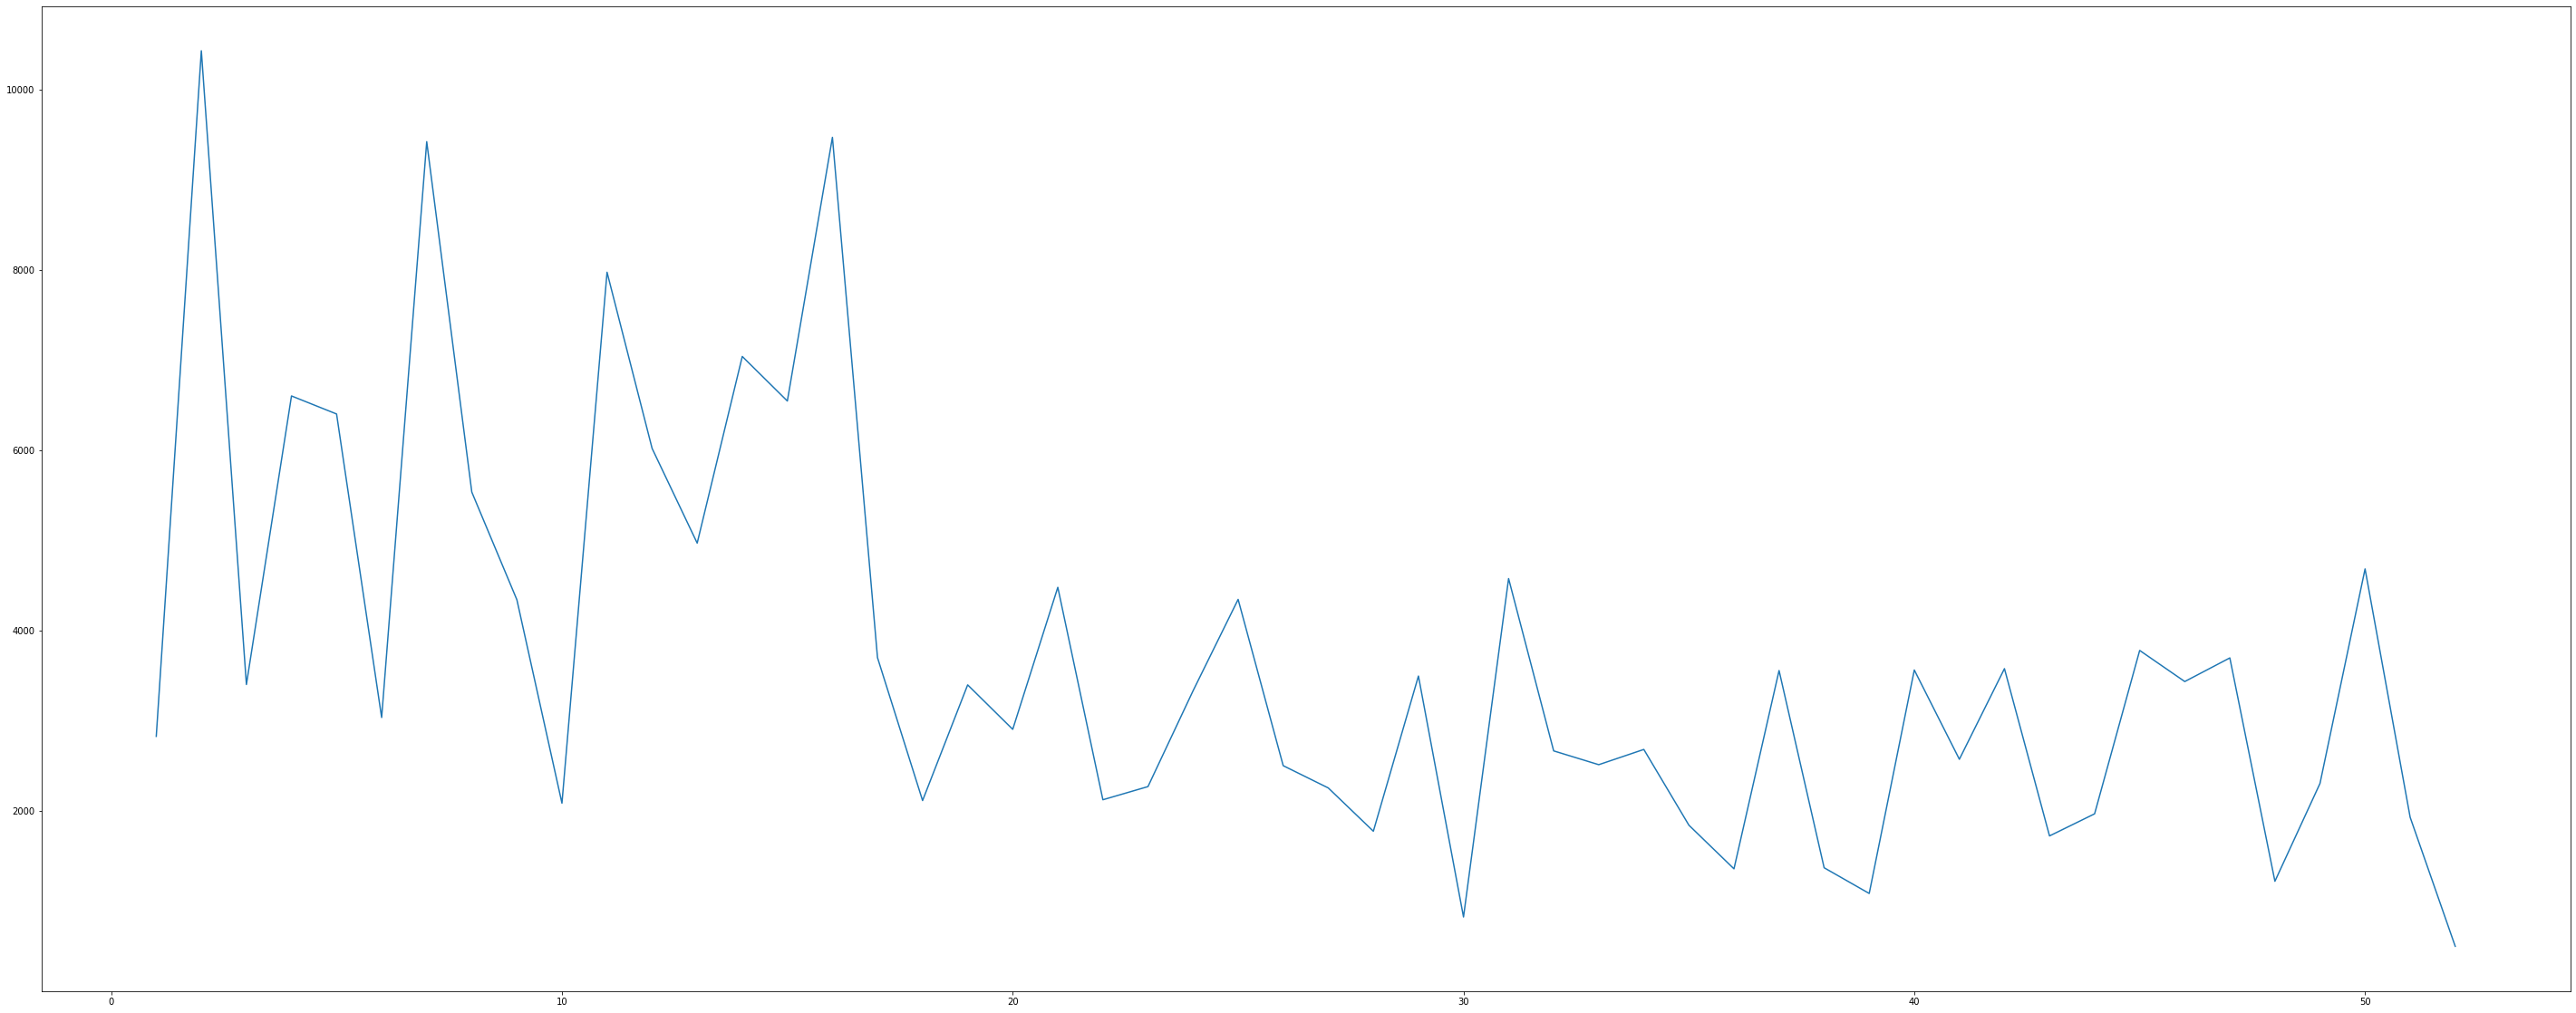

Graph for material D13398112 in year 2017


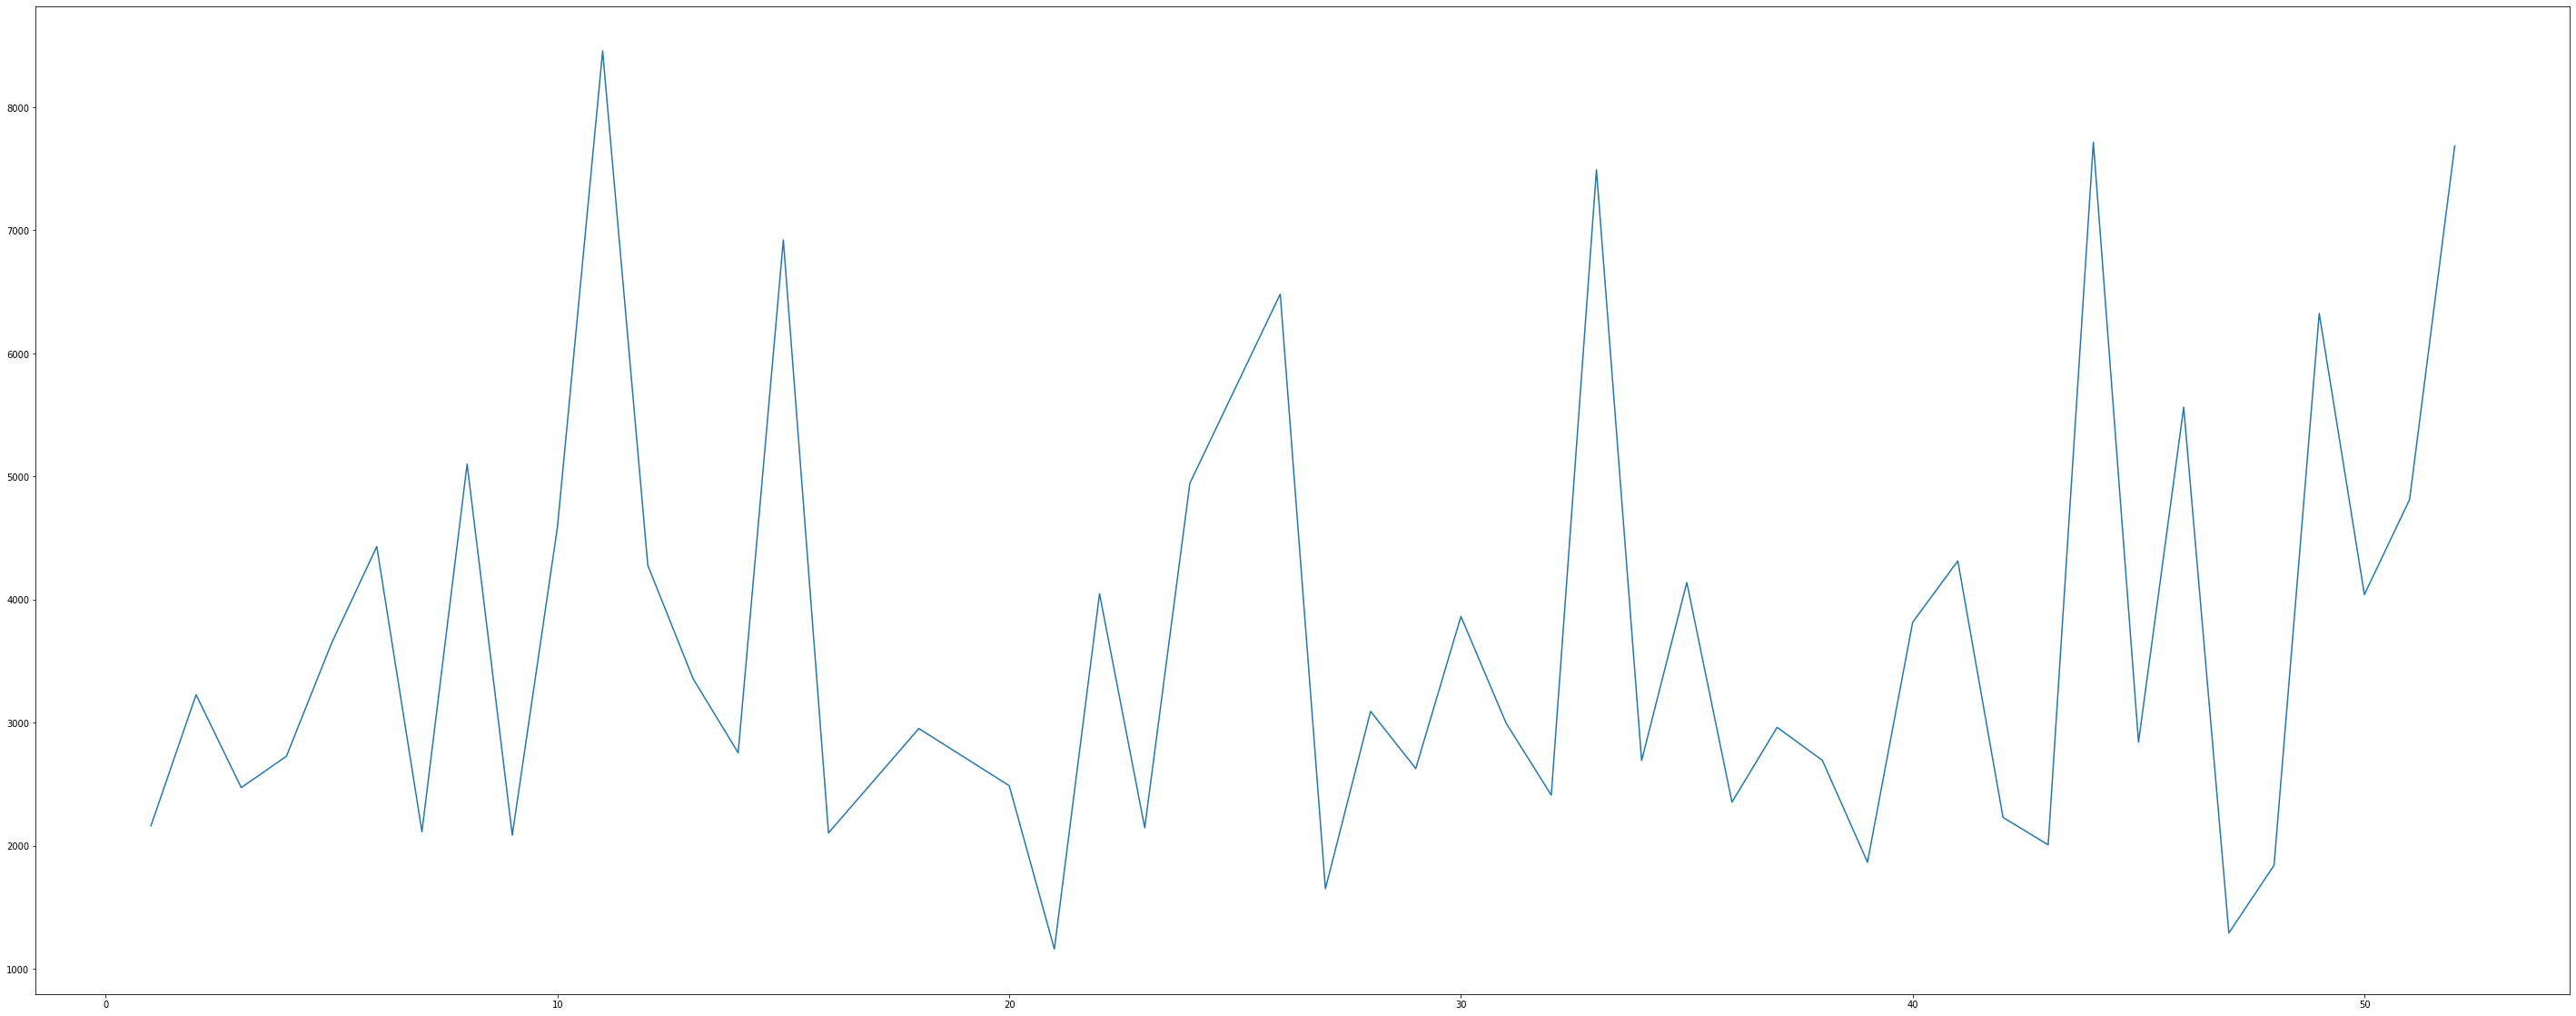

Graph for material D13398112 in year 2018


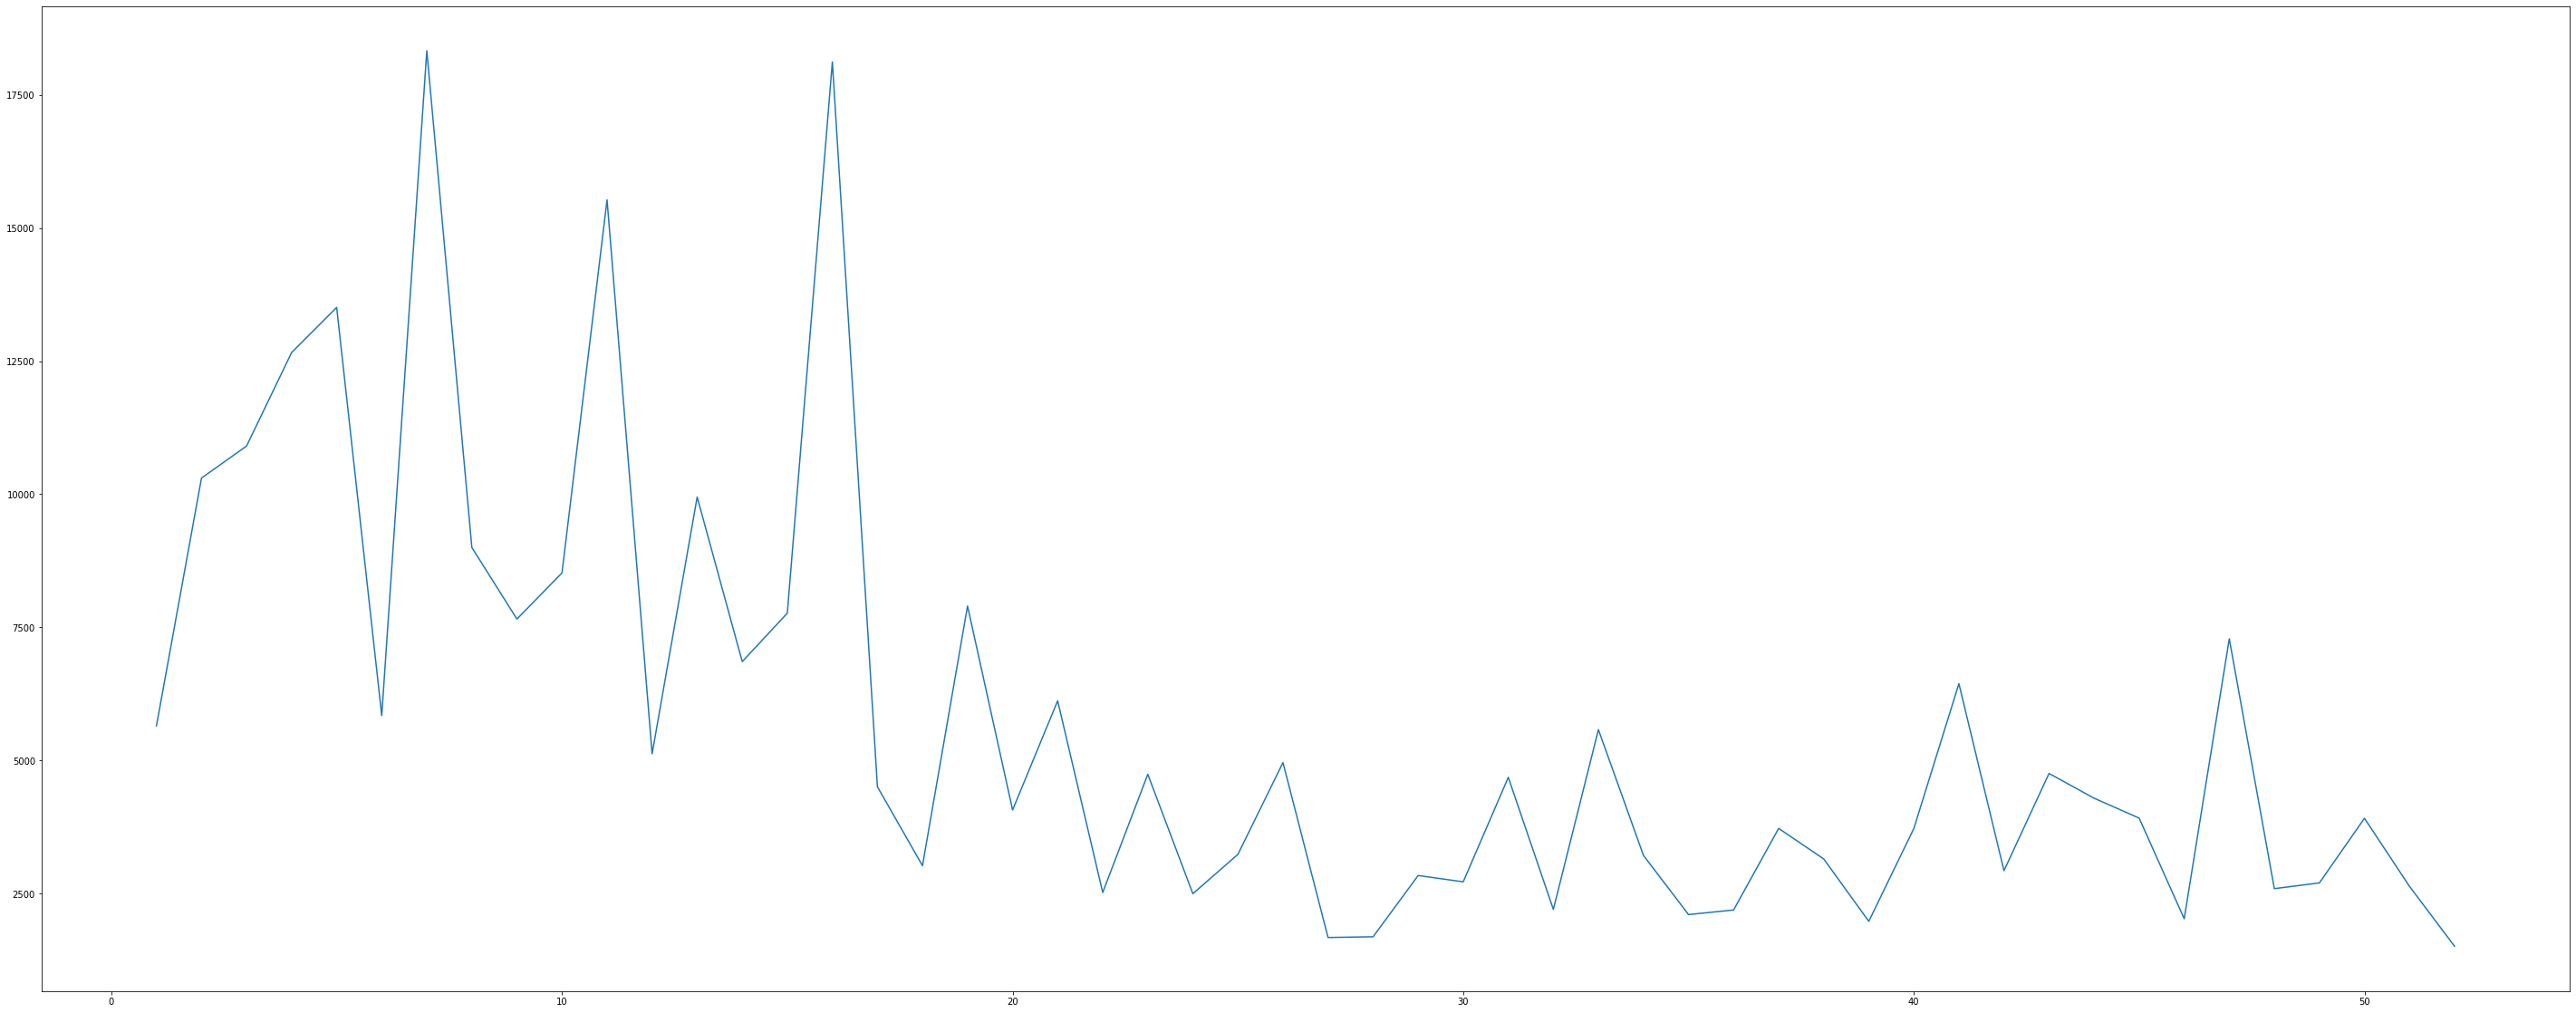

Graph for material D13398151 in year 2017


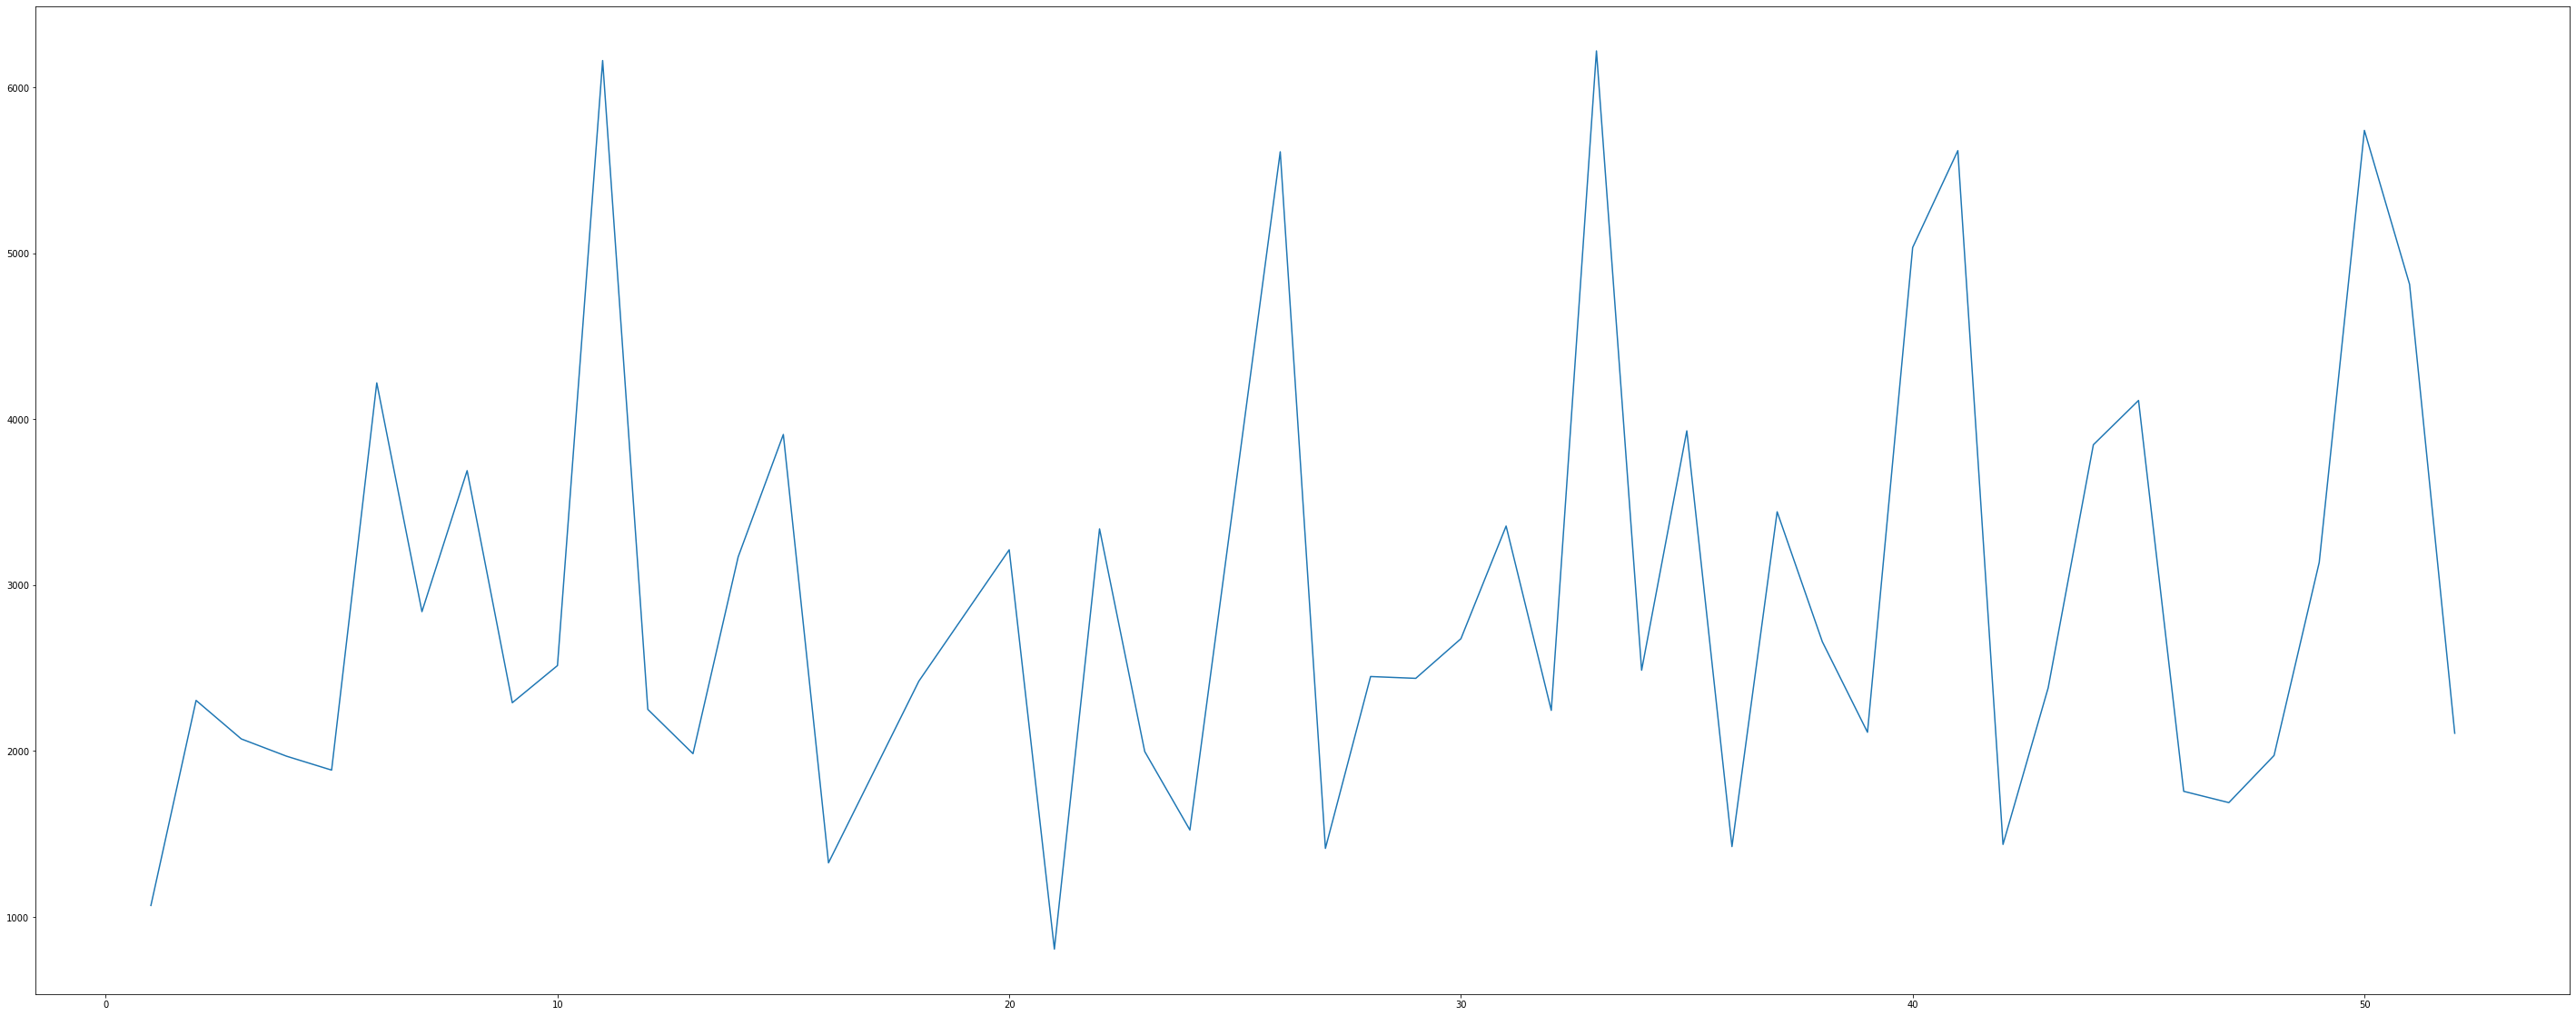

Graph for material D13398151 in year 2018


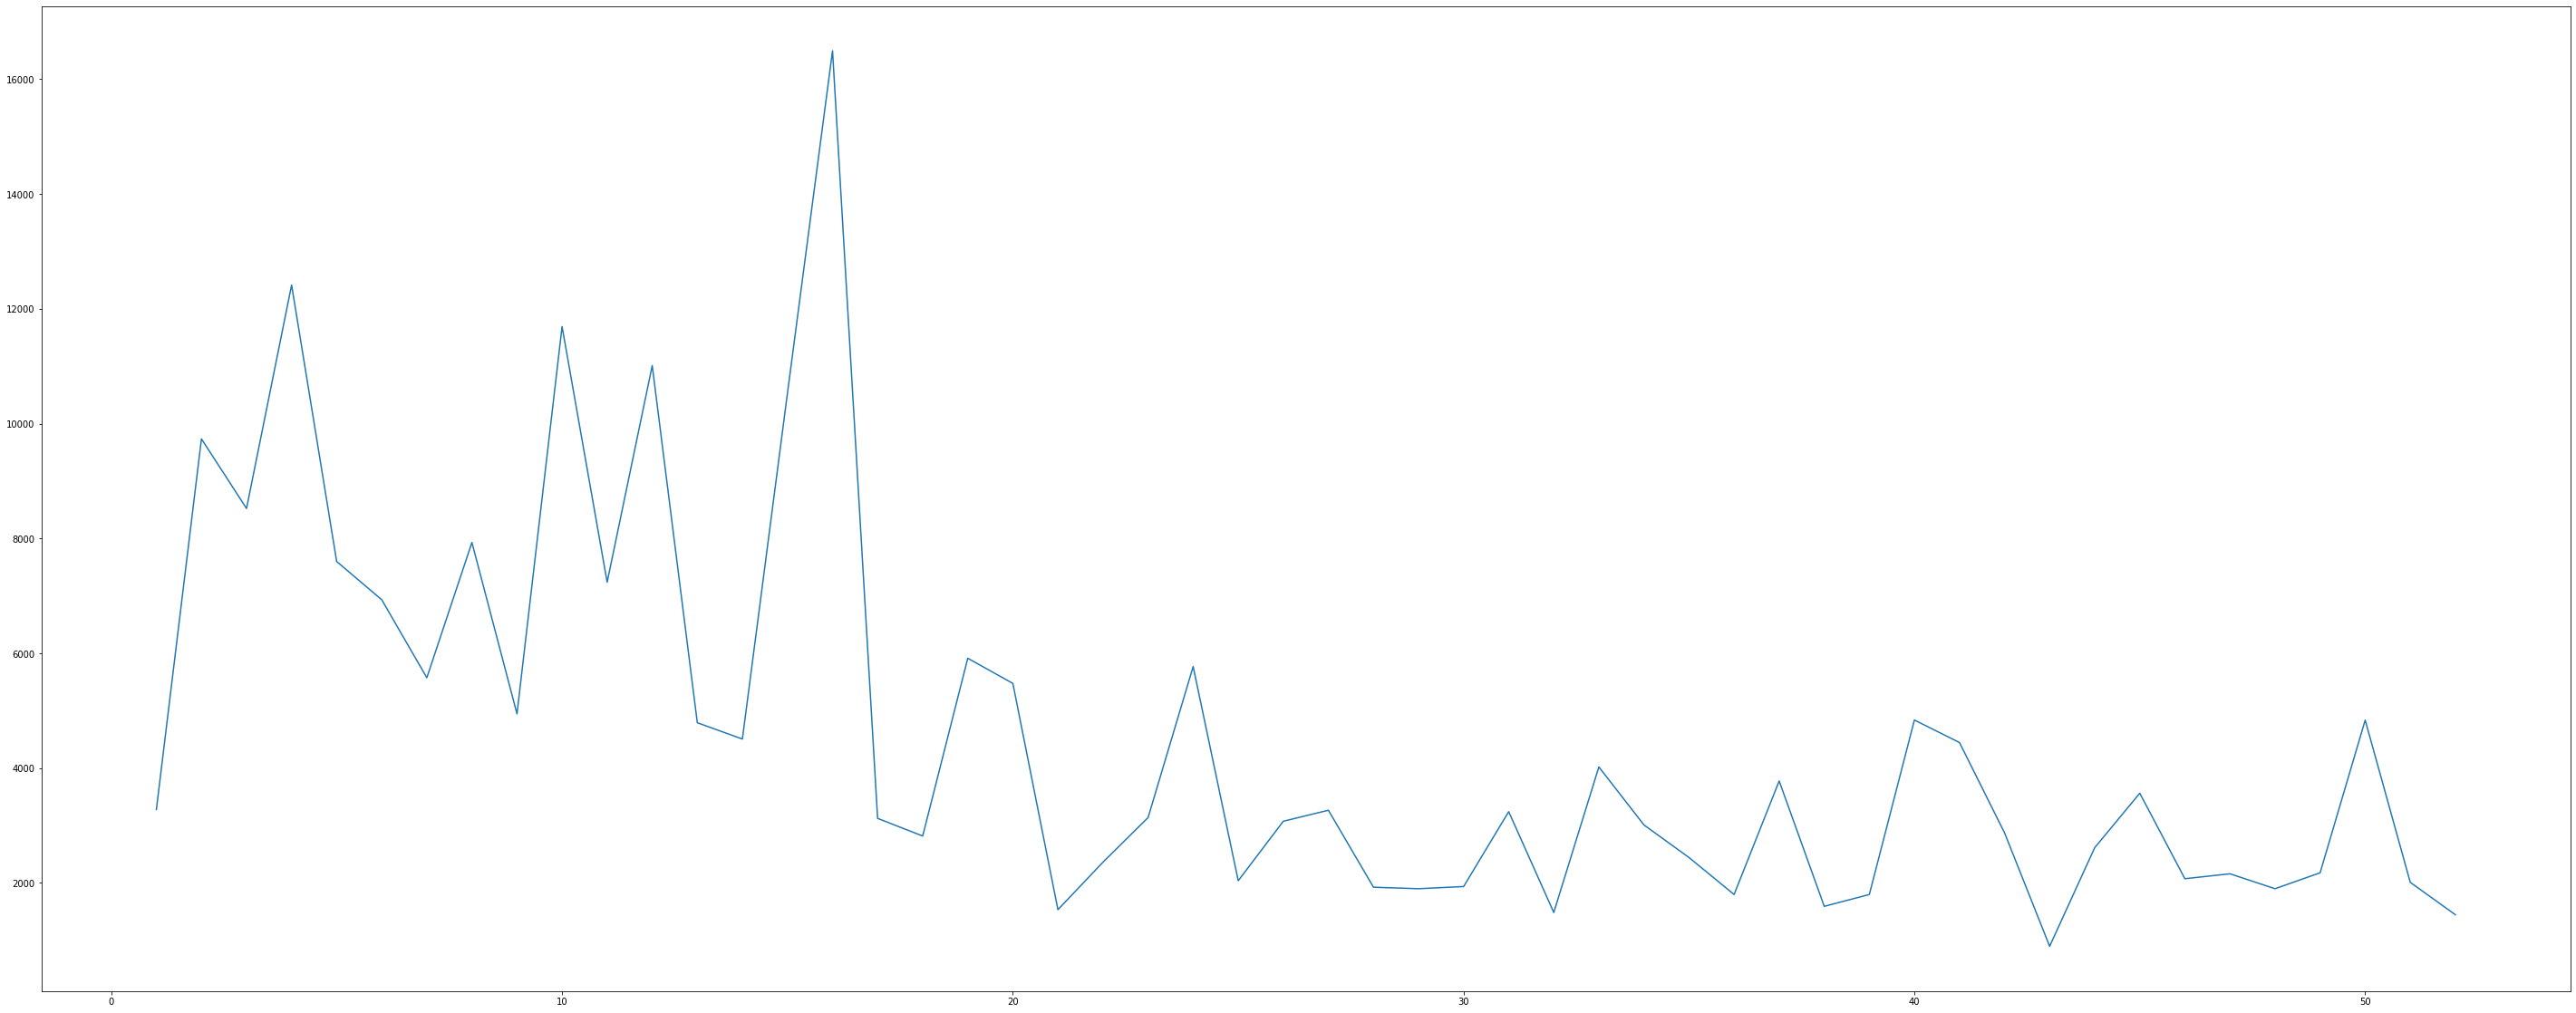

Graph for material D13398135 in year 2017


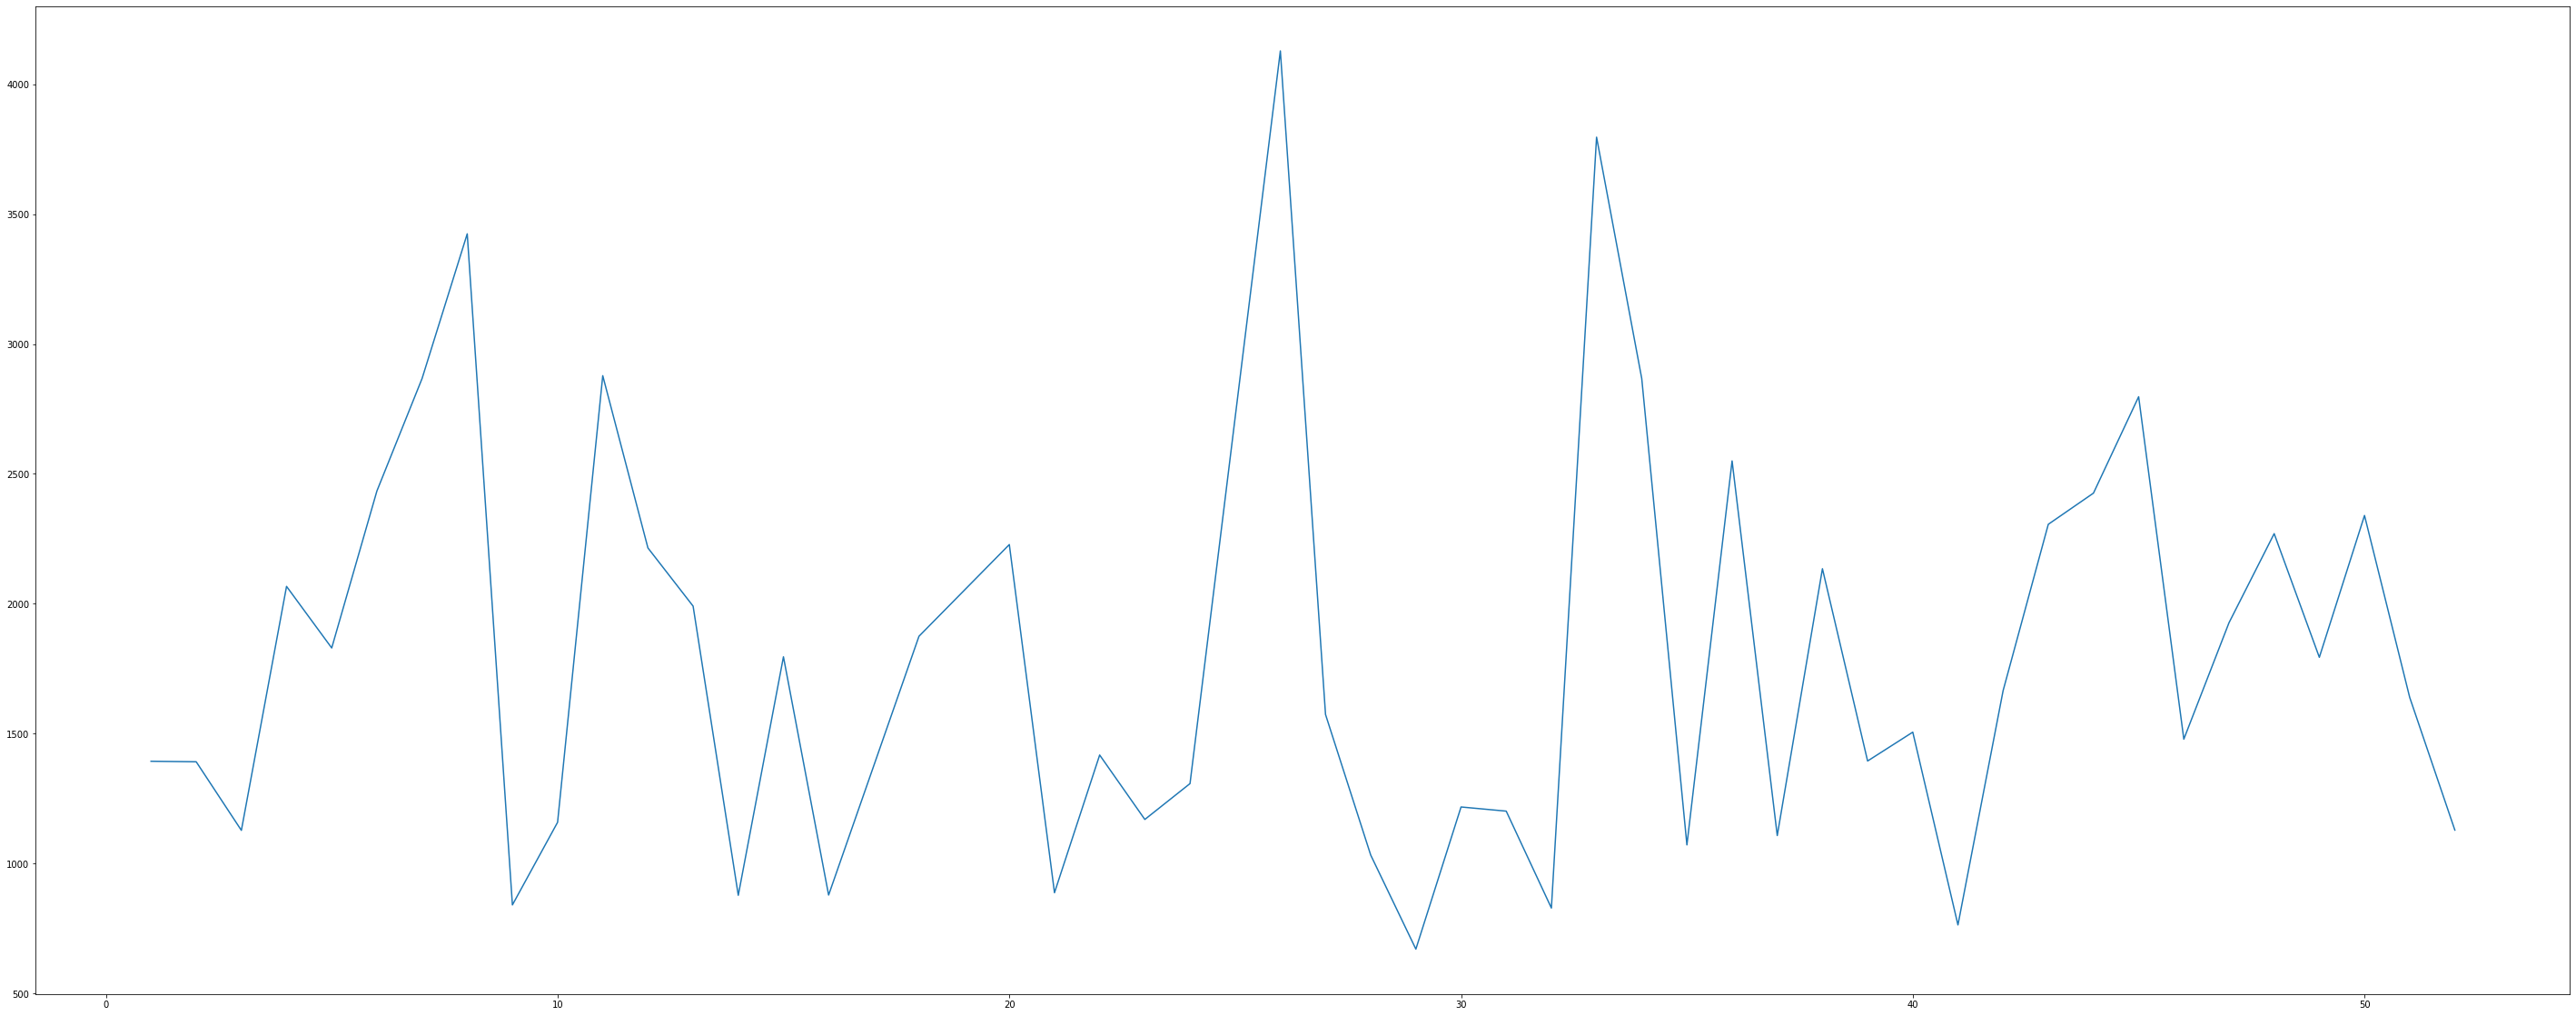

Graph for material D13398135 in year 2018


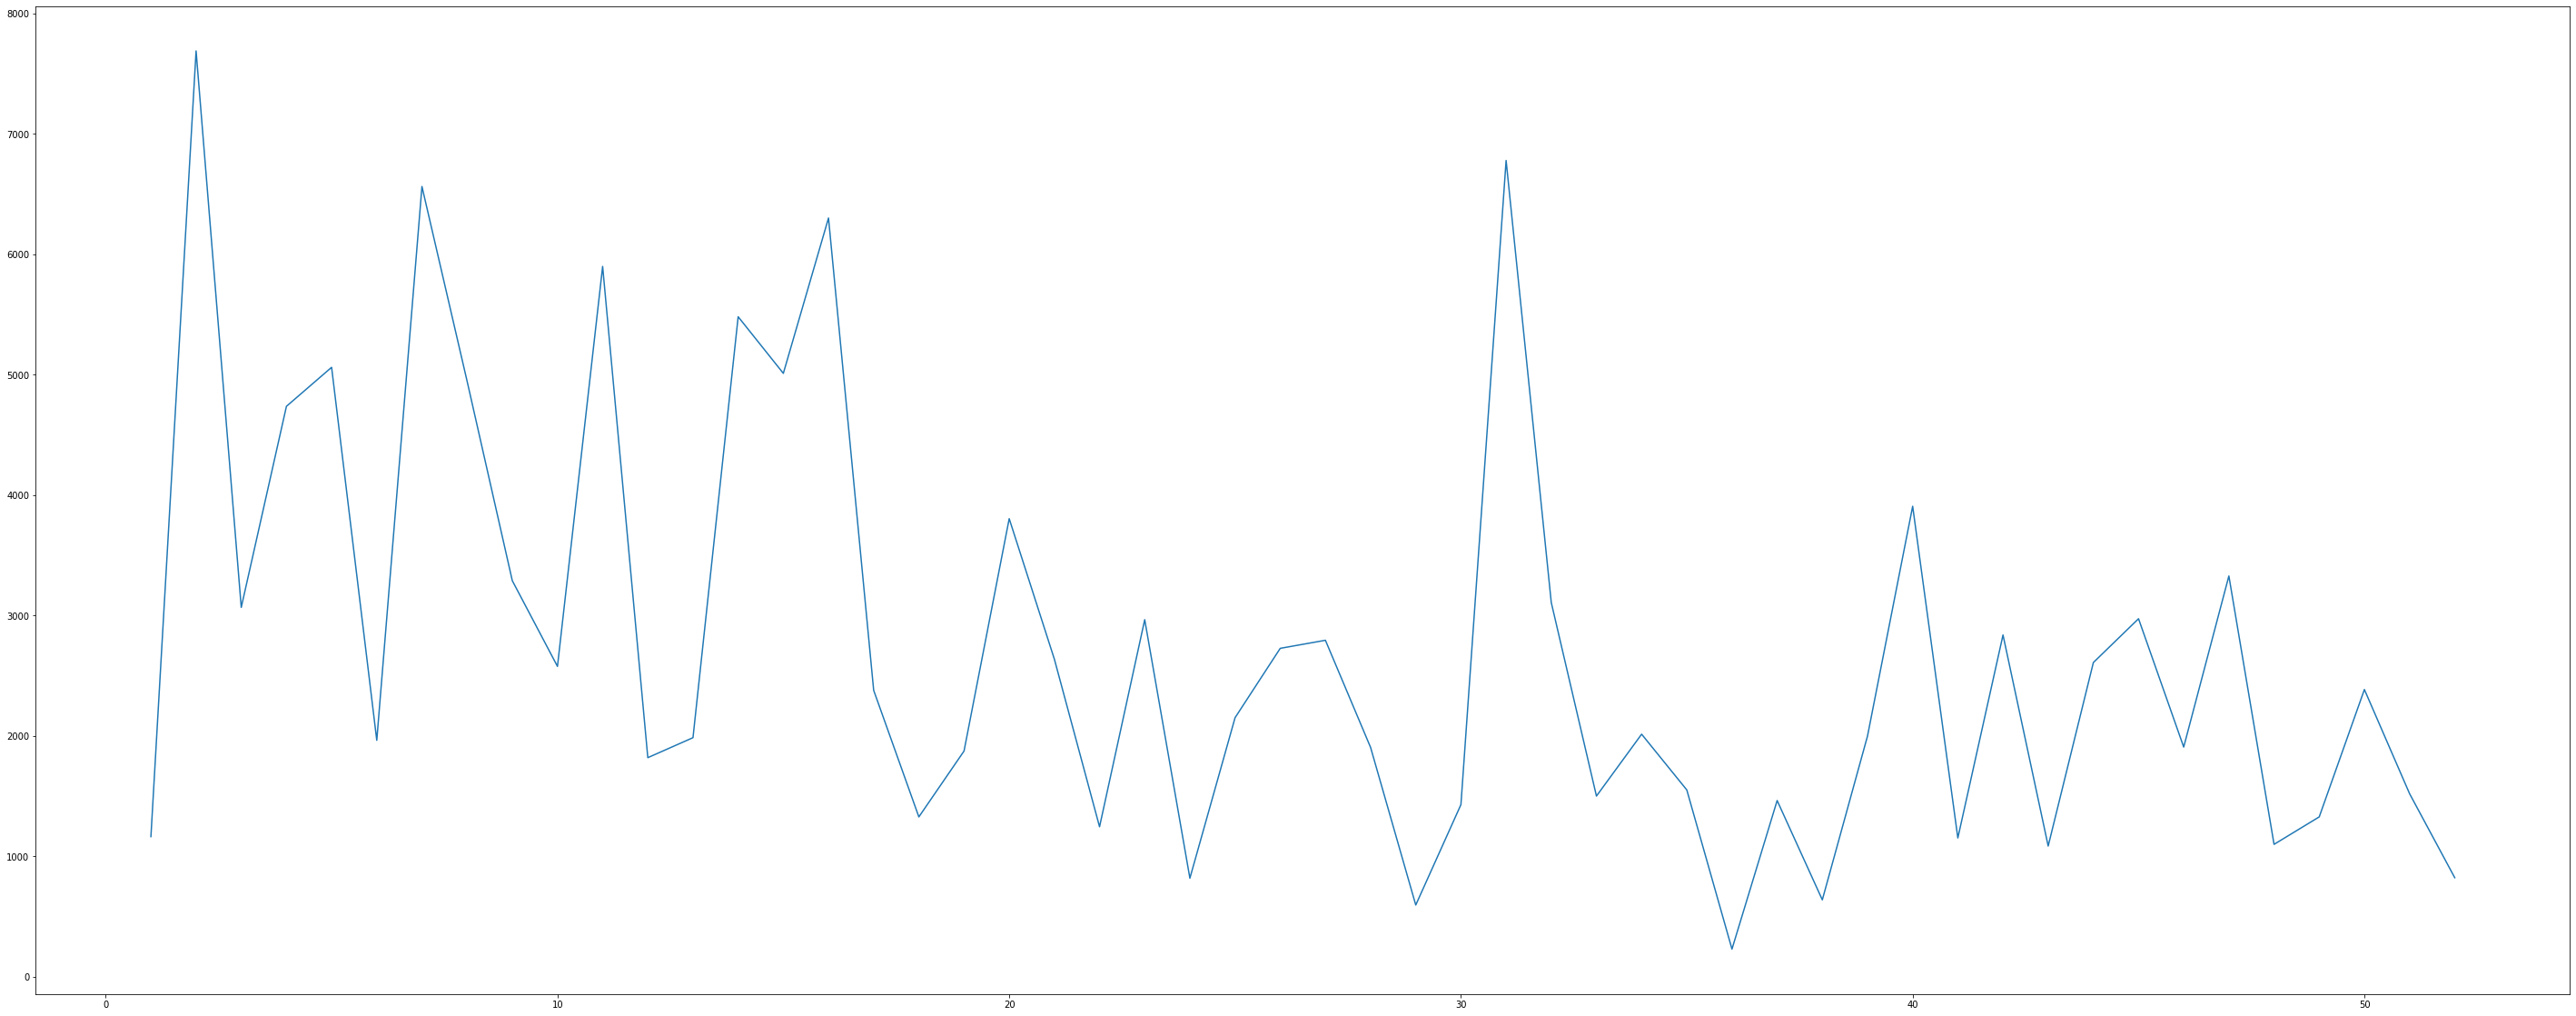

Graph for material D13397918 in year 2017


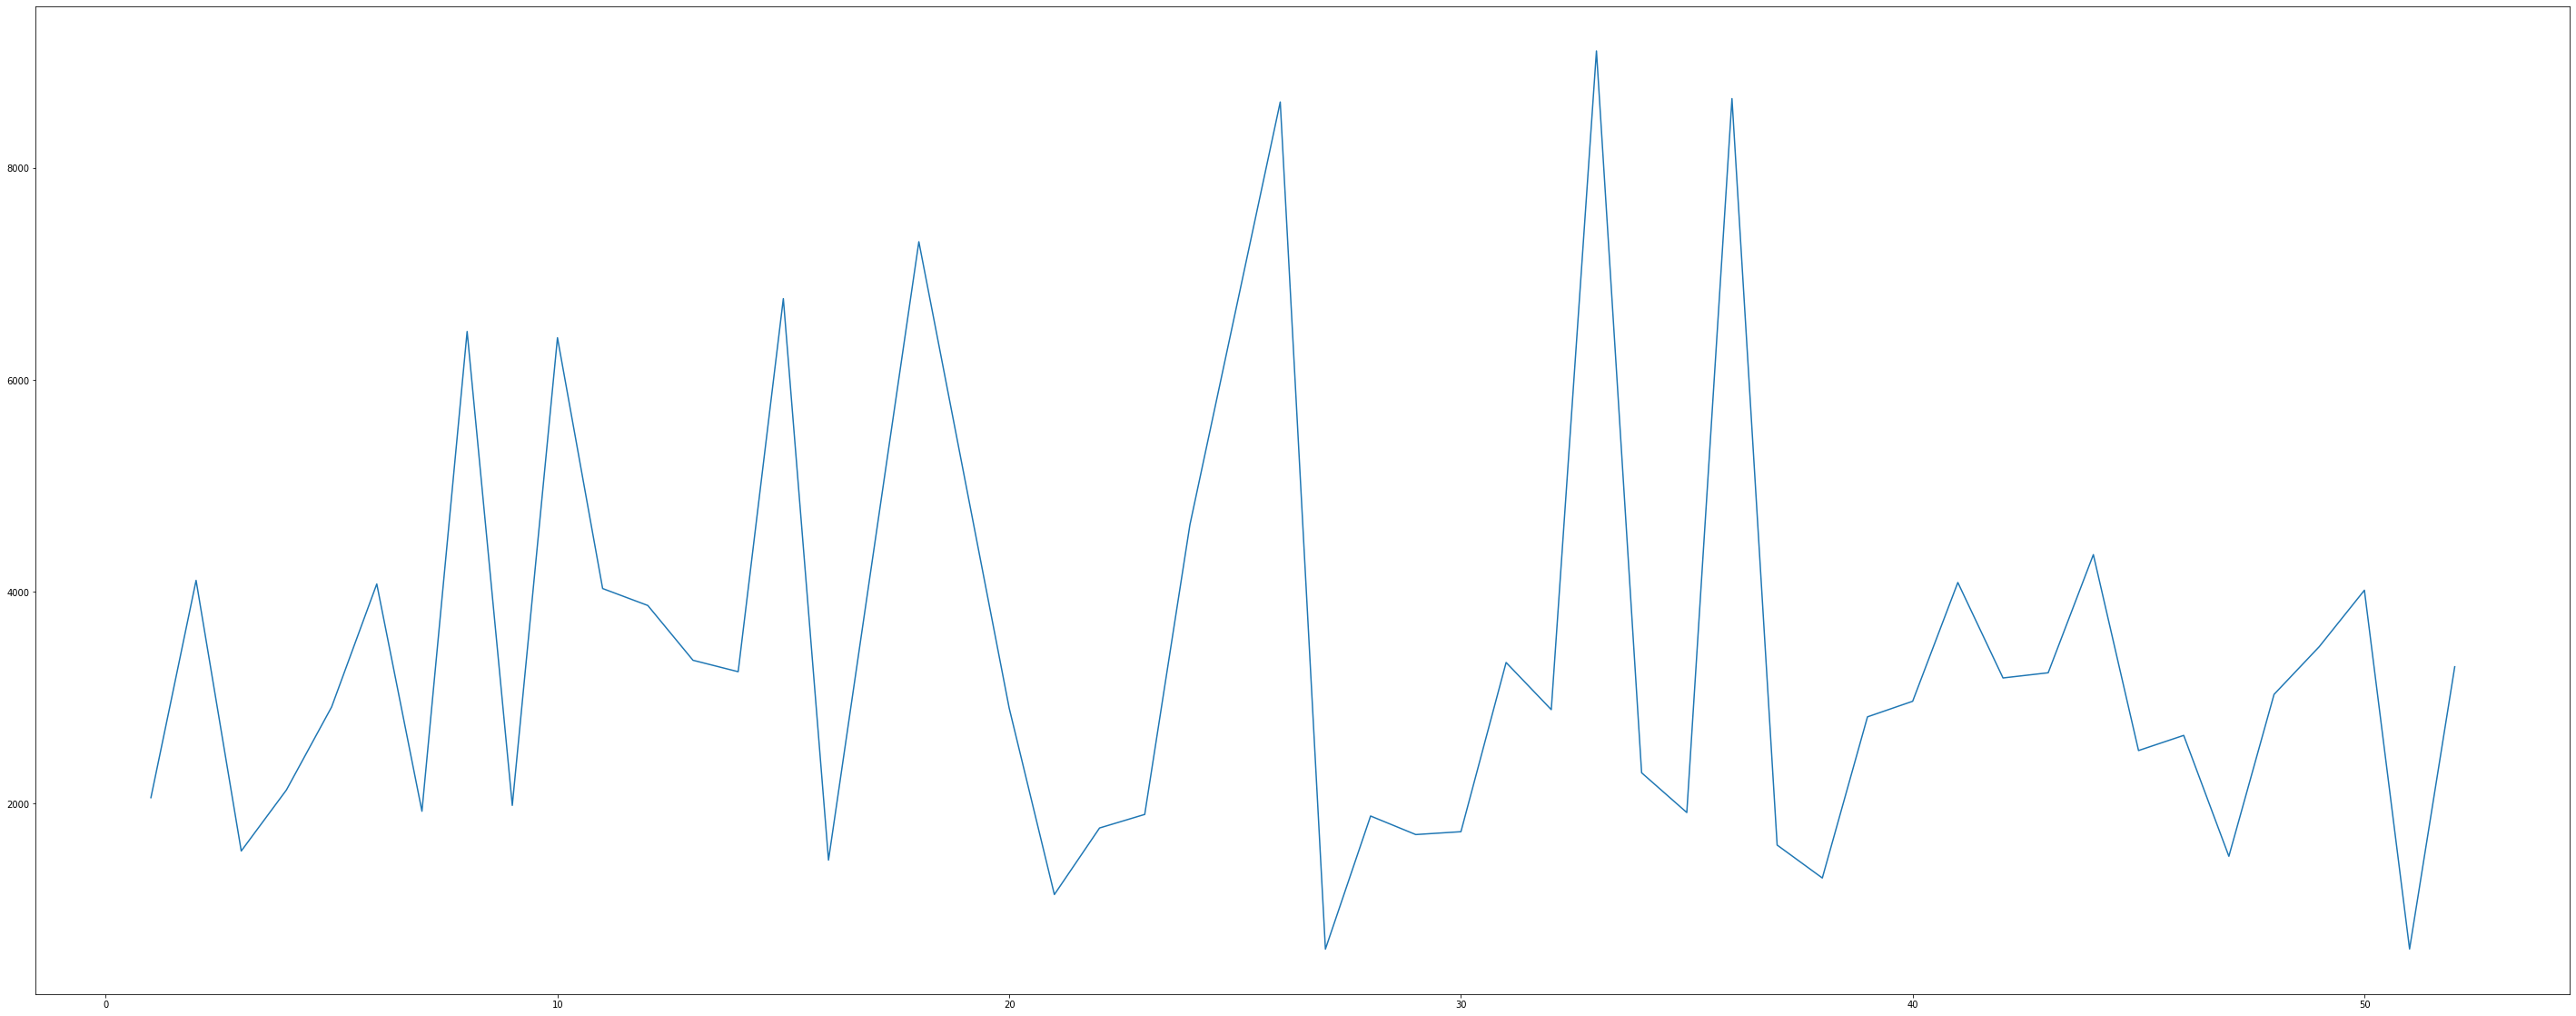

Graph for material D13397918 in year 2018


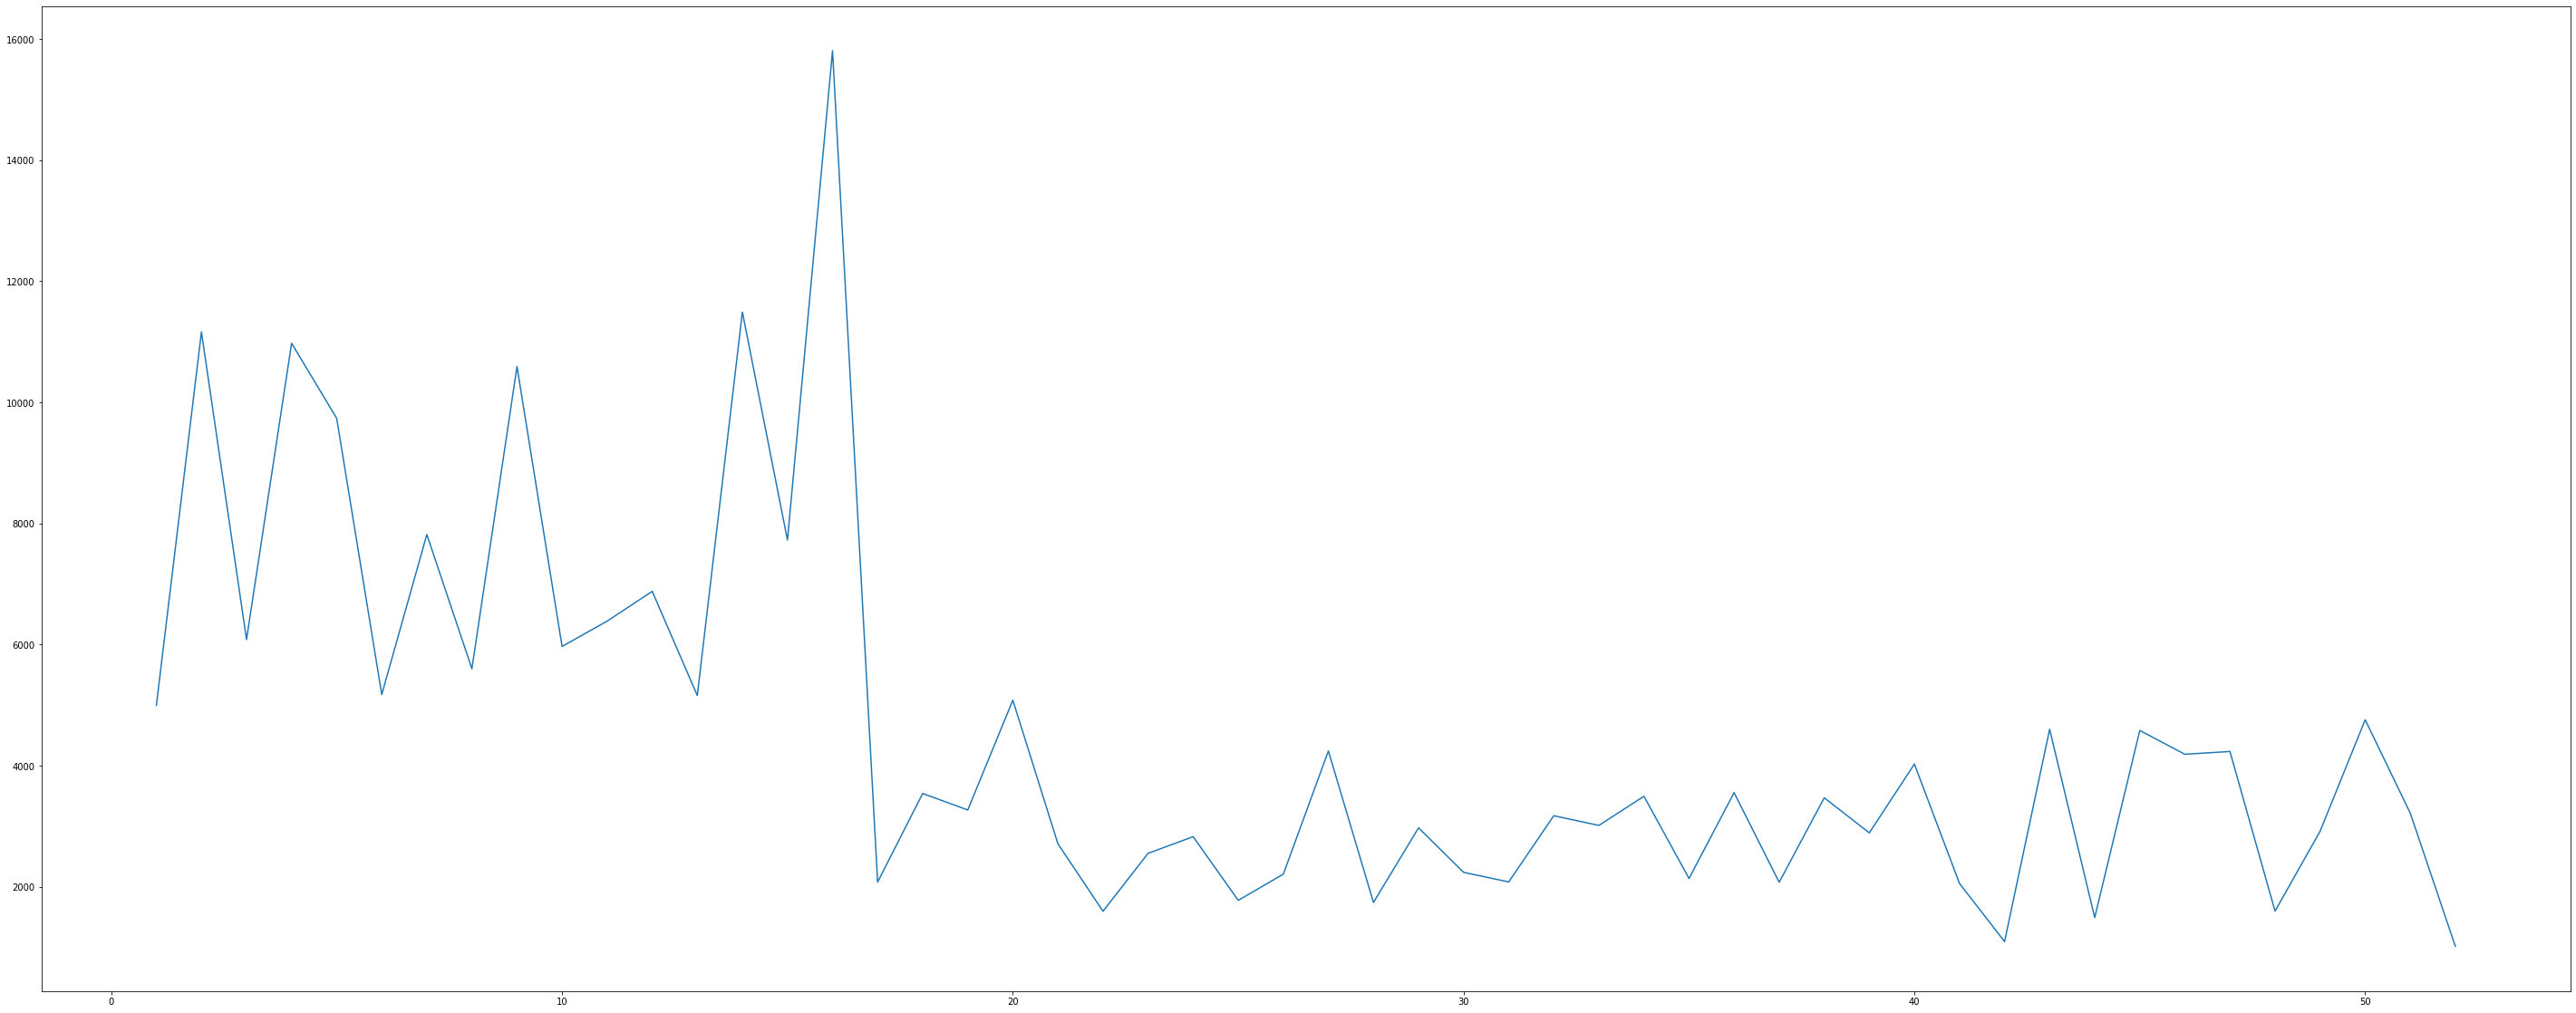

Graph for material D13397940 in year 2017


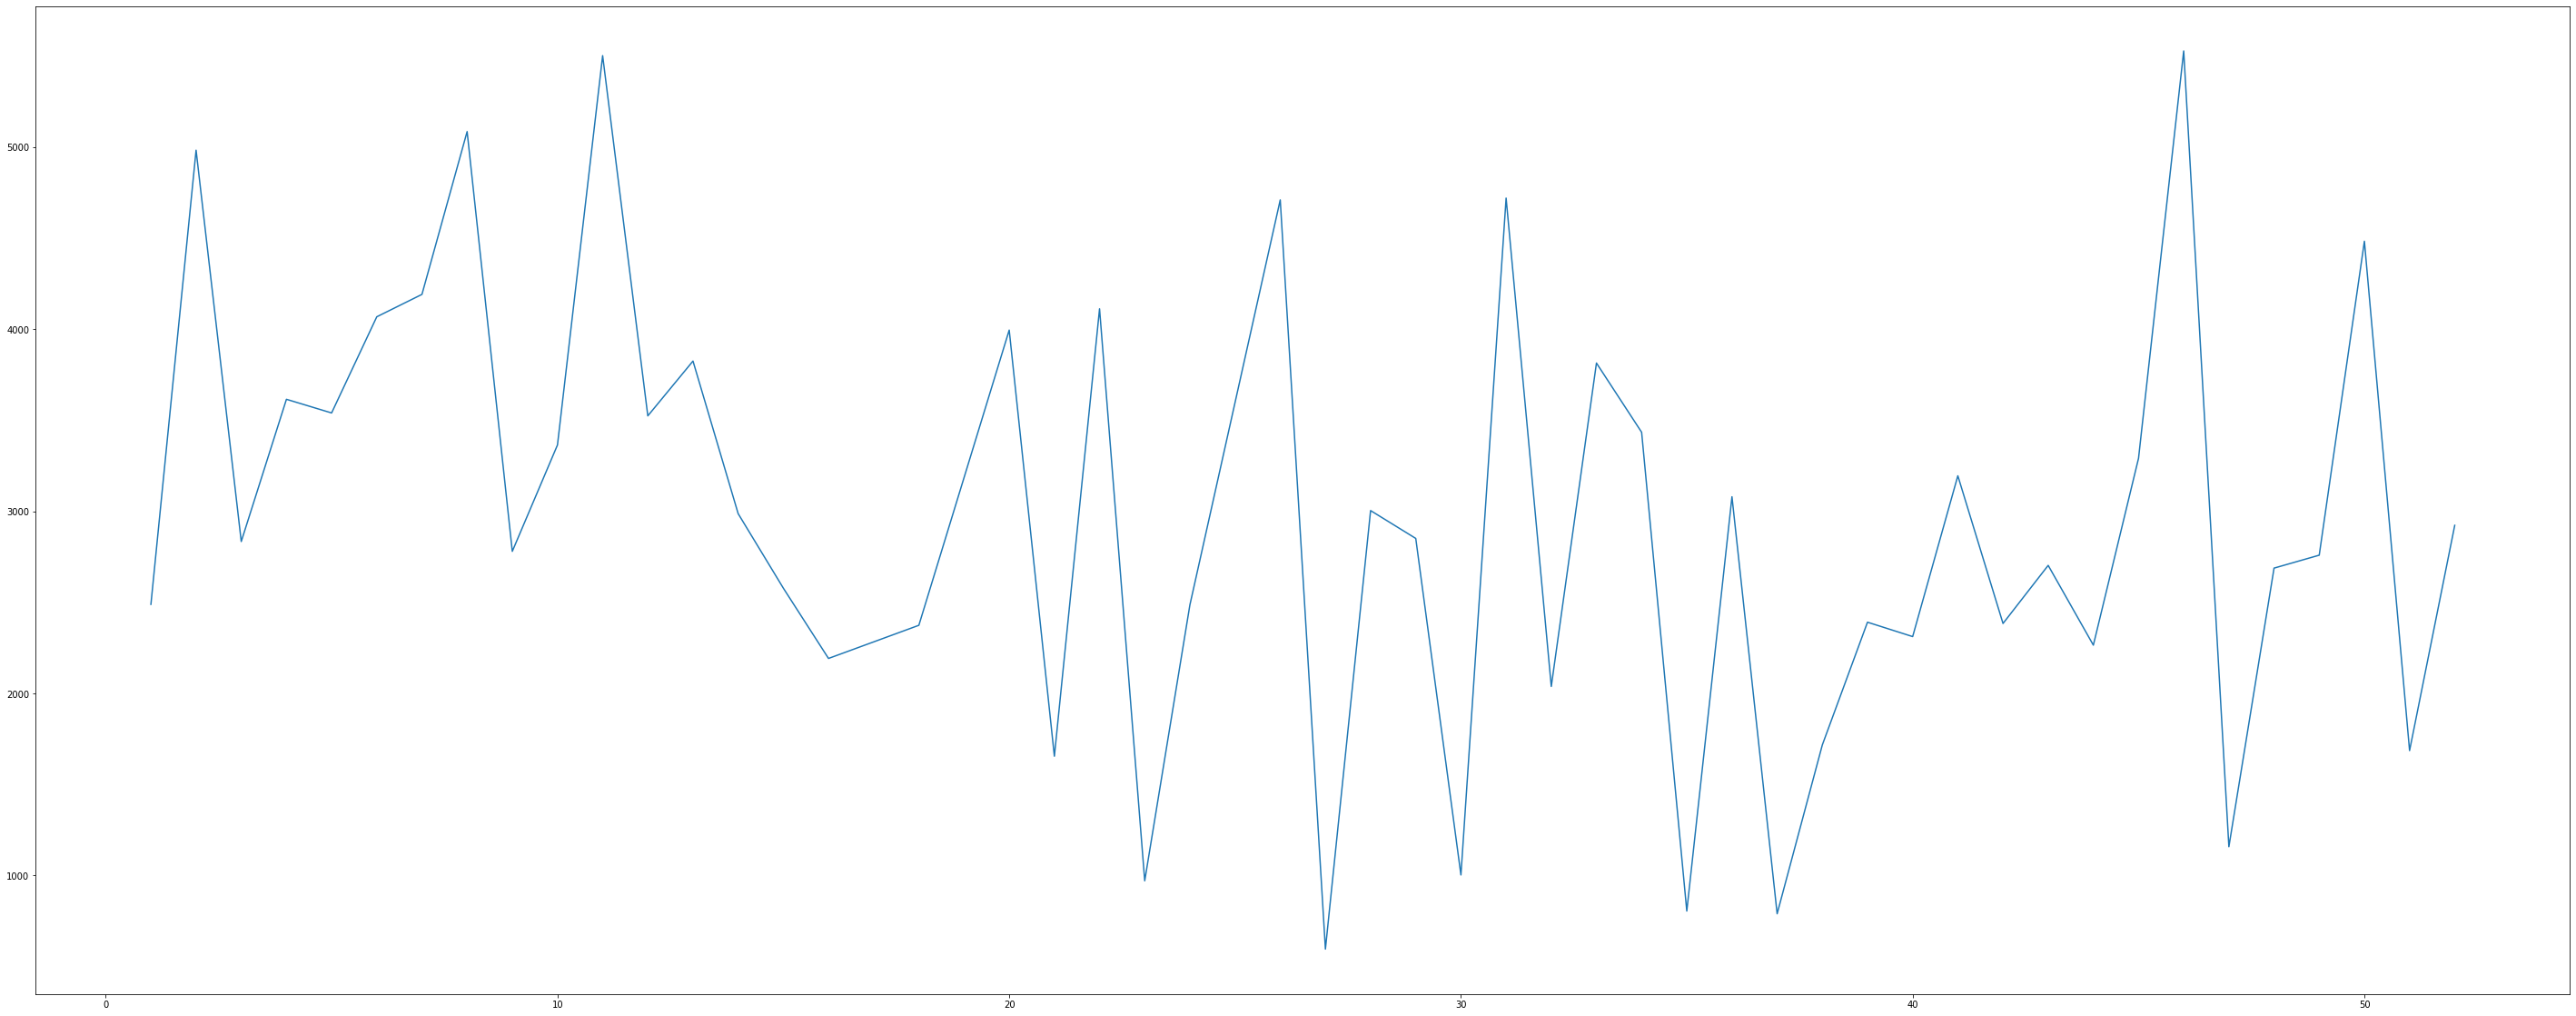

Graph for material D13397940 in year 2018


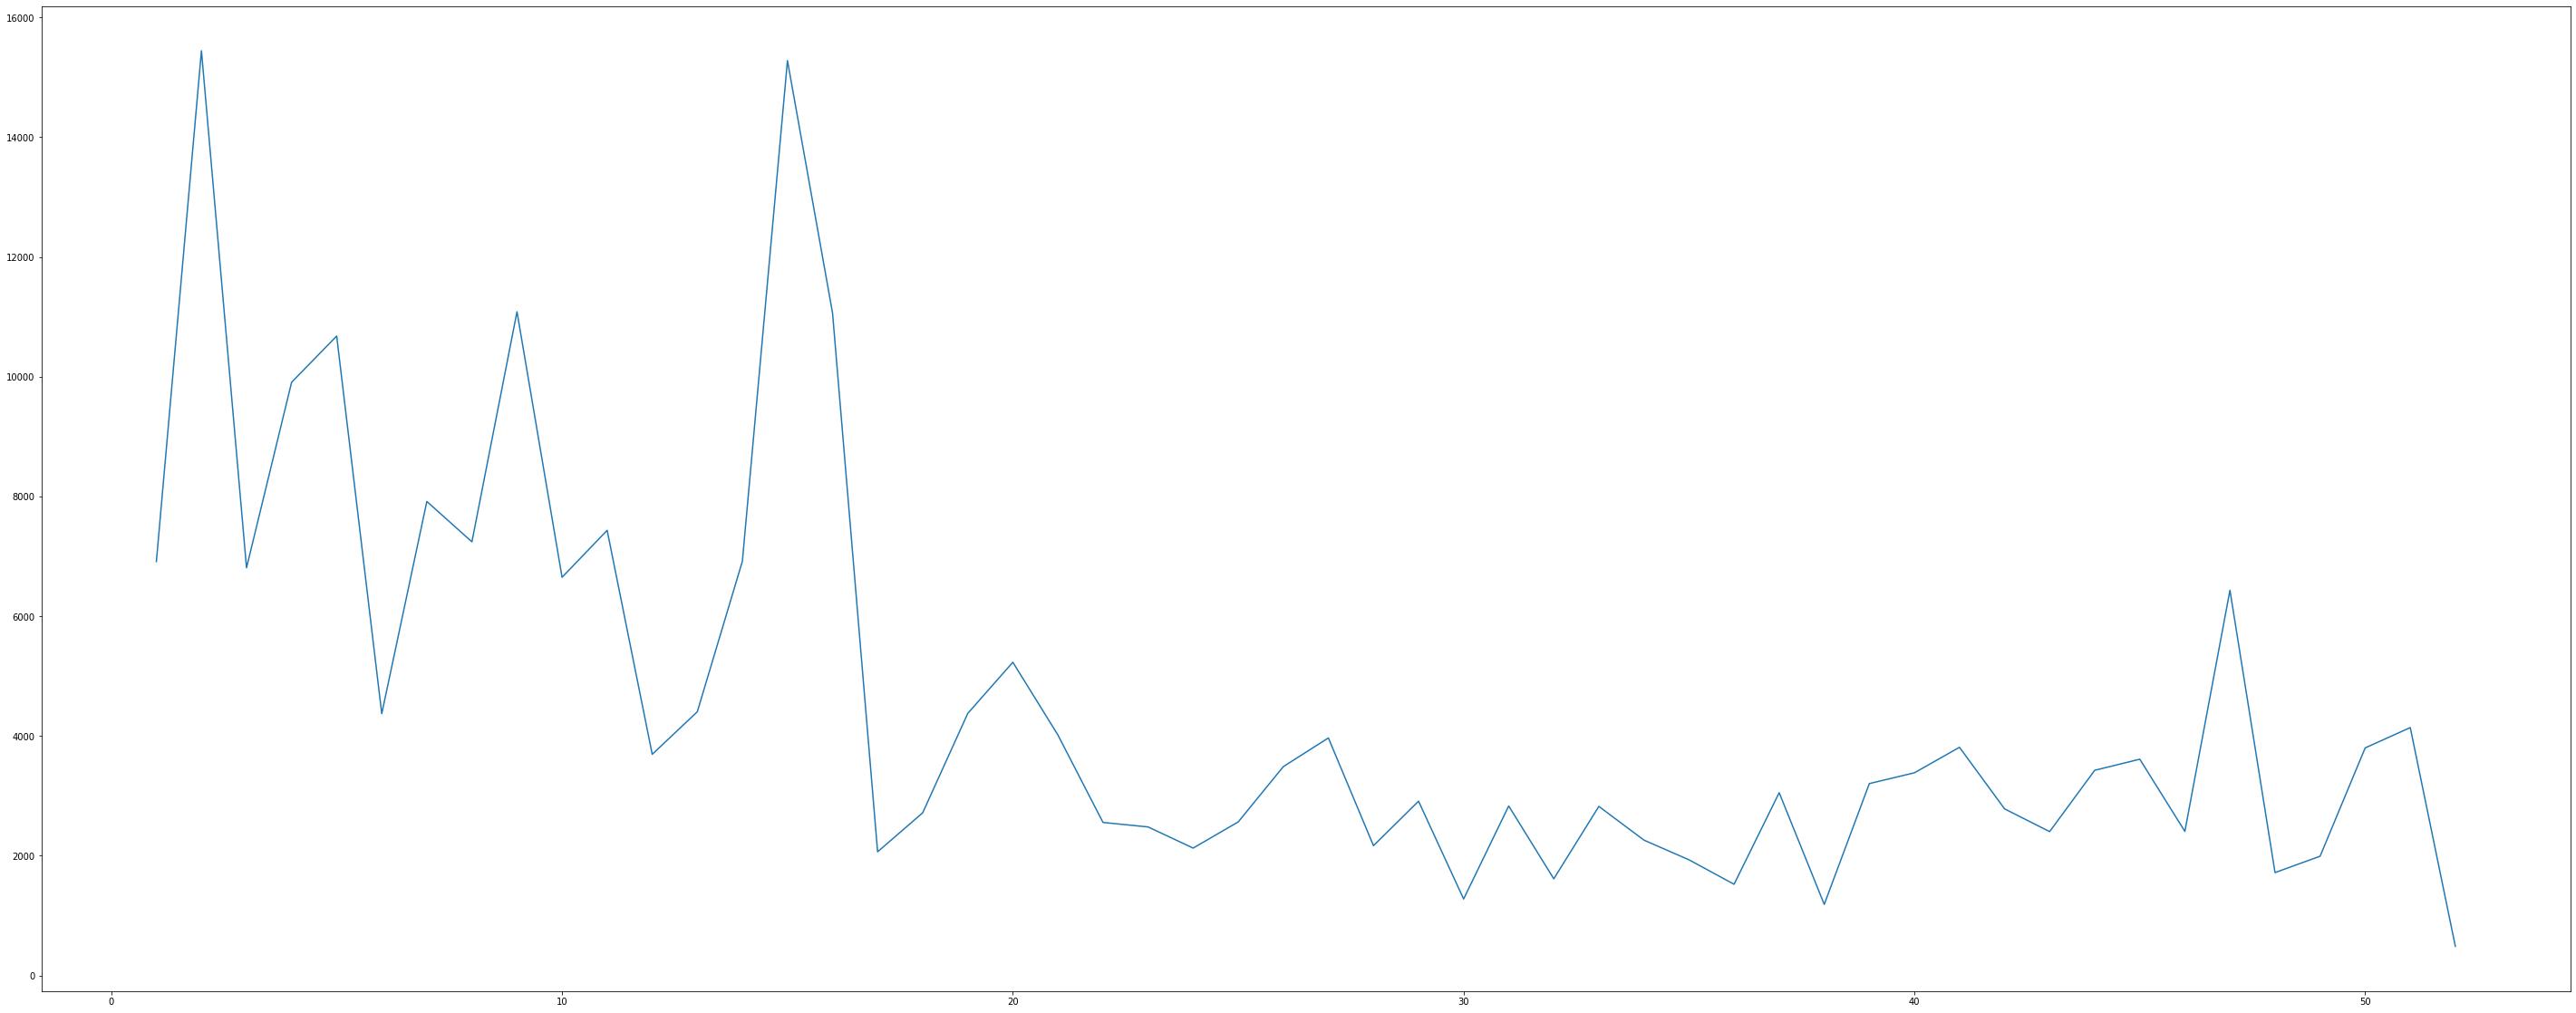

In [45]:
for material in materials:
    for year in [2017, 2018]:
        print("Graph for material {} in year {}".format(material, year))
        material_map(material, year)

## Neural Network

In [121]:
dummy_variables = categorical_features
train_data_nn = data[(data.value >= 1) & (data.cases >= 1) & (data.year >= 2017)]
dropped_columns = ['month', 'sku_class', 'group6_desc', 'service_level', 'IS_HOL', 'sales_date', 'f_day', 'adbno', 'product_description', 'log_cases']
train_data_nn = train_data_nn.drop(dropped_columns, axis=1)

for var in dummy_variables:
    dummy = pd.get_dummies(train_data_nn[var], prefix=var, drop_first=False)
    train_data_nn = pd.concat([train_data_nn, dummy], axis=1)

train_data_nn = train_data_nn.drop(dummy_variables, axis=1)

train_data_nn = train_data_nn[np.abs(zscore(train_data_nn.cases.apply(lambda x: np.log(x + 1))) < 1.96)]

to_drop = ['cases', 'value']
x_data = train_data_nn.drop(['cases', 'value'], axis=1)
y_data = pd.DataFrame(data=train_data_nn['cases'])

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data.cases.apply(lambda x: np.log(x+1)))


# Convert data as np.array
nn_features = np.array(x_train)
#targets = np.array(y_train.reshape(y_train.shape[0],1))
nn_targets = np.array(y_train)
nn_features_validation= np.array(x_val)
#targets_validation = np.array(y_test.reshape(y_test.shape[0],1))
nn_targets_validation = np.array(y_val)

print(nn_features[:10])
print(nn_targets[:10])

cases    value  est_lead_time  material_D13384914  material_D13395853  \
0      1    74.84             16                   1                   0   
1      2   149.68             16                   1                   0   
2     24  1803.06             16                   1                   0   
3      9   717.75             16                   1                   0   
4      8   659.76             16                   1                   0   

   material_D13395864  material_D13395927  material_D13395945  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   material_D13395960  material_D13395979  ...  weekyear_43  weekyear_44  \
0                   0                   0  ...            0            0   
1                   0                   0  ...            0            0   
2                   0                   0  ...            0            0   
3                   0                   0  ...            0            0   
4                   0                   0  ...            0            0   

   weekyear_45  weekyear_46  weekyear_47  weekyear_48  weekyear_49  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   weekyear_50  weekyear_51  weekyear_52  
0            0            0            0  
1            0            0            0  
2            0            0            0  
3            0            0            0  
4            0            0            0  

[5 rows x 1612 columns]

We applied `one-hot encoding` to our categorical features and prepared our `features` and `targets` for the neural network. Next step is the creation of a very simple FF network.